## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


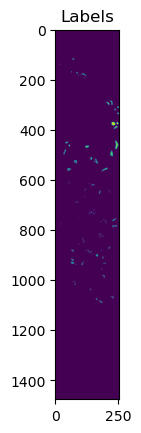

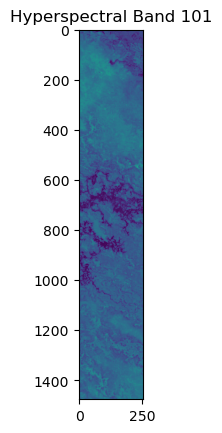

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels


Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
Selecte


All datasets saved to the 'indices' folder.
(70, 5, 5, 145)
(70, 5, 5, 145)
(3108, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 70
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2227, PSNR: -8.0971


Epoch [1/50] Training Loss: 0.2118, PSNR: -8.6742
	[Val]   Batch [1/11] Loss: 0.2029, PSNR: -6.1104
	[Val]   Batch [10/11] Loss: 0.2031, PSNR: -8.3492
Epoch [1/50] Validation Loss: 0.2029, PSNR: -8.0414

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1976, PSNR: -5.9949


Epoch [2/50] Training Loss: 0.1899, PSNR: -8.2893
	[Val]   Batch [1/11] Loss: 0.1747, PSNR: -5.4595
	[Val]   Batch [10/11] Loss: 0.1750, PSNR: -7.7035
Epoch [2/50] Validation Loss: 0.1746, PSNR: -7.3883

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1749, PSNR: -7.0478


Epoch [3/50] Training Loss: 0.1689, PSNR: -7.7832
	[Val]   Batch [1/11] Loss: 0.1522, PSNR: -4.8624
	[Val]   Batch [10/11] Loss: 0.1526, PSNR: -7.1088
Epoch [3/50] Validation Loss: 0.1522, PSNR: -6.7933

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1554, PSNR: -7.8917


Epoch [4/50] Training Loss: 0.1486, PSNR: -7.2490
	[Val]   Batch [1/11] Loss: 0.1329, PSNR: -4.2730
	[Val]   Batch [10/11] Loss: 0.1333, PSNR: -6.5202
Epoch [4/50] Validation Loss: 0.1329, PSNR: -6.2019

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1372, PSNR: -8.8630


Epoch [5/50] Training Loss: 0.1296, PSNR: -6.5695
	[Val]   Batch [1/11] Loss: 0.1137, PSNR: -3.5945
	[Val]   Batch [10/11] Loss: 0.1139, PSNR: -5.8386
Epoch [5/50] Validation Loss: 0.1137, PSNR: -5.5242

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1171, PSNR: -5.6566


Epoch [6/50] Training Loss: 0.1121, PSNR: -6.0750
	[Val]   Batch [1/11] Loss: 0.0985, PSNR: -2.9727
	[Val]   Batch [10/11] Loss: 0.0986, PSNR: -5.2130
Epoch [6/50] Validation Loss: 0.0985, PSNR: -4.9020

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1026, PSNR: -7.4125


Epoch [7/50] Training Loss: 0.0967, PSNR: -5.3290
	[Val]   Batch [1/11] Loss: 0.0851, PSNR: -2.3353
	[Val]   Batch [10/11] Loss: 0.0851, PSNR: -4.5736
Epoch [7/50] Validation Loss: 0.0850, PSNR: -4.2639

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0874, PSNR: -4.3887


Epoch [8/50] Training Loss: 0.0833, PSNR: -4.6914
	[Val]   Batch [1/11] Loss: 0.0739, PSNR: -1.7256
	[Val]   Batch [10/11] Loss: 0.0740, PSNR: -3.9642
Epoch [8/50] Validation Loss: 0.0739, PSNR: -3.6549

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0750, PSNR: -4.2108


Epoch [9/50] Training Loss: 0.0718, PSNR: -4.0308
	[Val]   Batch [1/11] Loss: 0.0642, PSNR: -1.1093
	[Val]   Batch [10/11] Loss: 0.0642, PSNR: -3.3493
Epoch [9/50] Validation Loss: 0.0641, PSNR: -3.0386

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0648, PSNR: -1.1555


Epoch [10/50] Training Loss: 0.0622, PSNR: -3.5014
	[Val]   Batch [1/11] Loss: 0.0563, PSNR: -0.5447
	[Val]   Batch [10/11] Loss: 0.0564, PSNR: -2.7860
Epoch [10/50] Validation Loss: 0.0563, PSNR: -2.4751

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0571, PSNR: -4.8662


Epoch [11/50] Training Loss: 0.0541, PSNR: -3.0233
	[Val]   Batch [1/11] Loss: 0.0497, PSNR: -0.0036
	[Val]   Batch [10/11] Loss: 0.0498, PSNR: -2.2449
Epoch [11/50] Validation Loss: 0.0497, PSNR: -1.9337

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0502, PSNR: -1.6782


Epoch [12/50] Training Loss: 0.0475, PSNR: -2.2798
	[Val]   Batch [1/11] Loss: 0.0442, PSNR: 0.5088
	[Val]   Batch [10/11] Loss: 0.0443, PSNR: -1.7334
Epoch [12/50] Validation Loss: 0.0442, PSNR: -1.4212

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0432, PSNR: -2.4013


Epoch [13/50] Training Loss: 0.0420, PSNR: -1.7913
	[Val]   Batch [1/11] Loss: 0.0393, PSNR: 1.0148
	[Val]   Batch [10/11] Loss: 0.0394, PSNR: -1.2260
Epoch [13/50] Validation Loss: 0.0393, PSNR: -0.9150

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0395, PSNR: -0.9410


Epoch [14/50] Training Loss: 0.0374, PSNR: -1.2532
	[Val]   Batch [1/11] Loss: 0.0355, PSNR: 1.4665
	[Val]   Batch [10/11] Loss: 0.0355, PSNR: -0.7749
Epoch [14/50] Validation Loss: 0.0354, PSNR: -0.4631

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0348, PSNR: -1.8716


Epoch [15/50] Training Loss: 0.0335, PSNR: -0.7396
	[Val]   Batch [1/11] Loss: 0.0321, PSNR: 1.8941
	[Val]   Batch [10/11] Loss: 0.0322, PSNR: -0.3460
Epoch [15/50] Validation Loss: 0.0321, PSNR: -0.0348

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0319, PSNR: -0.0064


Epoch [16/50] Training Loss: 0.0302, PSNR: -0.2361
	[Val]   Batch [1/11] Loss: 0.0291, PSNR: 2.3239
	[Val]   Batch [10/11] Loss: 0.0291, PSNR: 0.0843
Epoch [16/50] Validation Loss: 0.0291, PSNR: 0.3947

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0285, PSNR: 0.4734


Epoch [17/50] Training Loss: 0.0274, PSNR: 0.0505
	[Val]   Batch [1/11] Loss: 0.0262, PSNR: 2.7721
	[Val]   Batch [10/11] Loss: 0.0263, PSNR: 0.5325
Epoch [17/50] Validation Loss: 0.0262, PSNR: 0.8432

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0263, PSNR: -1.9278


Epoch [18/50] Training Loss: 0.0250, PSNR: 0.4289
	[Val]   Batch [1/11] Loss: 0.0243, PSNR: 3.1038
	[Val]   Batch [10/11] Loss: 0.0243, PSNR: 0.8665
Epoch [18/50] Validation Loss: 0.0243, PSNR: 1.1761

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0234, PSNR: -0.1486


Epoch [19/50] Training Loss: 0.0229, PSNR: 0.9951
	[Val]   Batch [1/11] Loss: 0.0224, PSNR: 3.4598
	[Val]   Batch [10/11] Loss: 0.0224, PSNR: 1.2232
Epoch [19/50] Validation Loss: 0.0224, PSNR: 1.5324

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0217, PSNR: 0.7891


Epoch [20/50] Training Loss: 0.0210, PSNR: 1.2616
	[Val]   Batch [1/11] Loss: 0.0205, PSNR: 3.8482
	[Val]   Batch [10/11] Loss: 0.0205, PSNR: 1.6107
Epoch [20/50] Validation Loss: 0.0205, PSNR: 1.9209

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0198, PSNR: 1.1371


Epoch [21/50] Training Loss: 0.0194, PSNR: 1.6488
	[Val]   Batch [1/11] Loss: 0.0191, PSNR: 4.1636
	[Val]   Batch [10/11] Loss: 0.0191, PSNR: 1.9267
Epoch [21/50] Validation Loss: 0.0190, PSNR: 2.2365

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0183, PSNR: 1.0198


Epoch [22/50] Training Loss: 0.0179, PSNR: 2.0319
	[Val]   Batch [1/11] Loss: 0.0176, PSNR: 4.4996
	[Val]   Batch [10/11] Loss: 0.0176, PSNR: 2.2620
Epoch [22/50] Validation Loss: 0.0176, PSNR: 2.5727

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0176, PSNR: 3.1927


Epoch [23/50] Training Loss: 0.0167, PSNR: 2.3460
	[Val]   Batch [1/11] Loss: 0.0164, PSNR: 4.8163
	[Val]   Batch [10/11] Loss: 0.0164, PSNR: 2.5795
Epoch [23/50] Validation Loss: 0.0164, PSNR: 2.8900

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0157, PSNR: 1.0606


Epoch [24/50] Training Loss: 0.0155, PSNR: 2.6107
	[Val]   Batch [1/11] Loss: 0.0154, PSNR: 5.0877
	[Val]   Batch [10/11] Loss: 0.0154, PSNR: 2.8524
Epoch [24/50] Validation Loss: 0.0154, PSNR: 3.1609

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0149, PSNR: 3.9229


Epoch [25/50] Training Loss: 0.0145, PSNR: 2.8197
	[Val]   Batch [1/11] Loss: 0.0144, PSNR: 5.3887
	[Val]   Batch [10/11] Loss: 0.0144, PSNR: 3.1549
Epoch [25/50] Validation Loss: 0.0144, PSNR: 3.4619

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0138, PSNR: 2.6528


Epoch [26/50] Training Loss: 0.0135, PSNR: 3.0108
	[Val]   Batch [1/11] Loss: 0.0134, PSNR: 5.6823
	[Val]   Batch [10/11] Loss: 0.0134, PSNR: 3.4491
Epoch [26/50] Validation Loss: 0.0134, PSNR: 3.7566

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0130, PSNR: 3.8888


Epoch [27/50] Training Loss: 0.0127, PSNR: 3.4643
	[Val]   Batch [1/11] Loss: 0.0127, PSNR: 5.9320
	[Val]   Batch [10/11] Loss: 0.0127, PSNR: 3.6982
Epoch [27/50] Validation Loss: 0.0127, PSNR: 4.0069

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0121, PSNR: 2.1994


Epoch [28/50] Training Loss: 0.0119, PSNR: 3.8536
	[Val]   Batch [1/11] Loss: 0.0119, PSNR: 6.2239
	[Val]   Batch [10/11] Loss: 0.0119, PSNR: 3.9888
Epoch [28/50] Validation Loss: 0.0118, PSNR: 4.2983

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0117, PSNR: 1.9614


Epoch [29/50] Training Loss: 0.0112, PSNR: 3.8145
	[Val]   Batch [1/11] Loss: 0.0112, PSNR: 6.4724
	[Val]   Batch [10/11] Loss: 0.0112, PSNR: 4.2377
Epoch [29/50] Validation Loss: 0.0112, PSNR: 4.5469

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0107, PSNR: 4.7232


Epoch [30/50] Training Loss: 0.0106, PSNR: 4.4274
	[Val]   Batch [1/11] Loss: 0.0106, PSNR: 6.7126
	[Val]   Batch [10/11] Loss: 0.0106, PSNR: 4.4792
Epoch [30/50] Validation Loss: 0.0106, PSNR: 4.7878

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0101, PSNR: 4.1150


Epoch [31/50] Training Loss: 0.0100, PSNR: 4.4965
	[Val]   Batch [1/11] Loss: 0.0100, PSNR: 6.9618
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7286
Epoch [31/50] Validation Loss: 0.0100, PSNR: 5.0368

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 5.1219


Epoch [32/50] Training Loss: 0.0094, PSNR: 4.7575
	[Val]   Batch [1/11] Loss: 0.0094, PSNR: 7.2149
	[Val]   Batch [10/11] Loss: 0.0094, PSNR: 4.9824
Epoch [32/50] Validation Loss: 0.0094, PSNR: 5.2904

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0091, PSNR: 5.7913


Epoch [33/50] Training Loss: 0.0089, PSNR: 4.9971
	[Val]   Batch [1/11] Loss: 0.0089, PSNR: 7.4531
	[Val]   Batch [10/11] Loss: 0.0089, PSNR: 5.2212
Epoch [33/50] Validation Loss: 0.0089, PSNR: 5.5295

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 6.0832


Epoch [34/50] Training Loss: 0.0085, PSNR: 5.1869
	[Val]   Batch [1/11] Loss: 0.0085, PSNR: 7.6773
	[Val]   Batch [10/11] Loss: 0.0085, PSNR: 5.4446
Epoch [34/50] Validation Loss: 0.0085, PSNR: 5.7542

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0080, PSNR: 3.2356


Epoch [35/50] Training Loss: 0.0080, PSNR: 5.4477
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9101
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.6782
Epoch [35/50] Validation Loss: 0.0080, PSNR: 5.9873

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0077, PSNR: 5.1658


Epoch [36/50] Training Loss: 0.0076, PSNR: 5.6470
	[Val]   Batch [1/11] Loss: 0.0076, PSNR: 8.1315
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.8982
Epoch [36/50] Validation Loss: 0.0076, PSNR: 6.2073

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 6.6640


Epoch [37/50] Training Loss: 0.0072, PSNR: 5.9147
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3507
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.1169
Epoch [37/50] Validation Loss: 0.0073, PSNR: 6.4266

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0071, PSNR: 6.8499


Epoch [38/50] Training Loss: 0.0069, PSNR: 6.2158
	[Val]   Batch [1/11] Loss: 0.0070, PSNR: 8.5324
	[Val]   Batch [10/11] Loss: 0.0070, PSNR: 6.3006
Epoch [38/50] Validation Loss: 0.0070, PSNR: 6.6091

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0067, PSNR: 8.7327


Epoch [39/50] Training Loss: 0.0066, PSNR: 6.3124
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7681
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5379
Epoch [39/50] Validation Loss: 0.0066, PSNR: 6.8451

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 7.4294


Epoch [40/50] Training Loss: 0.0063, PSNR: 6.4109
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9742
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7434
Epoch [40/50] Validation Loss: 0.0063, PSNR: 7.0523

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 7.2484


Epoch [41/50] Training Loss: 0.0060, PSNR: 6.7072
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1502
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9182
Epoch [41/50] Validation Loss: 0.0060, PSNR: 7.2289

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 5.9066


Epoch [42/50] Training Loss: 0.0057, PSNR: 7.0128
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3417
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.1111
Epoch [42/50] Validation Loss: 0.0058, PSNR: 7.4212

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 6.5356


Epoch [43/50] Training Loss: 0.0055, PSNR: 7.0067
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5423
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3124
Epoch [43/50] Validation Loss: 0.0055, PSNR: 7.6215

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 6.1564


Epoch [44/50] Training Loss: 0.0052, PSNR: 7.2313
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7146
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4824
Epoch [44/50] Validation Loss: 0.0053, PSNR: 7.7939

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0050, PSNR: 9.9811


Epoch [45/50] Training Loss: 0.0050, PSNR: 7.3360
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8888
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6578
Epoch [45/50] Validation Loss: 0.0051, PSNR: 7.9696

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 6.6048


Epoch [46/50] Training Loss: 0.0048, PSNR: 7.7940
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0434
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8129
Epoch [46/50] Validation Loss: 0.0049, PSNR: 8.1236

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 10.2548


Epoch [47/50] Training Loss: 0.0046, PSNR: 7.7346
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2241
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 7.9946
Epoch [47/50] Validation Loss: 0.0047, PSNR: 8.3036

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 8.5055


Epoch [48/50] Training Loss: 0.0045, PSNR: 7.8256
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4042
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.1752
Epoch [48/50] Validation Loss: 0.0045, PSNR: 8.4835

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 7.5035


Epoch [49/50] Training Loss: 0.0043, PSNR: 8.2801
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.5832
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.3539
Epoch [49/50] Validation Loss: 0.0043, PSNR: 8.6622

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 7.7343


Epoch [50/50] Training Loss: 0.0041, PSNR: 8.2681
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7390
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.5096
Epoch [50/50] Validation Loss: 0.0042, PSNR: 8.8177


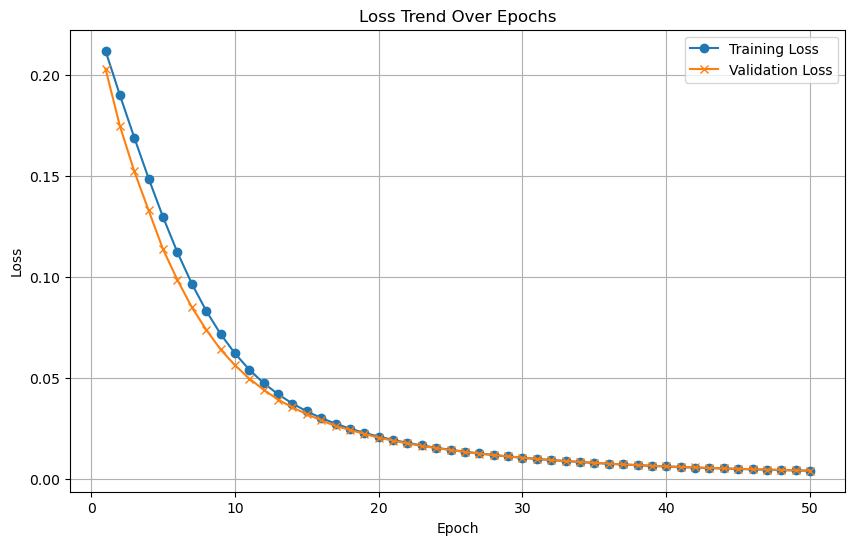

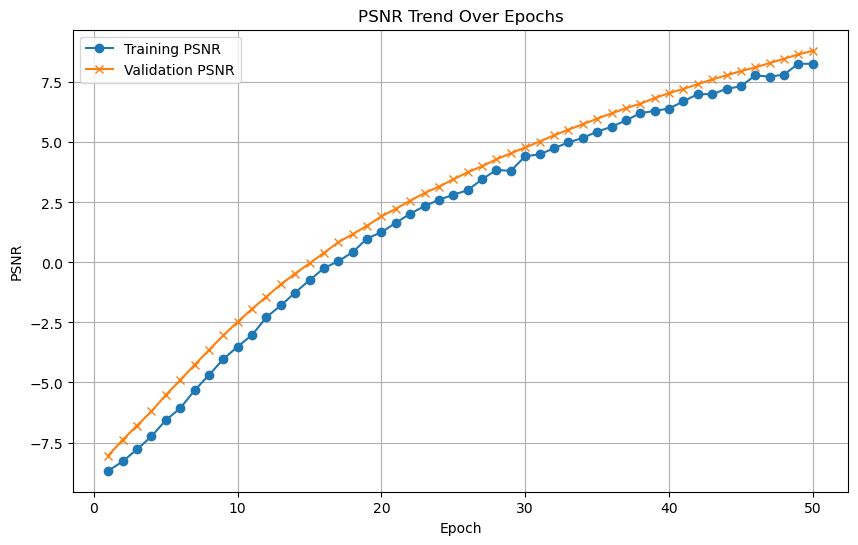

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/13 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6506
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6444. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6194
    Validation Batch [1/1], Loss: 2.6443
Validation Loss: 2.6443, Validation Accuracy: 7.14%
Validation loss improved from 2.6444 to 2.6443. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5642
    Validation Batch [1/1], Loss: 2.6443
Validation Loss: 2.6443, Validation Accuracy: 7.14%
Validation loss improved from 2.6443 to 2.6443. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5479
    Validation Batch [1/1], Loss: 2.6443
Validation Loss: 2.6443, Validation Accuracy: 7.14%
Validation loss improved from 2.6443 to 2.6443. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

Epoch [21/1000] completed, Average Training Loss: 2.3160
    Validation Batch [1/1], Loss: 2.6433
Validation Loss: 2.6433, Validation Accuracy: 7.14%
Validation loss improved from 2.6435 to 2.6433. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.3319
    Validation Batch [1/1], Loss: 2.6432
Validation Loss: 2.6432, Validation Accuracy: 7.14%
Validation loss improved from 2.6433 to 2.6432. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.3109
    Validation Batch [1/1], Loss: 2.6431
Validation Loss: 2.6431, Validation Accuracy: 7.14%
Validation loss improved from 2.6432 to 2.6431. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.3181
    Validation Batch [1/1], Loss: 2.6430
Validation Loss: 2.6430, Validation Accuracy: 7.14%
Validation loss improved from 2.6431 to 2.6430. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/10

Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.2134
    Validation Batch [1/1], Loss: 2.6430
Validation Loss: 2.6430, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.2067
    Validation Batch [1/1], Loss: 2.6430
Validation Loss: 2.6430, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.1737
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6428. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.2062
    Validation Batch [1/1], Loss: 2.6425
Validation Loss: 2.6425, Validation Accuracy: 7.14%
Valid

Epoch [50/1000] completed, Average Training Loss: 2.0349
    Validation Batch [1/1], Loss: 2.6230
Validation Loss: 2.6230, Validation Accuracy: 11.43%
Validation loss improved from 2.6261 to 2.6230. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.0148
    Validation Batch [1/1], Loss: 2.6194
Validation Loss: 2.6194, Validation Accuracy: 11.43%
Validation loss improved from 2.6230 to 2.6194. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.0077
    Validation Batch [1/1], Loss: 2.6158
Validation Loss: 2.6158, Validation Accuracy: 12.86%
Validation loss improved from 2.6194 to 2.6158. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.0233
    Validation Batch [1/1], Loss: 2.6122
Validation Loss: 2.6122, Validation Accuracy: 12.86%
Validation loss improved from 2.6158 to 2.6122. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [5

Epoch [63/1000] completed, Average Training Loss: 1.9400
    Validation Batch [1/1], Loss: 2.5487
Validation Loss: 2.5487, Validation Accuracy: 22.86%
Validation loss improved from 2.5587 to 2.5487. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.8889
    Validation Batch [1/1], Loss: 2.5362
Validation Loss: 2.5362, Validation Accuracy: 27.14%
Validation loss improved from 2.5487 to 2.5362. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.9083
    Validation Batch [1/1], Loss: 2.5248
Validation Loss: 2.5248, Validation Accuracy: 32.86%
Validation loss improved from 2.5362 to 2.5248. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.9057
    Validation Batch [1/1], Loss: 2.5122
Validation Loss: 2.5122, Validation Accuracy: 34.29%
Validation loss improved from 2.5248 to 2.5122. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.2665
Validation Loss: 2.2665, Validation Accuracy: 65.71%
Validation loss improved from 2.2839 to 2.2665. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.7337
    Validation Batch [1/1], Loss: 2.2503
Validation Loss: 2.2503, Validation Accuracy: 64.29%
Validation loss improved from 2.2665 to 2.2503. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.7501
    Validation Batch [1/1], Loss: 2.2301
Validation Loss: 2.2301, Validation Accuracy: 62.86%
Validation loss improved from 2.2503 to 2.2301. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.7192
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 62.86%
Validation loss improved from 2.2301 to 2.2015. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.7560
    Vali

Epoch [95/1000] completed, Average Training Loss: 1.6046
    Validation Batch [1/1], Loss: 1.9464
Validation Loss: 1.9464, Validation Accuracy: 70.00%
Validation loss improved from 1.9576 to 1.9464. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.6167
    Validation Batch [1/1], Loss: 1.9442
Validation Loss: 1.9442, Validation Accuracy: 70.00%
Validation loss improved from 1.9464 to 1.9442. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.5821
    Validation Batch [1/1], Loss: 1.9375
Validation Loss: 1.9375, Validation Accuracy: 74.29%
Validation loss improved from 1.9442 to 1.9375. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.6491
    Validation Batch [1/1], Loss: 1.9260
Validation Loss: 1.9260, Validation Accuracy: 74.29%
Validation loss improved from 1.9375 to 1.9260. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [9

Epoch [107/1000] completed, Average Training Loss: 1.5508
    Validation Batch [1/1], Loss: 1.8201
Validation Loss: 1.8201, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.5087
    Validation Batch [1/1], Loss: 1.8047
Validation Loss: 1.8047, Validation Accuracy: 67.14%
Validation loss improved from 1.8109 to 1.8047. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.4967
    Validation Batch [1/1], Loss: 1.7793
Validation Loss: 1.7793, Validation Accuracy: 68.57%
Validation loss improved from 1.8047 to 1.7793. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.5277
    Validation Batch [1/1], Loss: 1.7724
Validation Loss: 1.7724, Validation Accuracy: 70.00%
Validation loss improved from 1.7793 to 1.7724. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000

Epoch [126/1000] completed, Average Training Loss: 1.3144
    Validation Batch [1/1], Loss: 1.6615
Validation Loss: 1.6615, Validation Accuracy: 72.86%
Validation loss improved from 1.6747 to 1.6615. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.3405
    Validation Batch [1/1], Loss: 1.6581
Validation Loss: 1.6581, Validation Accuracy: 75.71%
Validation loss improved from 1.6615 to 1.6581. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.3837
    Validation Batch [1/1], Loss: 1.6653
Validation Loss: 1.6653, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.3424
    Validation Batch [1/1], Loss: 1.6540
Validation Loss: 1.6540, Validation Accuracy: 77.14%
Validation loss improved from 1.6581 to 1.6540. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000

Epoch [137/1000] completed, Average Training Loss: 1.2672
    Validation Batch [1/1], Loss: 1.6074
Validation Loss: 1.6074, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.2669
    Validation Batch [1/1], Loss: 1.5917
Validation Loss: 1.5917, Validation Accuracy: 75.71%
Validation loss improved from 1.6045 to 1.5917. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.2589
    Validation Batch [1/1], Loss: 1.5649
Validation Loss: 1.5649, Validation Accuracy: 77.14%
Validation loss improved from 1.5917 to 1.5649. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.2718
    Validation Batch [1/1], Loss: 1.5614
Validation Loss: 1.5614, Validation Accuracy: 75.71%
Validation loss improved from 1.5649 to 1.5614. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000

    Validation Batch [1/1], Loss: 1.4593
Validation Loss: 1.4593, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.1356
    Validation Batch [1/1], Loss: 1.4735
Validation Loss: 1.4735, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.1328
    Validation Batch [1/1], Loss: 1.4678
Validation Loss: 1.4678, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.1477
    Validation Batch [1/1], Loss: 1.4400
Validation Loss: 1.4400, Validation Accuracy: 78.57%
Validation loss improved from 1.4533 to 1.4400. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 1.1028
    Validation Batch [1/1], Loss: 1.4231
Vali

Epoch [165/1000] completed, Average Training Loss: 1.1695
    Validation Batch [1/1], Loss: 1.4359
Validation Loss: 1.4359, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.0727
    Validation Batch [1/1], Loss: 1.4083
Validation Loss: 1.4083, Validation Accuracy: 80.00%
Validation loss improved from 1.4115 to 1.4083. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.0593
    Validation Batch [1/1], Loss: 1.3849
Validation Loss: 1.3849, Validation Accuracy: 78.57%
Validation loss improved from 1.4083 to 1.3849. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.0555
    Validation Batch [1/1], Loss: 1.3736
Validation Loss: 1.3736, Validation Accuracy: 78.57%
Validation loss improved from 1.3849 to 1.3736. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000

    Validation Batch [1/1], Loss: 1.3171
Validation Loss: 1.3171, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.8920
    Validation Batch [1/1], Loss: 1.3210
Validation Loss: 1.3210, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.9538
    Validation Batch [1/1], Loss: 1.2884
Validation Loss: 1.2884, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.8151
    Validation Batch [1/1], Loss: 1.2683
Validation Loss: 1.2683, Validation Accuracy: 82.86%
Validation loss improved from 1.2791 to 1.2683. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.9515
    Validation Batch [1/1], Loss: 1.2543
Vali

Epoch [196/1000] completed, Average Training Loss: 0.8446
    Validation Batch [1/1], Loss: 1.2207
Validation Loss: 1.2207, Validation Accuracy: 80.00%
Validation loss improved from 1.2241 to 1.2207. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.8615
    Validation Batch [1/1], Loss: 1.2128
Validation Loss: 1.2128, Validation Accuracy: 82.86%
Validation loss improved from 1.2207 to 1.2128. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.8695
    Validation Batch [1/1], Loss: 1.2210
Validation Loss: 1.2210, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.8470
    Validation Batch [1/1], Loss: 1.2146
Validation Loss: 1.2146, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Av

Epoch [214/1000] completed, Average Training Loss: 0.7525
    Validation Batch [1/1], Loss: 1.1161
Validation Loss: 1.1161, Validation Accuracy: 78.57%
Validation loss improved from 1.1200 to 1.1161. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.6988
    Validation Batch [1/1], Loss: 1.1146
Validation Loss: 1.1146, Validation Accuracy: 80.00%
Validation loss improved from 1.1161 to 1.1146. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.7066
    Validation Batch [1/1], Loss: 1.1144
Validation Loss: 1.1144, Validation Accuracy: 81.43%
Validation loss improved from 1.1146 to 1.1144. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.7682
    Validation Batch [1/1], Loss: 1.1045
Validation Loss: 1.1045, Validation Accuracy: 80.00%
Validation loss improved from 1.1144 to 1.1045. Saving model...

LOG: Epoch [218/1000] - Training


    Validation Batch [1/1], Loss: 1.0687
Validation Loss: 1.0687, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.7200
    Validation Batch [1/1], Loss: 1.0608
Validation Loss: 1.0608, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.7333
    Validation Batch [1/1], Loss: 1.0683
Validation Loss: 1.0683, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.6473
    Validation Batch [1/1], Loss: 1.0597
Validation Loss: 1.0597, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.6904
    Validation Batch [1/1], Loss: 1.0387
Validation Loss: 1.

Epoch [245/1000] completed, Average Training Loss: 0.6016
    Validation Batch [1/1], Loss: 1.0237
Validation Loss: 1.0237, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.6231
    Validation Batch [1/1], Loss: 0.9971
Validation Loss: 0.9971, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.5556
    Validation Batch [1/1], Loss: 0.9746
Validation Loss: 0.9746, Validation Accuracy: 81.43%
Validation loss improved from 0.9818 to 0.9746. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.6203
    Validation Batch [1/1], Loss: 0.9443
Validation Loss: 0.9443, Validation Accuracy: 82.86%
Validation loss improved from 0.9746 to 0.9443. Saving model...

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Av

Epoch [258/1000] completed, Average Training Loss: 0.5427
    Validation Batch [1/1], Loss: 0.9104
Validation Loss: 0.9104, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.4787
    Validation Batch [1/1], Loss: 0.9088
Validation Loss: 0.9088, Validation Accuracy: 81.43%
Validation loss improved from 0.9092 to 0.9088. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5691
    Validation Batch [1/1], Loss: 0.9082
Validation Loss: 0.9082, Validation Accuracy: 80.00%
Validation loss improved from 0.9088 to 0.9082. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.5255
    Validation Batch [1/1], Loss: 0.9096
Validation Loss: 0.9096, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Av

Epoch [275/1000] completed, Average Training Loss: 0.5073
    Validation Batch [1/1], Loss: 0.8567
Validation Loss: 0.8567, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.4230
    Validation Batch [1/1], Loss: 0.8558
Validation Loss: 0.8558, Validation Accuracy: 81.43%
Validation loss improved from 0.8566 to 0.8558. Saving model...

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.4798
    Validation Batch [1/1], Loss: 0.8412
Validation Loss: 0.8412, Validation Accuracy: 81.43%
Validation loss improved from 0.8558 to 0.8412. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.4355
    Validation Batch [1/1], Loss: 0.8347
Validation Loss: 0.8347, Validation Accuracy: 82.86%
Validation loss improved from 0.8412 to 0.8347. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000

Epoch [288/1000] completed, Average Training Loss: 0.4424
    Validation Batch [1/1], Loss: 0.7939
Validation Loss: 0.7939, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.3786
    Validation Batch [1/1], Loss: 0.7971
Validation Loss: 0.7971, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.3801
    Validation Batch [1/1], Loss: 0.8064
Validation Loss: 0.8064, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4337
    Validation Batch [1/1], Loss: 0.8139
Validation Loss: 0.8139, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.3578
  

Epoch [307/1000] completed, Average Training Loss: 0.3369
    Validation Batch [1/1], Loss: 0.7486
Validation Loss: 0.7486, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.2604
    Validation Batch [1/1], Loss: 0.7205
Validation Loss: 0.7205, Validation Accuracy: 85.71%
Validation loss improved from 0.7471 to 0.7205. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.3535
    Validation Batch [1/1], Loss: 0.7148
Validation Loss: 0.7148, Validation Accuracy: 84.29%
Validation loss improved from 0.7205 to 0.7148. Saving model...

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.3382
    Validation Batch [1/1], Loss: 0.7421
Validation Loss: 0.7421, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Av

Epoch [320/1000] completed, Average Training Loss: 0.2961
    Validation Batch [1/1], Loss: 0.7486
Validation Loss: 0.7486, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.2987
    Validation Batch [1/1], Loss: 0.7346
Validation Loss: 0.7346, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2845
    Validation Batch [1/1], Loss: 0.7342
Validation Loss: 0.7342, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3141
    Validation Batch [1/1], Loss: 0.7350
Validation Loss: 0.7350, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.329

Epoch [338/1000] completed, Average Training Loss: 0.2297
    Validation Batch [1/1], Loss: 0.6756
Validation Loss: 0.6756, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2304
    Validation Batch [1/1], Loss: 0.6533
Validation Loss: 0.6533, Validation Accuracy: 85.71%
Validation loss improved from 0.6595 to 0.6533. Saving model...

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2164
    Validation Batch [1/1], Loss: 0.6478
Validation Loss: 0.6478, Validation Accuracy: 85.71%
Validation loss improved from 0.6533 to 0.6478. Saving model...

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2470
    Validation Batch [1/1], Loss: 0.6434
Validation Loss: 0.6434, Validation Accuracy: 87.14%
Validation loss improved from 0.6478 to 0.6434. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/100

    Validation Batch [1/1], Loss: 0.6590
Validation Loss: 0.6590, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2405
    Validation Batch [1/1], Loss: 0.6259
Validation Loss: 0.6259, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2248
    Validation Batch [1/1], Loss: 0.6225
Validation Loss: 0.6225, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.1771
    Validation Batch [1/1], Loss: 0.6479
Validation Loss: 0.6479, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2228
    Validation Batch [1/1], Loss: 0.6698
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.6536
Validation Loss: 0.6536, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1790
    Validation Batch [1/1], Loss: 0.6249
Validation Loss: 0.6249, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2151
    Validation Batch [1/1], Loss: 0.6027
Validation Loss: 0.6027, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2162
    Validation Batch [1/1], Loss: 0.5956
Validation Loss: 0.5956, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.1843
    Validation Batch [1/1], Loss: 0.5942
Validation Loss: 0.

Epoch [380/1000] completed, Average Training Loss: 0.2082
    Validation Batch [1/1], Loss: 0.6078
Validation Loss: 0.6078, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.1689
    Validation Batch [1/1], Loss: 0.6200
Validation Loss: 0.6200, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2070
    Validation Batch [1/1], Loss: 0.6156
Validation Loss: 0.6156, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2033
    Validation Batch [1/1], Loss: 0.5926
Validation Loss: 0.5926, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.2416
  

Epoch [398/1000] completed, Average Training Loss: 0.1772
    Validation Batch [1/1], Loss: 0.5702
Validation Loss: 0.5702, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1578
    Validation Batch [1/1], Loss: 0.5789
Validation Loss: 0.5789, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1356
    Validation Batch [1/1], Loss: 0.5846
Validation Loss: 0.5846, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1546
    Validation Batch [1/1], Loss: 0.5876
Validation Loss: 0.5876, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1207
  

Epoch [411/1000] completed, Average Training Loss: 0.1850
    Validation Batch [1/1], Loss: 0.5731
Validation Loss: 0.5731, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1295
    Validation Batch [1/1], Loss: 0.5621
Validation Loss: 0.5621, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1296
    Validation Batch [1/1], Loss: 0.5755
Validation Loss: 0.5755, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1642
    Validation Batch [1/1], Loss: 0.5976
Validation Loss: 0.5976, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.096

    Validation Batch [1/1], Loss: 0.5094
Validation Loss: 0.5094, Validation Accuracy: 87.14%
Validation loss improved from 0.5201 to 0.5094. Saving model...

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 0.5195
Validation Loss: 0.5195, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1590
    Validation Batch [1/1], Loss: 0.5212
Validation Loss: 0.5212, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1067
    Validation Batch [1/1], Loss: 0.5109
Validation Loss: 0.5109, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1200
    Validation Batch [1/1], Loss: 0.5129
Vali

Epoch [441/1000] completed, Average Training Loss: 0.1397
    Validation Batch [1/1], Loss: 0.5294
Validation Loss: 0.5294, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1406
    Validation Batch [1/1], Loss: 0.5373
Validation Loss: 0.5373, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1165
    Validation Batch [1/1], Loss: 0.5463
Validation Loss: 0.5463, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1238
    Validation Batch [1/1], Loss: 0.5508
Validation Loss: 0.5508, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.141

    Validation Batch [1/1], Loss: 0.5317
Validation Loss: 0.5317, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0978
    Validation Batch [1/1], Loss: 0.5261
Validation Loss: 0.5261, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0976
    Validation Batch [1/1], Loss: 0.5173
Validation Loss: 0.5173, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1233
    Validation Batch [1/1], Loss: 0.5144
Validation Loss: 0.5144, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 0.5113
Validation Loss

    Validation Batch [1/1], Loss: 0.5027
Validation Loss: 0.5027, Validation Accuracy: 84.29%
Validation loss improved from 0.5066 to 0.5027. Saving model...

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.5129
Validation Loss: 0.5129, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0792
    Validation Batch [1/1], Loss: 0.5184
Validation Loss: 0.5184, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1030
    Validation Batch [1/1], Loss: 0.5122
Validation Loss: 0.5122, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0828
    Validation Batch [1/1], Loss: 0.4994
Vali

Epoch [489/1000] completed, Average Training Loss: 0.0866
    Validation Batch [1/1], Loss: 0.5021
Validation Loss: 0.5021, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0952
    Validation Batch [1/1], Loss: 0.4996
Validation Loss: 0.4996, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0771
    Validation Batch [1/1], Loss: 0.5050
Validation Loss: 0.5050, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1211
    Validation Batch [1/1], Loss: 0.5201
Validation Loss: 0.5201, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0844
  

    Validation Batch [1/1], Loss: 0.5116
Validation Loss: 0.5116, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0794
    Validation Batch [1/1], Loss: 0.5251
Validation Loss: 0.5251, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0740
    Validation Batch [1/1], Loss: 0.5448
Validation Loss: 0.5448, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0949
    Validation Batch [1/1], Loss: 0.5549
Validation Loss: 0.5549, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.5397
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.4891
Validation Loss: 0.4891, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0701
    Validation Batch [1/1], Loss: 0.4902
Validation Loss: 0.4902, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0893
    Validation Batch [1/1], Loss: 0.4960
Validation Loss: 0.4960, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0665
    Validation Batch [1/1], Loss: 0.5226
Validation Loss: 0.5226, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.5609
Validation Loss

    Validation Batch [1/1], Loss: 0.5299
Validation Loss: 0.5299, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.5155
Validation Loss: 0.5155, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0861
    Validation Batch [1/1], Loss: 0.5001
Validation Loss: 0.5001, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.0925
    Validation Batch [1/1], Loss: 0.4924
Validation Loss: 0.4924, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.4874
Validation Loss: 0.

Epoch [549/1000] completed, Average Training Loss: 0.0870
    Validation Batch [1/1], Loss: 0.4899
Validation Loss: 0.4899, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0589
    Validation Batch [1/1], Loss: 0.4866
Validation Loss: 0.4866, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0684
    Validation Batch [1/1], Loss: 0.4951
Validation Loss: 0.4951, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0802
    Validation Batch [1/1], Loss: 0.4880
Validation Loss: 0.4880, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.074

Epoch [566/1000] completed, Average Training Loss: 0.0617
    Validation Batch [1/1], Loss: 0.5077
Validation Loss: 0.5077, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0606
    Validation Batch [1/1], Loss: 0.5699
Validation Loss: 0.5699, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0710
    Validation Batch [1/1], Loss: 0.5495
Validation Loss: 0.5495, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.4968
Validation Loss: 0.4968, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.055

Epoch [582/1000] completed, Average Training Loss: 0.0716
    Validation Batch [1/1], Loss: 0.5158
Validation Loss: 0.5158, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.5179
Validation Loss: 0.5179, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0680
    Validation Batch [1/1], Loss: 0.4970
Validation Loss: 0.4970, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0732
    Validation Batch [1/1], Loss: 0.4801
Validation Loss: 0.4801, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.055

Epoch [598/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.4659
Validation Loss: 0.4659, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0591
    Validation Batch [1/1], Loss: 0.4667
Validation Loss: 0.4667, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0488
    Validation Batch [1/1], Loss: 0.4552
Validation Loss: 0.4552, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0524
    Validation Batch [1/1], Loss: 0.4403
Validation Loss: 0.4403, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0819


Epoch [611/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.5090
Validation Loss: 0.5090, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.5402
Validation Loss: 0.5402, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.5428
Validation Loss: 0.5428, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0487
    Validation Batch [1/1], Loss: 0.5295
Validation Loss: 0.5295, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.044

Epoch [628/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.4561
Validation Loss: 0.4561, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0287
    Validation Batch [1/1], Loss: 0.4516
Validation Loss: 0.4516, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.4471
Validation Loss: 0.4471, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.4541
Validation Loss: 0.4541, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.050

Epoch [640/1000] completed, Average Training Loss: 0.0511
    Validation Batch [1/1], Loss: 0.4727
Validation Loss: 0.4727, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0460
    Validation Batch [1/1], Loss: 0.4587
Validation Loss: 0.4587, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.4584
Validation Loss: 0.4584, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0469
    Validation Batch [1/1], Loss: 0.4581
Validation Loss: 0.4581, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.034

Epoch [655/1000] completed, Average Training Loss: 0.0418
    Validation Batch [1/1], Loss: 0.4936
Validation Loss: 0.4936, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0354
    Validation Batch [1/1], Loss: 0.5022
Validation Loss: 0.5022, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.4882
Validation Loss: 0.4882, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0303
    Validation Batch [1/1], Loss: 0.4620
Validation Loss: 0.4620, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.040

Epoch [667/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.4437
Validation Loss: 0.4437, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0568
    Validation Batch [1/1], Loss: 0.4351
Validation Loss: 0.4351, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.4495
Validation Loss: 0.4495, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.4684
Validation Loss: 0.4684, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0369
  

Epoch [685/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.4187
Validation Loss: 0.4187, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.4319
Validation Loss: 0.4319, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.4408
Validation Loss: 0.4408, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0425
    Validation Batch [1/1], Loss: 0.4438
Validation Loss: 0.4438, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.031

Epoch [699/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.4534
Validation Loss: 0.4534, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [700/1000] - Training
Epoch [700/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.4478
Validation Loss: 0.4478, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.4443
Validation Loss: 0.4443, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.4420
Validation Loss: 0.4420, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [703/1000] - Training
Epoch [703/1000] completed, Average Training Loss: 0.037

Epoch [714/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.4331
Validation Loss: 0.4331, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0317
    Validation Batch [1/1], Loss: 0.4369
Validation Loss: 0.4369, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.4423
Validation Loss: 0.4423, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.4528
Validation Loss: 0.4528, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0546
  

Epoch [730/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.4794
Validation Loss: 0.4794, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.4683
Validation Loss: 0.4683, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.4629
Validation Loss: 0.4629, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [733/1000] - Training
Epoch [733/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.4504
Validation Loss: 0.4504, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [734/1000] - Training
Epoch [734/1000] completed, Average Training Loss: 0.031

    Validation Batch [1/1], Loss: 0.4215
Validation Loss: 0.4215, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0449
    Validation Batch [1/1], Loss: 0.4271
Validation Loss: 0.4271, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.4284
Validation Loss: 0.4284, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.4295
Validation Loss: 0.4295, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.4249
Validation Loss: 0.

Epoch [758/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.4412
Validation Loss: 0.4412, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.4427
Validation Loss: 0.4427, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.0277
    Validation Batch [1/1], Loss: 0.4360
Validation Loss: 0.4360, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [761/1000] - Training
Epoch [761/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.4310
Validation Loss: 0.4310, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.037

Epoch [772/1000] completed, Average Training Loss: 0.0369
    Validation Batch [1/1], Loss: 0.4657
Validation Loss: 0.4657, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [773/1000] - Training
Epoch [773/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.4575
Validation Loss: 0.4575, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [774/1000] - Training
Epoch [774/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.4476
Validation Loss: 0.4476, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [775/1000] - Training
Epoch [775/1000] completed, Average Training Loss: 0.0556
    Validation Batch [1/1], Loss: 0.4433
Validation Loss: 0.4433, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [776/1000] - Training
Epoch [776/1000] completed, Average Training Loss: 0.039

    Validation Batch [1/1], Loss: 0.5110
Validation Loss: 0.5110, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [787/1000] - Training
Epoch [787/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.4751
Validation Loss: 0.4751, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [788/1000] - Training
Epoch [788/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.4247
Validation Loss: 0.4247, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [789/1000] - Training
Epoch [789/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.4072
Validation Loss: 0.4072, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [790/1000] - Training
Epoch [790/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.4036
Validation Loss

Epoch [801/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.4173
Validation Loss: 0.4173, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [802/1000] - Training
Epoch [802/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.4279
Validation Loss: 0.4279, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [803/1000] - Training
Epoch [803/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.4471
Validation Loss: 0.4471, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.0315
    Validation Batch [1/1], Loss: 0.4465
Validation Loss: 0.4465, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [805/1000] - Training
Epoch [805/1000] completed, Average Training Loss: 0.049

Epoch [816/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.3859
Validation Loss: 0.3859, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [817/1000] - Training
Epoch [817/1000] completed, Average Training Loss: 0.0295
    Validation Batch [1/1], Loss: 0.4027
Validation Loss: 0.4027, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [818/1000] - Training
Epoch [818/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.4395
Validation Loss: 0.4395, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [819/1000] - Training
Epoch [819/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.4553
Validation Loss: 0.4553, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [820/1000] - Training
Epoch [820/1000] completed, Average Training Loss: 0.0270
  

Epoch [828/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.4119
Validation Loss: 0.4119, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [829/1000] - Training
Epoch [829/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.4283
Validation Loss: 0.4283, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [830/1000] - Training
Epoch [830/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.4547
Validation Loss: 0.4547, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [831/1000] - Training
Epoch [831/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.4849
Validation Loss: 0.4849, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [832/1000] - Training
Epoch [832/1000] completed, Average Training Loss: 0.026

Epoch [846/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.4035
Validation Loss: 0.4035, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [847/1000] - Training
Epoch [847/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.4071
Validation Loss: 0.4071, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [848/1000] - Training
Epoch [848/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.4150
Validation Loss: 0.4150, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [849/1000] - Training
Epoch [849/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.4266
Validation Loss: 0.4266, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [850/1000] - Training
Epoch [850/1000] completed, Average Training Loss: 0.024

Epoch [859/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.4200
Validation Loss: 0.4200, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [860/1000] - Training
Epoch [860/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.4050
Validation Loss: 0.4050, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [861/1000] - Training
Epoch [861/1000] completed, Average Training Loss: 0.0189
    Validation Batch [1/1], Loss: 0.3935
Validation Loss: 0.3935, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [862/1000] - Training
Epoch [862/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.3874
Validation Loss: 0.3874, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [863/1000] - Training
Epoch [863/1000] completed, Average Training Loss: 0.027

Epoch [879/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.4351
Validation Loss: 0.4351, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [880/1000] - Training
Epoch [880/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.4212
Validation Loss: 0.4212, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [881/1000] - Training
Epoch [881/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.4000
Validation Loss: 0.4000, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [882/1000] - Training
Epoch [882/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.3940
Validation Loss: 0.3940, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [883/1000] - Training
Epoch [883/1000] completed, Average Training Loss: 0.026

Epoch [890/1000] completed, Average Training Loss: 0.0181
    Validation Batch [1/1], Loss: 0.5149
Validation Loss: 0.5149, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [891/1000] - Training
Epoch [891/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.4878
Validation Loss: 0.4878, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [892/1000] - Training
Epoch [892/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.4582
Validation Loss: 0.4582, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [893/1000] - Training
Epoch [893/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.4400
Validation Loss: 0.4400, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [894/1000] - Training
Epoch [894/1000] completed, Average Training Loss: 0.023

Epoch [911/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.4443
Validation Loss: 0.4443, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [912/1000] - Training
Epoch [912/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.4568
Validation Loss: 0.4568, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [913/1000] - Training
Epoch [913/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.4615
Validation Loss: 0.4615, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 913. No improvement for 100 epochs.
Loading the best model weights...


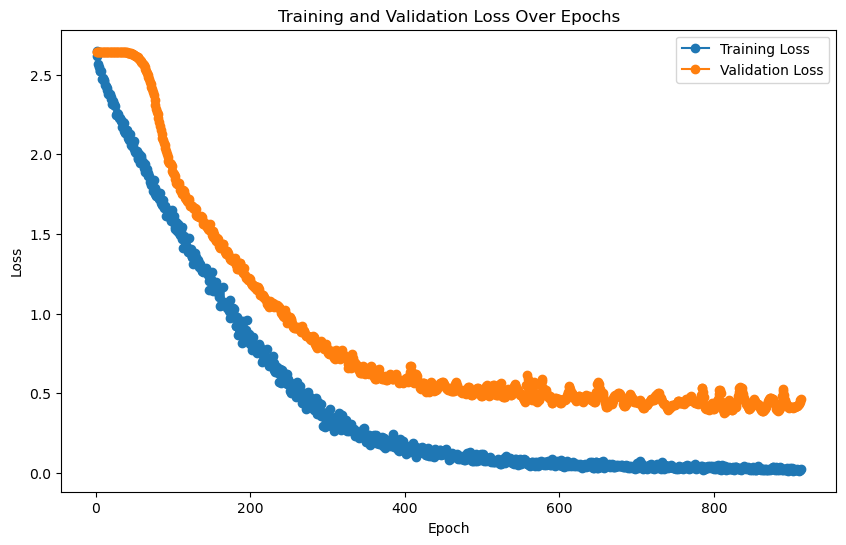

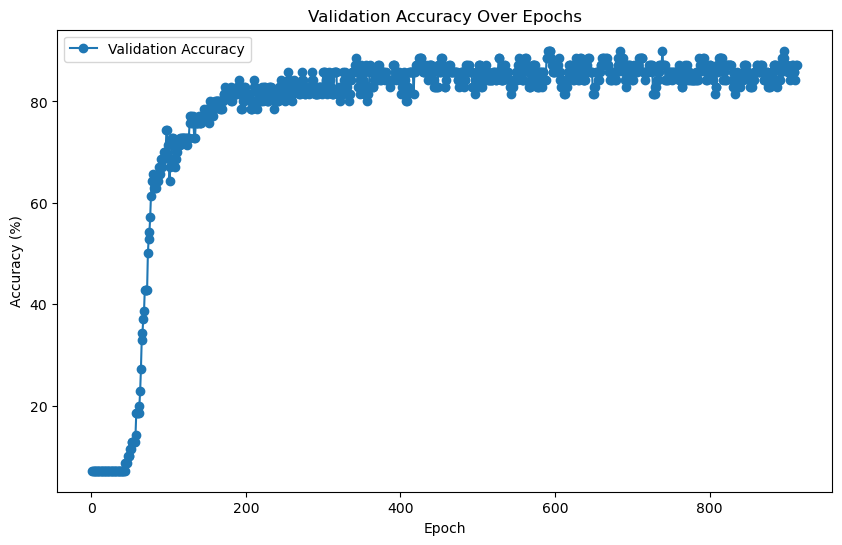


Evaluating on the test set...
    Test Batch [1/13], Loss: 0.0927



Final Test Loss: 0.4929, Test Accuracy: 85.88%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)

LOG: Training features shape: (70, 64), Training labels shape: (70,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3108, 64), Test labels shape: (3108,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 67.14%

Validation Classification Report:
               precision    recall  f1-sco

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)
Train reps shape: (70, 64)
Train labels shape: (70,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3108, 64)
Test labels shape: (3108,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7771  |  Val Loss: 2.7193
Validation loss improved from inf to 2.7193.
[Epoch 2/1000] Train Loss: 2.7106  |  Val Loss: 2.6870
Validation loss improved from 2.7193 to 2.6870.
[Epoch 3/1000] Train Loss: 2.6831  |  Val Loss: 2.6656
Validation loss improved from 2.6870 to 2.6656.
[Epoch 4/1000] Train Loss: 2.6596  |  Val Loss: 2.6553
Validation loss improved from 2.6656 to 2.6553.
[Epoch 5/1000] Train Loss: 2.6517  |  Val Loss: 2.6511
Validation loss improved from 2.6553 to 2.6511.
[Epoch 6/1000] Train Loss: 2.6471  |  Val Loss: 2.6498
Validation loss improved from 2.6511 to 2.6498.
[Epoch 7/1000] Train Loss: 2.6461  |  Val Loss: 2.6504
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 8/1000] Train Loss: 2.6484  |  Val Loss: 2.6499
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 9/1000] Train Loss: 2.6471  |  Val Loss: 2.6461
Validation loss improved from 2.6498 to 2.6461.
[Epoch 10/1000] Train Loss: 2.6426  |  Val Loss: 2.6398
Validati

[Epoch 37/1000] Train Loss: 2.5238  |  Val Loss: 2.5267
Validation loss improved from 2.5325 to 2.5267.
[Epoch 38/1000] Train Loss: 2.5174  |  Val Loss: 2.5366
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 2.5258  |  Val Loss: 2.5468
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 2.5365  |  Val Loss: 2.5421
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 41/1000] Train Loss: 2.5313  |  Val Loss: 2.5142
Validation loss improved from 2.5267 to 2.5142.
[Epoch 42/1000] Train Loss: 2.5021  |  Val Loss: 2.4971
Validation loss improved from 2.5142 to 2.4971.
[Epoch 43/1000] Train Loss: 2.4857  |  Val Loss: 2.4979
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 2.4880  |  Val Loss: 2.4908
Validation loss improved from 2.4971 to 2.4908.
[Epoch 45/1000] Train Loss: 2.4788  |  Val Loss: 2.4804
Validation loss improved from 2.4908 to 2.4804.
[Epoch 46/1000] Train Loss: 2.4670  |  V

[Epoch 77/1000] Train Loss: 2.1552  |  Val Loss: 2.1650
Validation loss improved from 2.1816 to 2.1650.
[Epoch 78/1000] Train Loss: 2.1400  |  Val Loss: 2.1570
Validation loss improved from 2.1650 to 2.1570.
[Epoch 79/1000] Train Loss: 2.1295  |  Val Loss: 2.1455
Validation loss improved from 2.1570 to 2.1455.
[Epoch 80/1000] Train Loss: 2.1175  |  Val Loss: 2.1385
Validation loss improved from 2.1455 to 2.1385.
[Epoch 81/1000] Train Loss: 2.1090  |  Val Loss: 2.1271
Validation loss improved from 2.1385 to 2.1271.
[Epoch 82/1000] Train Loss: 2.0963  |  Val Loss: 2.1231
Validation loss improved from 2.1271 to 2.1231.
[Epoch 83/1000] Train Loss: 2.0928  |  Val Loss: 2.1017
Validation loss improved from 2.1231 to 2.1017.
[Epoch 84/1000] Train Loss: 2.0709  |  Val Loss: 2.1116
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 2.0836  |  Val Loss: 2.0837
Validation loss improved from 2.1017 to 2.0837.
[Epoch 86/1000] Train Loss: 2.0554  |  Val Loss: 2.0888
!!

[Epoch 115/1000] Train Loss: 1.7723  |  Val Loss: 1.8497
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.8060  |  Val Loss: 1.7996
Validation loss improved from 1.8109 to 1.7996.
[Epoch 117/1000] Train Loss: 1.7565  |  Val Loss: 1.8164
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 1.7791  |  Val Loss: 1.8040
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 119/1000] Train Loss: 1.7624  |  Val Loss: 1.7824
Validation loss improved from 1.7996 to 1.7824.
[Epoch 120/1000] Train Loss: 1.7437  |  Val Loss: 1.7960
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 1.7484  |  Val Loss: 1.7778
Validation loss improved from 1.7824 to 1.7778.
[Epoch 122/1000] Train Loss: 1.7314  |  Val Loss: 1.8142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 1.7644  |  Val Loss: 1.8060
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Tr

[Epoch 153/1000] Train Loss: 1.5726  |  Val Loss: 1.6661
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 1.6220  |  Val Loss: 1.7186
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 1.6637  |  Val Loss: 1.6355
Validation loss improved from 1.6359 to 1.6355.
[Epoch 156/1000] Train Loss: 1.5905  |  Val Loss: 1.6889
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.6313  |  Val Loss: 1.6145
Validation loss improved from 1.6355 to 1.6145.
[Epoch 158/1000] Train Loss: 1.5612  |  Val Loss: 1.6091
Validation loss improved from 1.6145 to 1.6091.
[Epoch 159/1000] Train Loss: 1.5553  |  Val Loss: 1.5966
Validation loss improved from 1.6091 to 1.5966.
[Epoch 160/1000] Train Loss: 1.5453  |  Val Loss: 1.6074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 1.5463  |  Val Loss: 1.5834
Validation loss improved from 1.5966 to 1.5834.
[Epoch 162/1000] Train Loss: 1.

[Epoch 195/1000] Train Loss: 1.4184  |  Val Loss: 1.4783
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 1.4171  |  Val Loss: 1.4755
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 197/1000] Train Loss: 1.4089  |  Val Loss: 1.4829
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 198/1000] Train Loss: 1.4189  |  Val Loss: 1.4635
Validation loss improved from 1.4747 to 1.4635.
[Epoch 199/1000] Train Loss: 1.4003  |  Val Loss: 1.4608
Validation loss improved from 1.4635 to 1.4608.
[Epoch 200/1000] Train Loss: 1.3879  |  Val Loss: 1.4692
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 1.4008  |  Val Loss: 1.4777
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 1.4082  |  Val Loss: 1.4737
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 1.4000  |  Val Loss: 1.5452
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 204/10

[Epoch 238/1000] Train Loss: 1.3889  |  Val Loss: 1.4283
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 239/1000] Train Loss: 1.3474  |  Val Loss: 1.4271
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 240/1000] Train Loss: 1.3555  |  Val Loss: 1.4178
Validation loss improved from 1.4213 to 1.4178.
[Epoch 241/1000] Train Loss: 1.3436  |  Val Loss: 1.4103
Validation loss improved from 1.4178 to 1.4103.
[Epoch 242/1000] Train Loss: 1.3273  |  Val Loss: 1.4175
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 1.3316  |  Val Loss: 1.4072
Validation loss improved from 1.4103 to 1.4072.
[Epoch 244/1000] Train Loss: 1.3228  |  Val Loss: 1.3907
Validation loss improved from 1.4072 to 1.3907.
[Epoch 245/1000] Train Loss: 1.3095  |  Val Loss: 1.3892
Validation loss improved from 1.3907 to 1.3892.
[Epoch 246/1000] Train Loss: 1.3106  |  Val Loss: 1.3945
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 1.

[Epoch 283/1000] Train Loss: 1.3133  |  Val Loss: 1.4011
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 284/1000] Train Loss: 1.3066  |  Val Loss: 1.3690
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 285/1000] Train Loss: 1.2924  |  Val Loss: 1.4585
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 286/1000] Train Loss: 1.3787  |  Val Loss: 1.3489
Validation loss improved from 1.3665 to 1.3489.
[Epoch 287/1000] Train Loss: 1.2704  |  Val Loss: 1.4279
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 1.3237  |  Val Loss: 1.3735
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 1.2810  |  Val Loss: 1.3554
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 1.2642  |  Val Loss: 1.3739
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 291/1000] Train Loss: 1.2754  |  Val Loss: 1.4149
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 321/1000] Train Loss: 1.3683  |  Val Loss: 1.4079
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 322/1000] Train Loss: 1.3397  |  Val Loss: 1.3373
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 323/1000] Train Loss: 1.2459  |  Val Loss: 1.4499
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 324/1000] Train Loss: 1.3385  |  Val Loss: 1.3608
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 325/1000] Train Loss: 1.2632  |  Val Loss: 1.3647
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 326/1000] Train Loss: 1.2956  |  Val Loss: 1.3497
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 327/1000] Train Loss: 1.2660  |  Val Loss: 1.3689
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 328/1000] Train Loss: 1.2689  |  Val Loss: 1.4405
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 329/1000] Train Loss: 1.3312  |  Val Loss: 1.3779
!! Validation loss did NOT improve !! Patience:

[Epoch 363/1000] Train Loss: 1.2463  |  Val Loss: 1.3458
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 364/1000] Train Loss: 1.2374  |  Val Loss: 1.3426
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 365/1000] Train Loss: 1.2596  |  Val Loss: 1.3748
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 366/1000] Train Loss: 1.2800  |  Val Loss: 1.3471
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 367/1000] Train Loss: 1.2370  |  Val Loss: 1.5440
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 368/1000] Train Loss: 1.4081  |  Val Loss: 1.3950
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 369/1000] Train Loss: 1.2624  |  Val Loss: 1.4055
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 370/1000] Train Loss: 1.3462  |  Val Loss: 1.5159
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 371/1000] Train Loss: 1.4314  |  Val Loss: 1.3349
!! Validation loss did NOT improve !! Patience:

[Epoch 404/1000] Train Loss: 1.2233  |  Val Loss: 1.3848
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 405/1000] Train Loss: 1.2690  |  Val Loss: 1.3156
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 406/1000] Train Loss: 1.2224  |  Val Loss: 1.2993
Validation loss improved from 1.3023 to 1.2993.
[Epoch 407/1000] Train Loss: 1.2040  |  Val Loss: 1.3071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 408/1000] Train Loss: 1.2081  |  Val Loss: 1.3158
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 409/1000] Train Loss: 1.2154  |  Val Loss: 1.3107
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 410/1000] Train Loss: 1.2034  |  Val Loss: 1.3663
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 411/1000] Train Loss: 1.2350  |  Val Loss: 1.3026
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 412/1000] Train Loss: 1.1921  |  Val Loss: 1.3139
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 444/1000] Train Loss: 1.2495  |  Val Loss: 1.3512
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 445/1000] Train Loss: 1.2569  |  Val Loss: 1.5039
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 446/1000] Train Loss: 1.3765  |  Val Loss: 1.2901
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 447/1000] Train Loss: 1.1988  |  Val Loss: 1.5455
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 448/1000] Train Loss: 1.4191  |  Val Loss: 1.4328
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 449/1000] Train Loss: 1.3211  |  Val Loss: 1.3384
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 450/1000] Train Loss: 1.2631  |  Val Loss: 1.4206
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 451/1000] Train Loss: 1.3288  |  Val Loss: 1.3374
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 452/1000] Train Loss: 1.2600  |  Val Loss: 1.4201
!! Validation loss did NOT improve !! Patience:

[Epoch 480/1000] Train Loss: 1.2151  |  Val Loss: 1.3030
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 481/1000] Train Loss: 1.1967  |  Val Loss: 1.3046
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 482/1000] Train Loss: 1.1758  |  Val Loss: 1.3071
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 483/1000] Train Loss: 1.1966  |  Val Loss: 1.4013
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 484/1000] Train Loss: 1.2992  |  Val Loss: 1.3218
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 485/1000] Train Loss: 1.2139  |  Val Loss: 1.3076
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 486/1000] Train Loss: 1.1856  |  Val Loss: 1.3326
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 487/1000] Train Loss: 1.2040  |  Val Loss: 1.3022
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 488/1000] Train Loss: 1.1843  |  Val Loss: 1.3035
!! Validation loss did NOT improve !! Patience:

[Epoch 520/1000] Train Loss: 1.2375  |  Val Loss: 1.3004
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 521/1000] Train Loss: 1.1904  |  Val Loss: 1.3472
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 522/1000] Train Loss: 1.2336  |  Val Loss: 1.3334
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 523/1000] Train Loss: 1.2166  |  Val Loss: 1.3167
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 524/1000] Train Loss: 1.2028  |  Val Loss: 1.4829
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 525/1000] Train Loss: 1.3325  |  Val Loss: 1.3966
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 526/1000] Train Loss: 1.2563  |  Val Loss: 1.2868
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 526 !!
No improvement for 100 epochs.


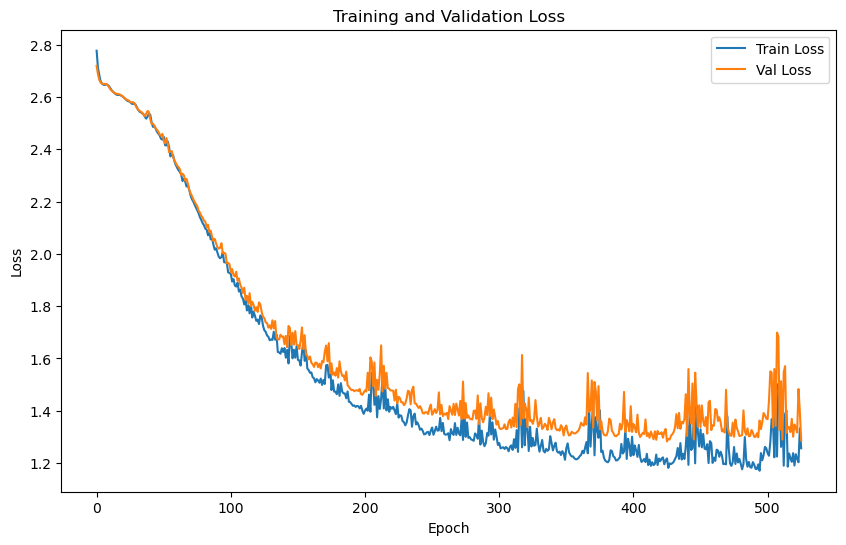

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.3752 | Test Accuracy: 40.25%


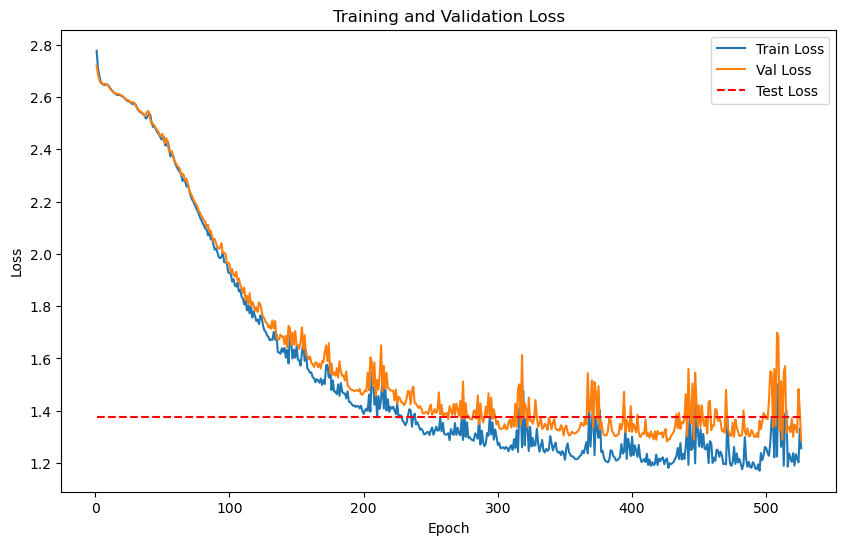

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.5348
Epoch [1/2000], Avg Train Loss: 8.5348
Epoch [1/2000], Avg Val Loss: 3.7228
Validation loss improved from inf to 3.7228. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.0590
Epoch [2/2000], Avg Train Loss: 8.0590
Epoch [2/2000], Avg Val Loss: 3.7006
Validation loss improved from 3.7228 to 3.7006. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4120
Epoch [3/2000], Avg Train Loss: 8.4120
Epoch [3/2000], Avg Val Loss: 3.6792
Validation loss improved from 3.7006 to 3.6792. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4674
Epoch [4/2000], Avg Train Loss: 8.4674
Epoch [4/2000], Avg Val Loss: 3.6586
Validation loss improved from 3.6792 to 3.6586. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2259
Epoch [5/2000], Avg Train Loss: 8.2259
Epoch [5/2000], Avg Val Loss: 3.6384
Validation loss improved from 3.6586 to 3.6384. Saving mode

    Batch [1/1], Train Loss: 6.7916
Epoch [23/2000], Avg Train Loss: 6.7916
Epoch [23/2000], Avg Val Loss: 3.3853
Validation loss improved from 3.3950 to 3.3853. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.0970
Epoch [24/2000], Avg Train Loss: 7.0970
Epoch [24/2000], Avg Val Loss: 3.3762
Validation loss improved from 3.3853 to 3.3762. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7131
Epoch [25/2000], Avg Train Loss: 6.7131
Epoch [25/2000], Avg Val Loss: 3.3674
Validation loss improved from 3.3762 to 3.3674. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.7604
Epoch [26/2000], Avg Train Loss: 6.7604
Epoch [26/2000], Avg Val Loss: 3.3591
Validation loss improved from 3.3674 to 3.3591. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.7331
Epoch [27/2000], Avg Train Loss: 6.7331
Epoch [27/2000], Avg Val Loss: 3.3511
Validation loss improved from 3.3591 to 3.

    Batch [1/1], Train Loss: 6.2779
Epoch [29/2000], Avg Train Loss: 6.2779
Epoch [29/2000], Avg Val Loss: 3.3362
Validation loss improved from 3.3435 to 3.3362. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.3862
Epoch [30/2000], Avg Train Loss: 6.3862
Epoch [30/2000], Avg Val Loss: 3.3292
Validation loss improved from 3.3362 to 3.3292. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.1354
Epoch [31/2000], Avg Train Loss: 6.1354
Epoch [31/2000], Avg Val Loss: 3.3227
Validation loss improved from 3.3292 to 3.3227. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.2481
Epoch [32/2000], Avg Train Loss: 6.2481
Epoch [32/2000], Avg Val Loss: 3.3163
Validation loss improved from 3.3227 to 3.3163. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.2100
Epoch [33/2000], Avg Train Loss: 6.2100
Epoch [33/2000], Avg Val Loss: 3.3102
Validation loss improved from 3.3163 to 3.

    Batch [1/1], Train Loss: 5.5586
Epoch [46/2000], Avg Train Loss: 5.5586
Epoch [46/2000], Avg Val Loss: 3.2558
Validation loss improved from 3.2586 to 3.2558. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.8792
Epoch [47/2000], Avg Train Loss: 5.8792
Epoch [47/2000], Avg Val Loss: 3.2531
Validation loss improved from 3.2558 to 3.2531. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.7730
Epoch [48/2000], Avg Train Loss: 5.7730
Epoch [48/2000], Avg Val Loss: 3.2506
Validation loss improved from 3.2531 to 3.2506. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.4103
Epoch [49/2000], Avg Train Loss: 5.4103
Epoch [49/2000], Avg Val Loss: 3.2483
Validation loss improved from 3.2506 to 3.2483. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.3732
Epoch [50/2000], Avg Train Loss: 5.3732
Epoch [50/2000], Avg Val Loss: 3.2461
Validation loss improved from 3.2483 to 3.

Epoch [66/2000], Avg Val Loss: 3.2275
Validation loss improved from 3.2280 to 3.2275. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 4.9211
Epoch [67/2000], Avg Train Loss: 4.9211
Epoch [67/2000], Avg Val Loss: 3.2271
Validation loss improved from 3.2275 to 3.2271. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.0417
Epoch [68/2000], Avg Train Loss: 5.0417
Epoch [68/2000], Avg Val Loss: 3.2268
Validation loss improved from 3.2271 to 3.2268. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 4.9781
Epoch [69/2000], Avg Train Loss: 4.9781
Epoch [69/2000], Avg Val Loss: 3.2265
Validation loss improved from 3.2268 to 3.2265. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 4.8571
Epoch [70/2000], Avg Train Loss: 4.8571
Epoch [70/2000], Avg Val Loss: 3.2264
Validation loss improved from 3.2265 to 3.2264. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Trai

Epoch [87/2000], Avg Val Loss: 3.2264
Validation loss did not improve. Patience: 10/100

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.5119
Epoch [88/2000], Avg Train Loss: 4.5119
Epoch [88/2000], Avg Val Loss: 3.2266
Validation loss did not improve. Patience: 11/100

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.5927
Epoch [89/2000], Avg Train Loss: 4.5927
Epoch [89/2000], Avg Val Loss: 3.2267
Validation loss did not improve. Patience: 12/100

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.4370
Epoch [90/2000], Avg Train Loss: 4.4370
Epoch [90/2000], Avg Val Loss: 3.2269
Validation loss did not improve. Patience: 13/100

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.5517
Epoch [91/2000], Avg Train Loss: 4.5517
Epoch [91/2000], Avg Val Loss: 3.2270
Validation loss did not improve. Patience: 14/100

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.4660
Epoch [92/2000], Avg Train Loss: 4.4660
Epoch [92/2000]

    Batch [1/1], Train Loss: 4.3823
Epoch [108/2000], Avg Train Loss: 4.3823
Epoch [108/2000], Avg Val Loss: 3.2315
Validation loss did not improve. Patience: 31/100

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.2311
Epoch [109/2000], Avg Train Loss: 4.2311
Epoch [109/2000], Avg Val Loss: 3.2318
Validation loss did not improve. Patience: 32/100

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.3083
Epoch [110/2000], Avg Train Loss: 4.3083
Epoch [110/2000], Avg Val Loss: 3.2321
Validation loss did not improve. Patience: 33/100

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.0718
Epoch [111/2000], Avg Train Loss: 4.0718
Epoch [111/2000], Avg Val Loss: 3.2324
Validation loss did not improve. Patience: 34/100

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.2752
Epoch [112/2000], Avg Train Loss: 4.2752
Epoch [112/2000], Avg Val Loss: 3.2327
Validation loss did not improve. Patience: 35/100

LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 4.0188
Epoch [133/2000], Avg Train Loss: 4.0188
Epoch [133/2000], Avg Val Loss: 3.2378
Validation loss did not improve. Patience: 56/100

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.0090
Epoch [134/2000], Avg Train Loss: 4.0090
Epoch [134/2000], Avg Val Loss: 3.2379
Validation loss did not improve. Patience: 57/100

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.1364
Epoch [135/2000], Avg Train Loss: 4.1364
Epoch [135/2000], Avg Val Loss: 3.2380
Validation loss did not improve. Patience: 58/100

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.0451
Epoch [136/2000], Avg Train Loss: 4.0451
Epoch [136/2000], Avg Val Loss: 3.2381
Validation loss did not improve. Patience: 59/100

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.1131
Epoch [137/2000], Avg Train Loss: 4.1131
Epoch [137/2000], Avg Val Loss: 3.2383
Validation loss did not improve. Patience: 60/100

LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 3.9482
Epoch [157/2000], Avg Train Loss: 3.9482
Epoch [157/2000], Avg Val Loss: 3.2394
Validation loss did not improve. Patience: 80/100

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 3.8385
Epoch [158/2000], Avg Train Loss: 3.8385
Epoch [158/2000], Avg Val Loss: 3.2394
Validation loss did not improve. Patience: 81/100

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 3.8256
Epoch [159/2000], Avg Train Loss: 3.8256
Epoch [159/2000], Avg Val Loss: 3.2394
Validation loss did not improve. Patience: 82/100

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.9319
Epoch [160/2000], Avg Train Loss: 3.9319
Epoch [160/2000], Avg Val Loss: 3.2393
Validation loss did not improve. Patience: 83/100

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.7637
Epoch [161/2000], Avg Train Loss: 3.7637
Epoch [161/2000], Avg Val Loss: 3.2392
Validation loss did not improve. Patience: 84/100

LOG: Epoch [162/2000] - Training


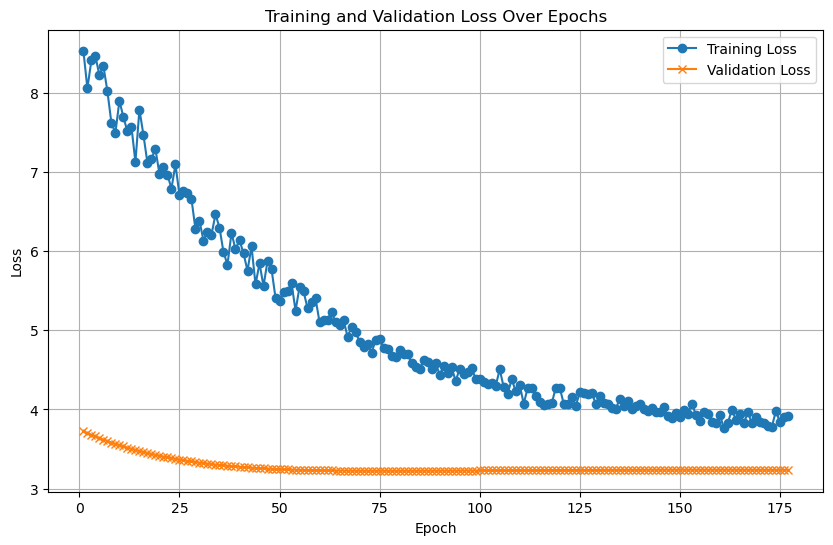

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/13], Loss: 5.9337

Test Loss: 5.2082


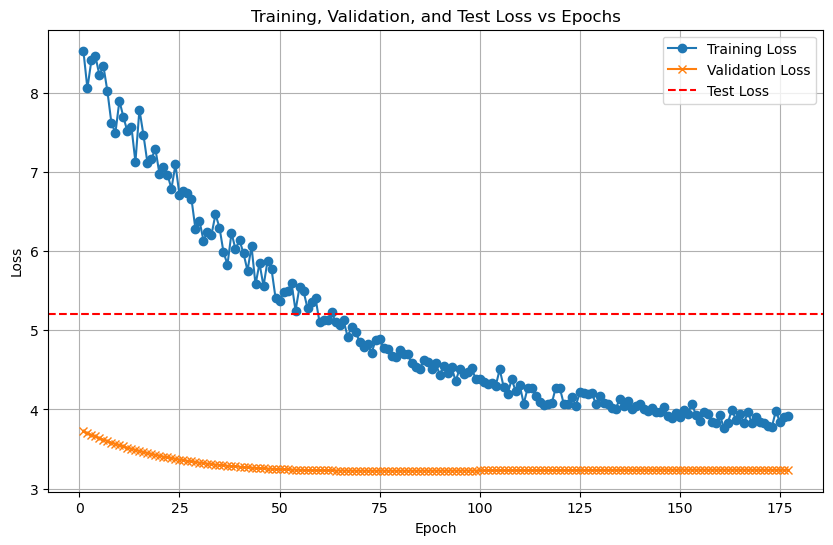

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.60      0.60      0.60         5
           2       0.57      0.80      0.67         5
           3       0.67      0.80      0.73         5
           4       1.00      0.20      0.33         5
           5       0.43      0.60      0.50         5
           6       0.50      0.40      0.44         5
           7       0.33      0.20      0.25         5
           8       0.25      0.20      0.22         5
           9       0.57      0.80      0.67         5
          10       0.80      0.80      0.80         5
          11       0.43      0.60      0.50         5
          12       0.60      0.60      0.60         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5671  |  Val Loss: 2.5584
Validation loss improved from inf to 2.5584.
[Epoch 2/1000] Train Loss: 2.5610  |  Val Loss: 2.5538
Validation loss improved from 2.5584 to 2.5538.
[Epoch 3/1000] Train Loss: 2.5556  |  Val Loss: 2.5498
Validation loss improved from 2.5538 to 2.5498.
[Epoch 4/1000] Train Loss: 2.5515  |  Val Loss: 2.5460
Validation loss improved from 2.5498 to 2.5460.
[Epoch 5/1000] Train Loss: 2.5476  |  Val Loss: 2.5426
Validation loss improved from 2.5460 to 2.5426.
[Epoch 6/1000] Train Loss: 2.5437  |  Val Loss: 2.5393
Validation loss improved from 2.5426 to 2.5393.
[Epoch 7/1000] Train Loss: 2.5403  |  Val Loss: 2.5360
Validation loss improved from 2.5393 to 2.5360.
[Epoch 8/1000] Train Loss: 2.5369  |  Val Loss: 2.5328
Validation loss improved from 2.5360 to 2.5328.
[Epoch 9/1000] Train Loss: 2.5335  |  Val Loss: 2.5296
Validation loss improved from 2.5328 to 2.5296.
[Epoch 10/1000] Train Loss: 2.5303  |  Val Loss: 2.5265
Validation loss impr

[Epoch 24/1000] Train Loss: 2.4907  |  Val Loss: 2.4936
Validation loss improved from 2.4957 to 2.4936.
[Epoch 25/1000] Train Loss: 2.4881  |  Val Loss: 2.4916
Validation loss improved from 2.4936 to 2.4916.
[Epoch 26/1000] Train Loss: 2.4856  |  Val Loss: 2.4895
Validation loss improved from 2.4916 to 2.4895.
[Epoch 27/1000] Train Loss: 2.4830  |  Val Loss: 2.4873
Validation loss improved from 2.4895 to 2.4873.
[Epoch 28/1000] Train Loss: 2.4805  |  Val Loss: 2.4850
Validation loss improved from 2.4873 to 2.4850.
[Epoch 29/1000] Train Loss: 2.4778  |  Val Loss: 2.4828
Validation loss improved from 2.4850 to 2.4828.
[Epoch 30/1000] Train Loss: 2.4754  |  Val Loss: 2.4807
Validation loss improved from 2.4828 to 2.4807.
[Epoch 31/1000] Train Loss: 2.4727  |  Val Loss: 2.4785
Validation loss improved from 2.4807 to 2.4785.
[Epoch 32/1000] Train Loss: 2.4702  |  Val Loss: 2.4762
Validation loss improved from 2.4785 to 2.4762.
[Epoch 33/1000] Train Loss: 2.4676  |  Val Loss: 2.4740
Validati

[Epoch 38/1000] Train Loss: 2.4544  |  Val Loss: 2.4626
Validation loss improved from 2.4648 to 2.4626.
[Epoch 39/1000] Train Loss: 2.4517  |  Val Loss: 2.4604
Validation loss improved from 2.4626 to 2.4604.
[Epoch 40/1000] Train Loss: 2.4493  |  Val Loss: 2.4583
Validation loss improved from 2.4604 to 2.4583.
[Epoch 41/1000] Train Loss: 2.4468  |  Val Loss: 2.4563
Validation loss improved from 2.4583 to 2.4563.
[Epoch 42/1000] Train Loss: 2.4444  |  Val Loss: 2.4542
Validation loss improved from 2.4563 to 2.4542.
[Epoch 43/1000] Train Loss: 2.4421  |  Val Loss: 2.4521
Validation loss improved from 2.4542 to 2.4521.
[Epoch 44/1000] Train Loss: 2.4395  |  Val Loss: 2.4500
Validation loss improved from 2.4521 to 2.4500.
[Epoch 45/1000] Train Loss: 2.4370  |  Val Loss: 2.4480
Validation loss improved from 2.4500 to 2.4480.
[Epoch 46/1000] Train Loss: 2.4345  |  Val Loss: 2.4459
Validation loss improved from 2.4480 to 2.4459.
[Epoch 47/1000] Train Loss: 2.4320  |  Val Loss: 2.4436
Validati

[Epoch 63/1000] Train Loss: 2.3879  |  Val Loss: 2.4081
Validation loss improved from 2.4101 to 2.4081.
[Epoch 64/1000] Train Loss: 2.3854  |  Val Loss: 2.4062
Validation loss improved from 2.4081 to 2.4062.
[Epoch 65/1000] Train Loss: 2.3828  |  Val Loss: 2.4045
Validation loss improved from 2.4062 to 2.4045.
[Epoch 66/1000] Train Loss: 2.3803  |  Val Loss: 2.4028
Validation loss improved from 2.4045 to 2.4028.
[Epoch 67/1000] Train Loss: 2.3781  |  Val Loss: 2.4011
Validation loss improved from 2.4028 to 2.4011.
[Epoch 68/1000] Train Loss: 2.3758  |  Val Loss: 2.3993
Validation loss improved from 2.4011 to 2.3993.
[Epoch 69/1000] Train Loss: 2.3734  |  Val Loss: 2.3976
Validation loss improved from 2.3993 to 2.3976.
[Epoch 70/1000] Train Loss: 2.3712  |  Val Loss: 2.3958
Validation loss improved from 2.3976 to 2.3958.
[Epoch 71/1000] Train Loss: 2.3689  |  Val Loss: 2.3941
Validation loss improved from 2.3958 to 2.3941.
[Epoch 72/1000] Train Loss: 2.3666  |  Val Loss: 2.3923
Validati

[Epoch 75/1000] Train Loss: 2.3596  |  Val Loss: 2.3870
Validation loss improved from 2.3888 to 2.3870.
[Epoch 76/1000] Train Loss: 2.3575  |  Val Loss: 2.3853
Validation loss improved from 2.3870 to 2.3853.
[Epoch 77/1000] Train Loss: 2.3553  |  Val Loss: 2.3837
Validation loss improved from 2.3853 to 2.3837.
[Epoch 78/1000] Train Loss: 2.3532  |  Val Loss: 2.3821
Validation loss improved from 2.3837 to 2.3821.
[Epoch 79/1000] Train Loss: 2.3512  |  Val Loss: 2.3803
Validation loss improved from 2.3821 to 2.3803.
[Epoch 80/1000] Train Loss: 2.3490  |  Val Loss: 2.3785
Validation loss improved from 2.3803 to 2.3785.
[Epoch 81/1000] Train Loss: 2.3465  |  Val Loss: 2.3764
Validation loss improved from 2.3785 to 2.3764.
[Epoch 82/1000] Train Loss: 2.3440  |  Val Loss: 2.3742
Validation loss improved from 2.3764 to 2.3742.
[Epoch 83/1000] Train Loss: 2.3413  |  Val Loss: 2.3718
Validation loss improved from 2.3742 to 2.3718.
[Epoch 84/1000] Train Loss: 2.3388  |  Val Loss: 2.3695
Validati

[Epoch 103/1000] Train Loss: 2.2930  |  Val Loss: 2.3308
Validation loss improved from 2.3331 to 2.3308.
[Epoch 104/1000] Train Loss: 2.2903  |  Val Loss: 2.3287
Validation loss improved from 2.3308 to 2.3287.
[Epoch 105/1000] Train Loss: 2.2876  |  Val Loss: 2.3265
Validation loss improved from 2.3287 to 2.3265.
[Epoch 106/1000] Train Loss: 2.2848  |  Val Loss: 2.3242
Validation loss improved from 2.3265 to 2.3242.
[Epoch 107/1000] Train Loss: 2.2823  |  Val Loss: 2.3219
Validation loss improved from 2.3242 to 2.3219.
[Epoch 108/1000] Train Loss: 2.2794  |  Val Loss: 2.3196
Validation loss improved from 2.3219 to 2.3196.
[Epoch 109/1000] Train Loss: 2.2769  |  Val Loss: 2.3173
Validation loss improved from 2.3196 to 2.3173.
[Epoch 110/1000] Train Loss: 2.2739  |  Val Loss: 2.3150
Validation loss improved from 2.3173 to 2.3150.
[Epoch 111/1000] Train Loss: 2.2711  |  Val Loss: 2.3127
Validation loss improved from 2.3150 to 2.3127.
[Epoch 112/1000] Train Loss: 2.2681  |  Val Loss: 2.310

[Epoch 118/1000] Train Loss: 2.2516  |  Val Loss: 2.2977
Validation loss improved from 2.2999 to 2.2977.
[Epoch 119/1000] Train Loss: 2.2491  |  Val Loss: 2.2955
Validation loss improved from 2.2977 to 2.2955.
[Epoch 120/1000] Train Loss: 2.2466  |  Val Loss: 2.2932
Validation loss improved from 2.2955 to 2.2932.
[Epoch 121/1000] Train Loss: 2.2442  |  Val Loss: 2.2910
Validation loss improved from 2.2932 to 2.2910.
[Epoch 122/1000] Train Loss: 2.2415  |  Val Loss: 2.2888
Validation loss improved from 2.2910 to 2.2888.
[Epoch 123/1000] Train Loss: 2.2389  |  Val Loss: 2.2866
Validation loss improved from 2.2888 to 2.2866.
[Epoch 124/1000] Train Loss: 2.2365  |  Val Loss: 2.2843
Validation loss improved from 2.2866 to 2.2843.
[Epoch 125/1000] Train Loss: 2.2340  |  Val Loss: 2.2821
Validation loss improved from 2.2843 to 2.2821.
[Epoch 126/1000] Train Loss: 2.2315  |  Val Loss: 2.2799
Validation loss improved from 2.2821 to 2.2799.
[Epoch 127/1000] Train Loss: 2.2289  |  Val Loss: 2.277

[Epoch 146/1000] Train Loss: 2.1834  |  Val Loss: 2.2371
Validation loss improved from 2.2396 to 2.2371.
[Epoch 147/1000] Train Loss: 2.1805  |  Val Loss: 2.2347
Validation loss improved from 2.2371 to 2.2347.
[Epoch 148/1000] Train Loss: 2.1777  |  Val Loss: 2.2326
Validation loss improved from 2.2347 to 2.2326.
[Epoch 149/1000] Train Loss: 2.1751  |  Val Loss: 2.2305
Validation loss improved from 2.2326 to 2.2305.
[Epoch 150/1000] Train Loss: 2.1725  |  Val Loss: 2.2285
Validation loss improved from 2.2305 to 2.2285.
[Epoch 151/1000] Train Loss: 2.1702  |  Val Loss: 2.2265
Validation loss improved from 2.2285 to 2.2265.
[Epoch 152/1000] Train Loss: 2.1677  |  Val Loss: 2.2244
Validation loss improved from 2.2265 to 2.2244.
[Epoch 153/1000] Train Loss: 2.1650  |  Val Loss: 2.2222
Validation loss improved from 2.2244 to 2.2222.
[Epoch 154/1000] Train Loss: 2.1622  |  Val Loss: 2.2200
Validation loss improved from 2.2222 to 2.2200.
[Epoch 155/1000] Train Loss: 2.1593  |  Val Loss: 2.217

[Epoch 160/1000] Train Loss: 2.1453  |  Val Loss: 2.2069
Validation loss improved from 2.2090 to 2.2069.
[Epoch 161/1000] Train Loss: 2.1425  |  Val Loss: 2.2047
Validation loss improved from 2.2069 to 2.2047.
[Epoch 162/1000] Train Loss: 2.1397  |  Val Loss: 2.2026
Validation loss improved from 2.2047 to 2.2026.
[Epoch 163/1000] Train Loss: 2.1371  |  Val Loss: 2.2004
Validation loss improved from 2.2026 to 2.2004.
[Epoch 164/1000] Train Loss: 2.1343  |  Val Loss: 2.1981
Validation loss improved from 2.2004 to 2.1981.
[Epoch 165/1000] Train Loss: 2.1315  |  Val Loss: 2.1958
Validation loss improved from 2.1981 to 2.1958.
[Epoch 166/1000] Train Loss: 2.1287  |  Val Loss: 2.1937
Validation loss improved from 2.1958 to 2.1937.
[Epoch 167/1000] Train Loss: 2.1262  |  Val Loss: 2.1916
Validation loss improved from 2.1937 to 2.1916.
[Epoch 168/1000] Train Loss: 2.1233  |  Val Loss: 2.1895
Validation loss improved from 2.1916 to 2.1895.
[Epoch 169/1000] Train Loss: 2.1208  |  Val Loss: 2.187

[Epoch 184/1000] Train Loss: 2.0796  |  Val Loss: 2.1517
Validation loss improved from 2.1541 to 2.1517.
[Epoch 185/1000] Train Loss: 2.0770  |  Val Loss: 2.1494
Validation loss improved from 2.1517 to 2.1494.
[Epoch 186/1000] Train Loss: 2.0743  |  Val Loss: 2.1474
Validation loss improved from 2.1494 to 2.1474.
[Epoch 187/1000] Train Loss: 2.0718  |  Val Loss: 2.1456
Validation loss improved from 2.1474 to 2.1456.
[Epoch 188/1000] Train Loss: 2.0695  |  Val Loss: 2.1437
Validation loss improved from 2.1456 to 2.1437.
[Epoch 189/1000] Train Loss: 2.0671  |  Val Loss: 2.1416
Validation loss improved from 2.1437 to 2.1416.
[Epoch 190/1000] Train Loss: 2.0647  |  Val Loss: 2.1395
Validation loss improved from 2.1416 to 2.1395.
[Epoch 191/1000] Train Loss: 2.0623  |  Val Loss: 2.1375
Validation loss improved from 2.1395 to 2.1375.
[Epoch 192/1000] Train Loss: 2.0599  |  Val Loss: 2.1354
Validation loss improved from 2.1375 to 2.1354.
[Epoch 193/1000] Train Loss: 2.0575  |  Val Loss: 2.133

[Epoch 197/1000] Train Loss: 2.0477  |  Val Loss: 2.1232
Validation loss improved from 2.1255 to 2.1232.
[Epoch 198/1000] Train Loss: 2.0453  |  Val Loss: 2.1211
Validation loss improved from 2.1232 to 2.1211.
[Epoch 199/1000] Train Loss: 2.0430  |  Val Loss: 2.1190
Validation loss improved from 2.1211 to 2.1190.
[Epoch 200/1000] Train Loss: 2.0406  |  Val Loss: 2.1170
Validation loss improved from 2.1190 to 2.1170.
[Epoch 201/1000] Train Loss: 2.0382  |  Val Loss: 2.1150
Validation loss improved from 2.1170 to 2.1150.
[Epoch 202/1000] Train Loss: 2.0358  |  Val Loss: 2.1130
Validation loss improved from 2.1150 to 2.1130.
[Epoch 203/1000] Train Loss: 2.0337  |  Val Loss: 2.1109
Validation loss improved from 2.1130 to 2.1109.
[Epoch 204/1000] Train Loss: 2.0313  |  Val Loss: 2.1088
Validation loss improved from 2.1109 to 2.1088.
[Epoch 205/1000] Train Loss: 2.0290  |  Val Loss: 2.1067
Validation loss improved from 2.1088 to 2.1067.
[Epoch 206/1000] Train Loss: 2.0265  |  Val Loss: 2.104

[Epoch 223/1000] Train Loss: 1.9861  |  Val Loss: 2.0715
Validation loss improved from 2.0735 to 2.0715.
[Epoch 224/1000] Train Loss: 1.9837  |  Val Loss: 2.0694
Validation loss improved from 2.0715 to 2.0694.
[Epoch 225/1000] Train Loss: 1.9814  |  Val Loss: 2.0673
Validation loss improved from 2.0694 to 2.0673.
[Epoch 226/1000] Train Loss: 1.9790  |  Val Loss: 2.0652
Validation loss improved from 2.0673 to 2.0652.
[Epoch 227/1000] Train Loss: 1.9763  |  Val Loss: 2.0629
Validation loss improved from 2.0652 to 2.0629.
[Epoch 228/1000] Train Loss: 1.9738  |  Val Loss: 2.0607
Validation loss improved from 2.0629 to 2.0607.
[Epoch 229/1000] Train Loss: 1.9713  |  Val Loss: 2.0585
Validation loss improved from 2.0607 to 2.0585.
[Epoch 230/1000] Train Loss: 1.9688  |  Val Loss: 2.0561
Validation loss improved from 2.0585 to 2.0561.
[Epoch 231/1000] Train Loss: 1.9662  |  Val Loss: 2.0540
Validation loss improved from 2.0561 to 2.0540.
[Epoch 232/1000] Train Loss: 1.9637  |  Val Loss: 2.051

[Epoch 241/1000] Train Loss: 1.9420  |  Val Loss: 2.0349
Validation loss improved from 2.0368 to 2.0349.
[Epoch 242/1000] Train Loss: 1.9394  |  Val Loss: 2.0330
Validation loss improved from 2.0349 to 2.0330.
[Epoch 243/1000] Train Loss: 1.9369  |  Val Loss: 2.0310
Validation loss improved from 2.0330 to 2.0310.
[Epoch 244/1000] Train Loss: 1.9344  |  Val Loss: 2.0291
Validation loss improved from 2.0310 to 2.0291.
[Epoch 245/1000] Train Loss: 1.9320  |  Val Loss: 2.0271
Validation loss improved from 2.0291 to 2.0271.
[Epoch 246/1000] Train Loss: 1.9296  |  Val Loss: 2.0250
Validation loss improved from 2.0271 to 2.0250.
[Epoch 247/1000] Train Loss: 1.9273  |  Val Loss: 2.0229
Validation loss improved from 2.0250 to 2.0229.
[Epoch 248/1000] Train Loss: 1.9250  |  Val Loss: 2.0209
Validation loss improved from 2.0229 to 2.0209.
[Epoch 249/1000] Train Loss: 1.9227  |  Val Loss: 2.0187
Validation loss improved from 2.0209 to 2.0187.
[Epoch 250/1000] Train Loss: 1.9204  |  Val Loss: 2.016

[Epoch 265/1000] Train Loss: 1.8860  |  Val Loss: 1.9895
Validation loss improved from 1.9920 to 1.9895.
[Epoch 266/1000] Train Loss: 1.8837  |  Val Loss: 1.9871
Validation loss improved from 1.9895 to 1.9871.
[Epoch 267/1000] Train Loss: 1.8815  |  Val Loss: 1.9848
Validation loss improved from 1.9871 to 1.9848.
[Epoch 268/1000] Train Loss: 1.8792  |  Val Loss: 1.9826
Validation loss improved from 1.9848 to 1.9826.
[Epoch 269/1000] Train Loss: 1.8768  |  Val Loss: 1.9802
Validation loss improved from 1.9826 to 1.9802.
[Epoch 270/1000] Train Loss: 1.8745  |  Val Loss: 1.9777
Validation loss improved from 1.9802 to 1.9777.
[Epoch 271/1000] Train Loss: 1.8722  |  Val Loss: 1.9752
Validation loss improved from 1.9777 to 1.9752.
[Epoch 272/1000] Train Loss: 1.8700  |  Val Loss: 1.9727
Validation loss improved from 1.9752 to 1.9727.
[Epoch 273/1000] Train Loss: 1.8677  |  Val Loss: 1.9704
Validation loss improved from 1.9727 to 1.9704.
[Epoch 274/1000] Train Loss: 1.8653  |  Val Loss: 1.968

[Epoch 282/1000] Train Loss: 1.8470  |  Val Loss: 1.9524
Validation loss improved from 1.9543 to 1.9524.
[Epoch 283/1000] Train Loss: 1.8446  |  Val Loss: 1.9503
Validation loss improved from 1.9524 to 1.9503.
[Epoch 284/1000] Train Loss: 1.8422  |  Val Loss: 1.9482
Validation loss improved from 1.9503 to 1.9482.
[Epoch 285/1000] Train Loss: 1.8398  |  Val Loss: 1.9462
Validation loss improved from 1.9482 to 1.9462.
[Epoch 286/1000] Train Loss: 1.8375  |  Val Loss: 1.9443
Validation loss improved from 1.9462 to 1.9443.
[Epoch 287/1000] Train Loss: 1.8350  |  Val Loss: 1.9425
Validation loss improved from 1.9443 to 1.9425.
[Epoch 288/1000] Train Loss: 1.8325  |  Val Loss: 1.9407
Validation loss improved from 1.9425 to 1.9407.
[Epoch 289/1000] Train Loss: 1.8301  |  Val Loss: 1.9390
Validation loss improved from 1.9407 to 1.9390.
[Epoch 290/1000] Train Loss: 1.8274  |  Val Loss: 1.9373
Validation loss improved from 1.9390 to 1.9373.
[Epoch 291/1000] Train Loss: 1.8250  |  Val Loss: 1.935

[Epoch 309/1000] Train Loss: 1.7826  |  Val Loss: 1.9032
Validation loss improved from 1.9058 to 1.9032.
[Epoch 310/1000] Train Loss: 1.7803  |  Val Loss: 1.9006
Validation loss improved from 1.9032 to 1.9006.
[Epoch 311/1000] Train Loss: 1.7775  |  Val Loss: 1.8981
Validation loss improved from 1.9006 to 1.8981.
[Epoch 312/1000] Train Loss: 1.7749  |  Val Loss: 1.8957
Validation loss improved from 1.8981 to 1.8957.
[Epoch 313/1000] Train Loss: 1.7721  |  Val Loss: 1.8934
Validation loss improved from 1.8957 to 1.8934.
[Epoch 314/1000] Train Loss: 1.7697  |  Val Loss: 1.8910
Validation loss improved from 1.8934 to 1.8910.
[Epoch 315/1000] Train Loss: 1.7672  |  Val Loss: 1.8886
Validation loss improved from 1.8910 to 1.8886.
[Epoch 316/1000] Train Loss: 1.7644  |  Val Loss: 1.8862
Validation loss improved from 1.8886 to 1.8862.
[Epoch 317/1000] Train Loss: 1.7615  |  Val Loss: 1.8840
Validation loss improved from 1.8862 to 1.8840.
[Epoch 318/1000] Train Loss: 1.7587  |  Val Loss: 1.882

[Epoch 325/1000] Train Loss: 1.7430  |  Val Loss: 1.8705
Validation loss improved from 1.8719 to 1.8705.
[Epoch 326/1000] Train Loss: 1.7410  |  Val Loss: 1.8687
Validation loss improved from 1.8705 to 1.8687.
[Epoch 327/1000] Train Loss: 1.7387  |  Val Loss: 1.8667
Validation loss improved from 1.8687 to 1.8667.
[Epoch 328/1000] Train Loss: 1.7365  |  Val Loss: 1.8644
Validation loss improved from 1.8667 to 1.8644.
[Epoch 329/1000] Train Loss: 1.7338  |  Val Loss: 1.8618
Validation loss improved from 1.8644 to 1.8618.
[Epoch 330/1000] Train Loss: 1.7309  |  Val Loss: 1.8591
Validation loss improved from 1.8618 to 1.8591.
[Epoch 331/1000] Train Loss: 1.7277  |  Val Loss: 1.8567
Validation loss improved from 1.8591 to 1.8567.
[Epoch 332/1000] Train Loss: 1.7248  |  Val Loss: 1.8548
Validation loss improved from 1.8567 to 1.8548.
[Epoch 333/1000] Train Loss: 1.7224  |  Val Loss: 1.8528
Validation loss improved from 1.8548 to 1.8528.
[Epoch 334/1000] Train Loss: 1.7207  |  Val Loss: 1.850

[Epoch 352/1000] Train Loss: 1.6773  |  Val Loss: 1.8111
Validation loss improved from 1.8131 to 1.8111.
[Epoch 353/1000] Train Loss: 1.6748  |  Val Loss: 1.8091
Validation loss improved from 1.8111 to 1.8091.
[Epoch 354/1000] Train Loss: 1.6726  |  Val Loss: 1.8071
Validation loss improved from 1.8091 to 1.8071.
[Epoch 355/1000] Train Loss: 1.6707  |  Val Loss: 1.8050
Validation loss improved from 1.8071 to 1.8050.
[Epoch 356/1000] Train Loss: 1.6683  |  Val Loss: 1.8028
Validation loss improved from 1.8050 to 1.8028.
[Epoch 357/1000] Train Loss: 1.6660  |  Val Loss: 1.8006
Validation loss improved from 1.8028 to 1.8006.
[Epoch 358/1000] Train Loss: 1.6637  |  Val Loss: 1.7983
Validation loss improved from 1.8006 to 1.7983.
[Epoch 359/1000] Train Loss: 1.6611  |  Val Loss: 1.7960
Validation loss improved from 1.7983 to 1.7960.
[Epoch 360/1000] Train Loss: 1.6588  |  Val Loss: 1.7938
Validation loss improved from 1.7960 to 1.7938.
[Epoch 361/1000] Train Loss: 1.6565  |  Val Loss: 1.791

[Epoch 367/1000] Train Loss: 1.6432  |  Val Loss: 1.7805
Validation loss improved from 1.7824 to 1.7805.
[Epoch 368/1000] Train Loss: 1.6405  |  Val Loss: 1.7785
Validation loss improved from 1.7805 to 1.7785.
[Epoch 369/1000] Train Loss: 1.6378  |  Val Loss: 1.7765
Validation loss improved from 1.7785 to 1.7765.
[Epoch 370/1000] Train Loss: 1.6352  |  Val Loss: 1.7742
Validation loss improved from 1.7765 to 1.7742.
[Epoch 371/1000] Train Loss: 1.6327  |  Val Loss: 1.7719
Validation loss improved from 1.7742 to 1.7719.
[Epoch 372/1000] Train Loss: 1.6301  |  Val Loss: 1.7697
Validation loss improved from 1.7719 to 1.7697.
[Epoch 373/1000] Train Loss: 1.6276  |  Val Loss: 1.7676
Validation loss improved from 1.7697 to 1.7676.
[Epoch 374/1000] Train Loss: 1.6251  |  Val Loss: 1.7658
Validation loss improved from 1.7676 to 1.7658.
[Epoch 375/1000] Train Loss: 1.6227  |  Val Loss: 1.7640
Validation loss improved from 1.7658 to 1.7640.
[Epoch 376/1000] Train Loss: 1.6201  |  Val Loss: 1.761

[Epoch 389/1000] Train Loss: 1.5888  |  Val Loss: 1.7339
Validation loss improved from 1.7363 to 1.7339.
[Epoch 390/1000] Train Loss: 1.5865  |  Val Loss: 1.7315
Validation loss improved from 1.7339 to 1.7315.
[Epoch 391/1000] Train Loss: 1.5840  |  Val Loss: 1.7292
Validation loss improved from 1.7315 to 1.7292.
[Epoch 392/1000] Train Loss: 1.5818  |  Val Loss: 1.7271
Validation loss improved from 1.7292 to 1.7271.
[Epoch 393/1000] Train Loss: 1.5792  |  Val Loss: 1.7248
Validation loss improved from 1.7271 to 1.7248.
[Epoch 394/1000] Train Loss: 1.5769  |  Val Loss: 1.7225
Validation loss improved from 1.7248 to 1.7225.
[Epoch 395/1000] Train Loss: 1.5746  |  Val Loss: 1.7205
Validation loss improved from 1.7225 to 1.7205.
[Epoch 396/1000] Train Loss: 1.5722  |  Val Loss: 1.7185
Validation loss improved from 1.7205 to 1.7185.
[Epoch 397/1000] Train Loss: 1.5696  |  Val Loss: 1.7161
Validation loss improved from 1.7185 to 1.7161.
[Epoch 398/1000] Train Loss: 1.5671  |  Val Loss: 1.713

[Epoch 403/1000] Train Loss: 1.5547  |  Val Loss: 1.7018
Validation loss improved from 1.7037 to 1.7018.
[Epoch 404/1000] Train Loss: 1.5526  |  Val Loss: 1.6998
Validation loss improved from 1.7018 to 1.6998.
[Epoch 405/1000] Train Loss: 1.5499  |  Val Loss: 1.6975
Validation loss improved from 1.6998 to 1.6975.
[Epoch 406/1000] Train Loss: 1.5472  |  Val Loss: 1.6952
Validation loss improved from 1.6975 to 1.6952.
[Epoch 407/1000] Train Loss: 1.5448  |  Val Loss: 1.6932
Validation loss improved from 1.6952 to 1.6932.
[Epoch 408/1000] Train Loss: 1.5424  |  Val Loss: 1.6912
Validation loss improved from 1.6932 to 1.6912.
[Epoch 409/1000] Train Loss: 1.5400  |  Val Loss: 1.6891
Validation loss improved from 1.6912 to 1.6891.
[Epoch 410/1000] Train Loss: 1.5373  |  Val Loss: 1.6867
Validation loss improved from 1.6891 to 1.6867.
[Epoch 411/1000] Train Loss: 1.5349  |  Val Loss: 1.6844
Validation loss improved from 1.6867 to 1.6844.
[Epoch 412/1000] Train Loss: 1.5325  |  Val Loss: 1.682

[Epoch 430/1000] Train Loss: 1.4915  |  Val Loss: 1.6540
Validation loss improved from 1.6562 to 1.6540.
[Epoch 431/1000] Train Loss: 1.4886  |  Val Loss: 1.6516
Validation loss improved from 1.6540 to 1.6516.
[Epoch 432/1000] Train Loss: 1.4862  |  Val Loss: 1.6493
Validation loss improved from 1.6516 to 1.6493.
[Epoch 433/1000] Train Loss: 1.4835  |  Val Loss: 1.6472
Validation loss improved from 1.6493 to 1.6472.
[Epoch 434/1000] Train Loss: 1.4817  |  Val Loss: 1.6452
Validation loss improved from 1.6472 to 1.6452.
[Epoch 435/1000] Train Loss: 1.4794  |  Val Loss: 1.6430
Validation loss improved from 1.6452 to 1.6430.
[Epoch 436/1000] Train Loss: 1.4775  |  Val Loss: 1.6409
Validation loss improved from 1.6430 to 1.6409.
[Epoch 437/1000] Train Loss: 1.4759  |  Val Loss: 1.6385
Validation loss improved from 1.6409 to 1.6385.
[Epoch 438/1000] Train Loss: 1.4742  |  Val Loss: 1.6361
Validation loss improved from 1.6385 to 1.6361.


[Epoch 439/1000] Train Loss: 1.4718  |  Val Loss: 1.6341
Validation loss improved from 1.6361 to 1.6341.
[Epoch 440/1000] Train Loss: 1.4694  |  Val Loss: 1.6320
Validation loss improved from 1.6341 to 1.6320.
[Epoch 441/1000] Train Loss: 1.4670  |  Val Loss: 1.6298
Validation loss improved from 1.6320 to 1.6298.
[Epoch 442/1000] Train Loss: 1.4649  |  Val Loss: 1.6275
Validation loss improved from 1.6298 to 1.6275.
[Epoch 443/1000] Train Loss: 1.4624  |  Val Loss: 1.6252
Validation loss improved from 1.6275 to 1.6252.
[Epoch 444/1000] Train Loss: 1.4598  |  Val Loss: 1.6230
Validation loss improved from 1.6252 to 1.6230.
[Epoch 445/1000] Train Loss: 1.4571  |  Val Loss: 1.6208
Validation loss improved from 1.6230 to 1.6208.
[Epoch 446/1000] Train Loss: 1.4550  |  Val Loss: 1.6186
Validation loss improved from 1.6208 to 1.6186.
[Epoch 447/1000] Train Loss: 1.4528  |  Val Loss: 1.6165
Validation loss improved from 1.6186 to 1.6165.
[Epoch 448/1000] Train Loss: 1.4504  |  Val Loss: 1.614

[Epoch 471/1000] Train Loss: 1.3999  |  Val Loss: 1.5776
Validation loss improved from 1.5791 to 1.5776.
[Epoch 472/1000] Train Loss: 1.3982  |  Val Loss: 1.5760
Validation loss improved from 1.5776 to 1.5760.
[Epoch 473/1000] Train Loss: 1.3959  |  Val Loss: 1.5745
Validation loss improved from 1.5760 to 1.5745.
[Epoch 474/1000] Train Loss: 1.3939  |  Val Loss: 1.5729
Validation loss improved from 1.5745 to 1.5729.
[Epoch 475/1000] Train Loss: 1.3924  |  Val Loss: 1.5710
Validation loss improved from 1.5729 to 1.5710.
[Epoch 476/1000] Train Loss: 1.3900  |  Val Loss: 1.5691
Validation loss improved from 1.5710 to 1.5691.
[Epoch 477/1000] Train Loss: 1.3878  |  Val Loss: 1.5672
Validation loss improved from 1.5691 to 1.5672.
[Epoch 478/1000] Train Loss: 1.3852  |  Val Loss: 1.5654
Validation loss improved from 1.5672 to 1.5654.
[Epoch 479/1000] Train Loss: 1.3826  |  Val Loss: 1.5634
Validation loss improved from 1.5654 to 1.5634.


[Epoch 480/1000] Train Loss: 1.3803  |  Val Loss: 1.5616
Validation loss improved from 1.5634 to 1.5616.
[Epoch 481/1000] Train Loss: 1.3777  |  Val Loss: 1.5599
Validation loss improved from 1.5616 to 1.5599.
[Epoch 482/1000] Train Loss: 1.3755  |  Val Loss: 1.5580
Validation loss improved from 1.5599 to 1.5580.
[Epoch 483/1000] Train Loss: 1.3730  |  Val Loss: 1.5562
Validation loss improved from 1.5580 to 1.5562.
[Epoch 484/1000] Train Loss: 1.3705  |  Val Loss: 1.5545
Validation loss improved from 1.5562 to 1.5545.
[Epoch 485/1000] Train Loss: 1.3684  |  Val Loss: 1.5531
Validation loss improved from 1.5545 to 1.5531.
[Epoch 486/1000] Train Loss: 1.3664  |  Val Loss: 1.5519
Validation loss improved from 1.5531 to 1.5519.
[Epoch 487/1000] Train Loss: 1.3650  |  Val Loss: 1.5503
Validation loss improved from 1.5519 to 1.5503.
[Epoch 488/1000] Train Loss: 1.3629  |  Val Loss: 1.5485
Validation loss improved from 1.5503 to 1.5485.
[Epoch 489/1000] Train Loss: 1.3605  |  Val Loss: 1.546

[Epoch 513/1000] Train Loss: 1.3098  |  Val Loss: 1.4928
Validation loss improved from 1.4936 to 1.4928.
[Epoch 514/1000] Train Loss: 1.3075  |  Val Loss: 1.4923
Validation loss improved from 1.4928 to 1.4923.
[Epoch 515/1000] Train Loss: 1.3057  |  Val Loss: 1.4920
Validation loss improved from 1.4923 to 1.4920.
[Epoch 516/1000] Train Loss: 1.3039  |  Val Loss: 1.4921
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 517/1000] Train Loss: 1.3029  |  Val Loss: 1.4923
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 518/1000] Train Loss: 1.3019  |  Val Loss: 1.4922
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 519/1000] Train Loss: 1.3010  |  Val Loss: 1.4915
Validation loss improved from 1.4920 to 1.4915.
[Epoch 520/1000] Train Loss: 1.2996  |  Val Loss: 1.4901
Validation loss improved from 1.4915 to 1.4901.
[Epoch 521/1000] Train Loss: 1.2983  |  Val Loss: 1.4886
Validation loss improved from 1.4901 to 1.4886.


[Epoch 522/1000] Train Loss: 1.2965  |  Val Loss: 1.4871
Validation loss improved from 1.4886 to 1.4871.
[Epoch 523/1000] Train Loss: 1.2942  |  Val Loss: 1.4858
Validation loss improved from 1.4871 to 1.4858.
[Epoch 524/1000] Train Loss: 1.2915  |  Val Loss: 1.4845
Validation loss improved from 1.4858 to 1.4845.
[Epoch 525/1000] Train Loss: 1.2888  |  Val Loss: 1.4832
Validation loss improved from 1.4845 to 1.4832.
[Epoch 526/1000] Train Loss: 1.2862  |  Val Loss: 1.4818
Validation loss improved from 1.4832 to 1.4818.
[Epoch 527/1000] Train Loss: 1.2836  |  Val Loss: 1.4803
Validation loss improved from 1.4818 to 1.4803.
[Epoch 528/1000] Train Loss: 1.2809  |  Val Loss: 1.4786
Validation loss improved from 1.4803 to 1.4786.
[Epoch 529/1000] Train Loss: 1.2790  |  Val Loss: 1.4770
Validation loss improved from 1.4786 to 1.4770.
[Epoch 530/1000] Train Loss: 1.2769  |  Val Loss: 1.4758
Validation loss improved from 1.4770 to 1.4758.
[Epoch 531/1000] Train Loss: 1.2754  |  Val Loss: 1.475

[Epoch 556/1000] Train Loss: 1.2271  |  Val Loss: 1.4340
Validation loss improved from 1.4353 to 1.4340.
[Epoch 557/1000] Train Loss: 1.2252  |  Val Loss: 1.4325
Validation loss improved from 1.4340 to 1.4325.
[Epoch 558/1000] Train Loss: 1.2228  |  Val Loss: 1.4308
Validation loss improved from 1.4325 to 1.4308.
[Epoch 559/1000] Train Loss: 1.2211  |  Val Loss: 1.4290
Validation loss improved from 1.4308 to 1.4290.
[Epoch 560/1000] Train Loss: 1.2193  |  Val Loss: 1.4273
Validation loss improved from 1.4290 to 1.4273.
[Epoch 561/1000] Train Loss: 1.2177  |  Val Loss: 1.4258
Validation loss improved from 1.4273 to 1.4258.
[Epoch 562/1000] Train Loss: 1.2163  |  Val Loss: 1.4242
Validation loss improved from 1.4258 to 1.4242.


[Epoch 563/1000] Train Loss: 1.2147  |  Val Loss: 1.4223
Validation loss improved from 1.4242 to 1.4223.
[Epoch 564/1000] Train Loss: 1.2128  |  Val Loss: 1.4204
Validation loss improved from 1.4223 to 1.4204.
[Epoch 565/1000] Train Loss: 1.2113  |  Val Loss: 1.4187
Validation loss improved from 1.4204 to 1.4187.
[Epoch 566/1000] Train Loss: 1.2092  |  Val Loss: 1.4173
Validation loss improved from 1.4187 to 1.4173.
[Epoch 567/1000] Train Loss: 1.2076  |  Val Loss: 1.4161
Validation loss improved from 1.4173 to 1.4161.
[Epoch 568/1000] Train Loss: 1.2056  |  Val Loss: 1.4147
Validation loss improved from 1.4161 to 1.4147.
[Epoch 569/1000] Train Loss: 1.2038  |  Val Loss: 1.4130
Validation loss improved from 1.4147 to 1.4130.
[Epoch 570/1000] Train Loss: 1.2022  |  Val Loss: 1.4112
Validation loss improved from 1.4130 to 1.4112.
[Epoch 571/1000] Train Loss: 1.2004  |  Val Loss: 1.4093
Validation loss improved from 1.4112 to 1.4093.
[Epoch 572/1000] Train Loss: 1.1993  |  Val Loss: 1.407

[Epoch 598/1000] Train Loss: 1.1542  |  Val Loss: 1.3727
Validation loss improved from 1.3746 to 1.3727.
[Epoch 599/1000] Train Loss: 1.1523  |  Val Loss: 1.3712
Validation loss improved from 1.3727 to 1.3712.
[Epoch 600/1000] Train Loss: 1.1510  |  Val Loss: 1.3696
Validation loss improved from 1.3712 to 1.3696.
[Epoch 601/1000] Train Loss: 1.1494  |  Val Loss: 1.3671
Validation loss improved from 1.3696 to 1.3671.
[Epoch 602/1000] Train Loss: 1.1475  |  Val Loss: 1.3641
Validation loss improved from 1.3671 to 1.3641.
[Epoch 603/1000] Train Loss: 1.1454  |  Val Loss: 1.3617
Validation loss improved from 1.3641 to 1.3617.
[Epoch 604/1000] Train Loss: 1.1433  |  Val Loss: 1.3594
Validation loss improved from 1.3617 to 1.3594.
[Epoch 605/1000] Train Loss: 1.1414  |  Val Loss: 1.3575
Validation loss improved from 1.3594 to 1.3575.
[Epoch 606/1000] Train Loss: 1.1393  |  Val Loss: 1.3563
Validation loss improved from 1.3575 to 1.3563.
[Epoch 607/1000] Train Loss: 1.1376  |  Val Loss: 1.355

[Epoch 643/1000] Train Loss: 1.0827  |  Val Loss: 1.3171
Validation loss improved from 1.3184 to 1.3171.
[Epoch 644/1000] Train Loss: 1.0808  |  Val Loss: 1.3161
Validation loss improved from 1.3171 to 1.3161.
[Epoch 645/1000] Train Loss: 1.0789  |  Val Loss: 1.3151
Validation loss improved from 1.3161 to 1.3151.
[Epoch 646/1000] Train Loss: 1.0772  |  Val Loss: 1.3139
Validation loss improved from 1.3151 to 1.3139.
[Epoch 647/1000] Train Loss: 1.0751  |  Val Loss: 1.3125
Validation loss improved from 1.3139 to 1.3125.
[Epoch 648/1000] Train Loss: 1.0727  |  Val Loss: 1.3110
Validation loss improved from 1.3125 to 1.3110.
[Epoch 649/1000] Train Loss: 1.0706  |  Val Loss: 1.3098
Validation loss improved from 1.3110 to 1.3098.
[Epoch 650/1000] Train Loss: 1.0687  |  Val Loss: 1.3089
Validation loss improved from 1.3098 to 1.3089.
[Epoch 651/1000] Train Loss: 1.0667  |  Val Loss: 1.3082
Validation loss improved from 1.3089 to 1.3082.
[Epoch 652/1000] Train Loss: 1.0649  |  Val Loss: 1.307

[Epoch 687/1000] Train Loss: 1.0150  |  Val Loss: 1.2742
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 688/1000] Train Loss: 1.0138  |  Val Loss: 1.2745
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 689/1000] Train Loss: 1.0128  |  Val Loss: 1.2750
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 690/1000] Train Loss: 1.0120  |  Val Loss: 1.2753
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 691/1000] Train Loss: 1.0108  |  Val Loss: 1.2744
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 692/1000] Train Loss: 1.0093  |  Val Loss: 1.2727
Validation loss improved from 1.2738 to 1.2727.
[Epoch 693/1000] Train Loss: 1.0073  |  Val Loss: 1.2706
Validation loss improved from 1.2727 to 1.2706.
[Epoch 694/1000] Train Loss: 1.0054  |  Val Loss: 1.2684
Validation loss improved from 1.2706 to 1.2684.
[Epoch 695/1000] Train Loss: 1.0036  |  Val Loss: 1.2663
Validation loss improved from 1.2684 to 1.2663.
[Epoch 696/1000] Train Lo

[Epoch 727/1000] Train Loss: 0.9597  |  Val Loss: 1.2342
Validation loss improved from 1.2346 to 1.2342.
[Epoch 728/1000] Train Loss: 0.9581  |  Val Loss: 1.2340
Validation loss improved from 1.2342 to 1.2340.
[Epoch 729/1000] Train Loss: 0.9568  |  Val Loss: 1.2339
Validation loss improved from 1.2340 to 1.2339.
[Epoch 730/1000] Train Loss: 0.9552  |  Val Loss: 1.2336
Validation loss improved from 1.2339 to 1.2336.
[Epoch 731/1000] Train Loss: 0.9536  |  Val Loss: 1.2330
Validation loss improved from 1.2336 to 1.2330.
[Epoch 732/1000] Train Loss: 0.9523  |  Val Loss: 1.2316
Validation loss improved from 1.2330 to 1.2316.
[Epoch 733/1000] Train Loss: 0.9506  |  Val Loss: 1.2289
Validation loss improved from 1.2316 to 1.2289.
[Epoch 734/1000] Train Loss: 0.9491  |  Val Loss: 1.2263
Validation loss improved from 1.2289 to 1.2263.
[Epoch 735/1000] Train Loss: 0.9478  |  Val Loss: 1.2245
Validation loss improved from 1.2263 to 1.2245.
[Epoch 736/1000] Train Loss: 0.9468  |  Val Loss: 1.223

[Epoch 770/1000] Train Loss: 0.9072  |  Val Loss: 1.1897
Validation loss improved from 1.1905 to 1.1897.
[Epoch 771/1000] Train Loss: 0.9063  |  Val Loss: 1.1890
Validation loss improved from 1.1897 to 1.1890.
[Epoch 772/1000] Train Loss: 0.9053  |  Val Loss: 1.1888
Validation loss improved from 1.1890 to 1.1888.
[Epoch 773/1000] Train Loss: 0.9049  |  Val Loss: 1.1894
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 774/1000] Train Loss: 0.9045  |  Val Loss: 1.1901
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 775/1000] Train Loss: 0.9029  |  Val Loss: 1.1909
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 776/1000] Train Loss: 0.9019  |  Val Loss: 1.1914
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 777/1000] Train Loss: 0.9004  |  Val Loss: 1.1913
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 778/1000] Train Loss: 0.8985  |  Val Loss: 1.1911
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 779/1000] Tr

[Epoch 812/1000] Train Loss: 0.8547  |  Val Loss: 1.1647
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 813/1000] Train Loss: 0.8534  |  Val Loss: 1.1644
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 814/1000] Train Loss: 0.8530  |  Val Loss: 1.1639
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 815/1000] Train Loss: 0.8525  |  Val Loss: 1.1633
Validation loss improved from 1.1634 to 1.1633.
[Epoch 816/1000] Train Loss: 0.8528  |  Val Loss: 1.1632
Validation loss improved from 1.1633 to 1.1632.
[Epoch 817/1000] Train Loss: 0.8534  |  Val Loss: 1.1633
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 818/1000] Train Loss: 0.8535  |  Val Loss: 1.1631
Validation loss improved from 1.1632 to 1.1631.
[Epoch 819/1000] Train Loss: 0.8533  |  Val Loss: 1.1620
Validation loss improved from 1.1631 to 1.1620.
[Epoch 820/1000] Train Loss: 0.8514  |  Val Loss: 1.1609
Validation loss improved from 1.1620 to 1.1609.
[Epoch 821/1000] Train Loss: 0.

[Epoch 852/1000] Train Loss: 0.8113  |  Val Loss: 1.1472
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 853/1000] Train Loss: 0.8102  |  Val Loss: 1.1469
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 854/1000] Train Loss: 0.8090  |  Val Loss: 1.1460
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 855/1000] Train Loss: 0.8079  |  Val Loss: 1.1448
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 856/1000] Train Loss: 0.8065  |  Val Loss: 1.1437
Validation loss improved from 1.1439 to 1.1437.
[Epoch 857/1000] Train Loss: 0.8053  |  Val Loss: 1.1433
Validation loss improved from 1.1437 to 1.1433.
[Epoch 858/1000] Train Loss: 0.8049  |  Val Loss: 1.1426
Validation loss improved from 1.1433 to 1.1426.
[Epoch 859/1000] Train Loss: 0.8041  |  Val Loss: 1.1412
Validation loss improved from 1.1426 to 1.1412.
[Epoch 860/1000] Train Loss: 0.8025  |  Val Loss: 1.1399
Validation loss improved from 1.1412 to 1.1399.
[Epoch 861/1000] Train Loss: 0

[Epoch 894/1000] Train Loss: 0.7688  |  Val Loss: 1.1146
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 895/1000] Train Loss: 0.7677  |  Val Loss: 1.1156
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 896/1000] Train Loss: 0.7668  |  Val Loss: 1.1167
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 897/1000] Train Loss: 0.7656  |  Val Loss: 1.1182
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 898/1000] Train Loss: 0.7651  |  Val Loss: 1.1199
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 899/1000] Train Loss: 0.7641  |  Val Loss: 1.1209
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 900/1000] Train Loss: 0.7633  |  Val Loss: 1.1208
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 901/1000] Train Loss: 0.7620  |  Val Loss: 1.1203
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 902/1000] Train Loss: 0.7609  |  Val Loss: 1.1202
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 933/1000] Train Loss: 0.7372  |  Val Loss: 1.1020
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 934/1000] Train Loss: 0.7358  |  Val Loss: 1.0995
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 935/1000] Train Loss: 0.7334  |  Val Loss: 1.0946
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 936/1000] Train Loss: 0.7309  |  Val Loss: 1.0893
Validation loss improved from 1.0907 to 1.0893.
[Epoch 937/1000] Train Loss: 0.7280  |  Val Loss: 1.0850
Validation loss improved from 1.0893 to 1.0850.
[Epoch 938/1000] Train Loss: 0.7263  |  Val Loss: 1.0816
Validation loss improved from 1.0850 to 1.0816.
[Epoch 939/1000] Train Loss: 0.7252  |  Val Loss: 1.0797
Validation loss improved from 1.0816 to 1.0797.
[Epoch 940/1000] Train Loss: 0.7243  |  Val Loss: 1.0792
Validation loss improved from 1.0797 to 1.0792.
[Epoch 941/1000] Train Loss: 0.7232  |  Val Loss: 1.0788
Validation loss improved from 1.0792 to 1.0788.
[Epoch 942/1000] Train Loss: 0.722

[Epoch 972/1000] Train Loss: 0.6990  |  Val Loss: 1.0718
Validation loss improved from 1.0723 to 1.0718.
[Epoch 973/1000] Train Loss: 0.6974  |  Val Loss: 1.0711
Validation loss improved from 1.0718 to 1.0711.
[Epoch 974/1000] Train Loss: 0.6961  |  Val Loss: 1.0701
Validation loss improved from 1.0711 to 1.0701.
[Epoch 975/1000] Train Loss: 0.6951  |  Val Loss: 1.0690
Validation loss improved from 1.0701 to 1.0690.
[Epoch 976/1000] Train Loss: 0.6941  |  Val Loss: 1.0684
Validation loss improved from 1.0690 to 1.0684.
[Epoch 977/1000] Train Loss: 0.6937  |  Val Loss: 1.0686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 978/1000] Train Loss: 0.6930  |  Val Loss: 1.0682
Validation loss improved from 1.0684 to 1.0682.
[Epoch 979/1000] Train Loss: 0.6921  |  Val Loss: 1.0673
Validation loss improved from 1.0682 to 1.0673.
[Epoch 980/1000] Train Loss: 0.6908  |  Val Loss: 1.0667
Validation loss improved from 1.0673 to 1.0667.
[Epoch 981/1000] Train Loss: 0.6896  |  Val Loss:

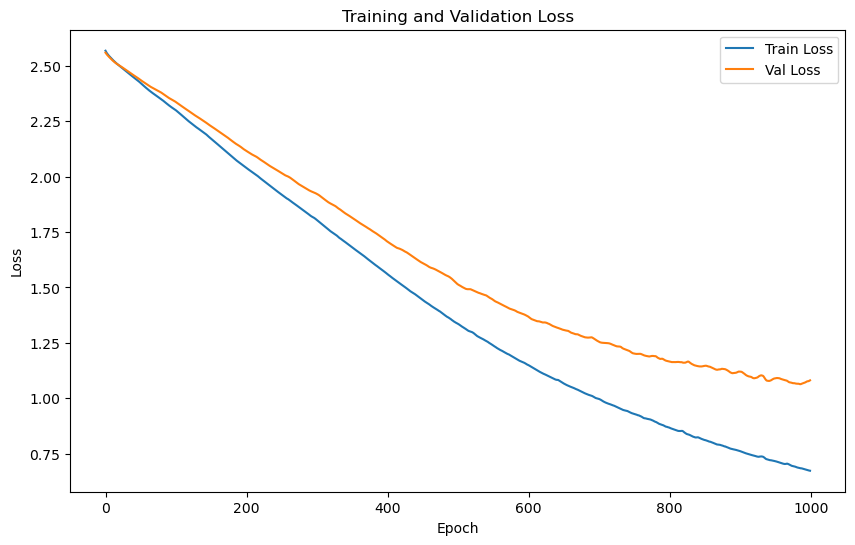

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.1425 | Test Accuracy: 65.86%


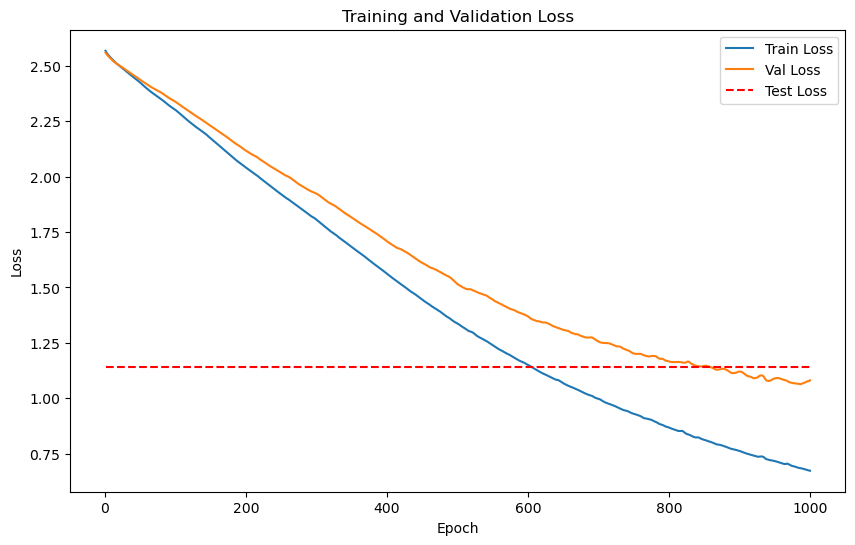

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.2532
Epoch [1/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.3642

Validation loss improved from inf to 0.3642. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.2538
Epoch [2/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.2540
Epoch [3/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2536
Epoch [4/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.3640

Validation loss improved from 0.3642 to 0.3640. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2526
Epoch [5/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.3635

Validation loss improved from 0.3640 to 0.3635. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2505
Epoch [6/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.3624

Validation loss improved from 0.3635 to 0.3624. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.2478
Epoch [7/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.3610

Validation loss improved from 0.3624 to 0.3610. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.2448
Epoch [8/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.3594

Validation loss improved from 0.3610 to 0.3594. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.2389
Epoch [9/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.3563

Validation loss improved from 0.3594 to 0.3563. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2341
Epoch [10/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.3536

Validation loss improved from 0.3563 to 0.3536. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2319
Epoch [11/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.3524

Validation loss improved from 0.3536 to 0.3524. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2323
Epoch [12/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.3525

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2323
Epoch [13/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.3524

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.2295
Epoch [14/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.3508

Validation loss improved from 0.3524 to 0.3508. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2257
Epoch [15/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.3486

Validation loss improved from 0.3508 to 0.3486. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.2204
Epoch [16/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.3456

Validation loss improved from 0.3486 to 0.3456. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.2163
Epoch [17/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.3432

Validation loss improved from 0.3456 to 0.3432. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2126
Epoch [18/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.3409

Validation loss improved from 0.3432 to 0.3409. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2095
Epoch [19/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.3387

Validation loss improved from 0.3409 to 0.3387. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.2065
Epoch [20/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.3363

Validation loss improved from 0.3387 to 0.3363. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.2034
Epoch [21/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.3341

Validation loss improved from 0.3363 to 0.3341. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.2008
Epoch [22/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.3322

Validation loss improved from 0.3341 to 0.3322. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.1973
Epoch [23/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.3303

Validation loss improved from 0.3322 to 0.3303. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.1932
Epoch [24/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.3280

Validation loss improved from 0.3303 to 0.3280. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.1892
Epoch [25/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.3258

Validation loss improved from 0.3280 to 0.3258. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.1847
Epoch [26/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.3234

Validation loss improved from 0.3258 to 0.3234. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.1808
Epoch [27/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3211

Validation loss improved from 0.3234 to 0.3211. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.1778
Epoch [28/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.3194

Validation loss improved from 0.3211 to 0.3194. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.1767
Epoch [29/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.3187

Validation loss improved from 0.3194 to 0.3187. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.1765
Epoch [30/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.3184

Validation loss improved from 0.3187 to 0.3184. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.1765
Epoch [31/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.3184

Validation loss improved from 0.3184 to 0.3184. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.1766
Epoch [32/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.1769
Epoch [33/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.3183

Validation loss improved from 0.3183 to 0.3183. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.1775
Epoch [34/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.3182

Validation loss improved from 0.3183 to 0.3182. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.1787
Epoch [35/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.3185

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.1801
Epoch [36/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3189

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.1815
Epoch [37/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.3192

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.1828
Epoch [38/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.3197

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.1841
Epoch [39/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3201

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.1852
Epoch [40/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3203

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.1862
Epoch [41/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.3205

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.1869
Epoch [42/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3206

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.1880
Epoch [43/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.3210

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.1892
Epoch [44/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3215

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.1900
Epoch [45/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3217

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.1906
Epoch [46/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3218

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.1914
Epoch [47/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.3221

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.1921
Epoch [48/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3224

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.1925
Epoch [49/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.3224

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.1934
Epoch [50/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.3227

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.1943
Epoch [51/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3230

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.1950
Epoch [52/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3231

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.1955
Epoch [53/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3231

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.1961
Epoch [54/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3232

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.1971
Epoch [55/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3235

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.1976
Epoch [56/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.3235

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.1982
Epoch [57/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3235

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.1988
Epoch [58/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3236

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.1996
Epoch [59/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3237

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.2004
Epoch [60/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.3239

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.4460
    Batch [2/2], Val Loss: 0.1999
Epoch [61/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3230

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.4449
    Batch [2/2], Val Loss: 0.1992
Epoch [62/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3220

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.1982
Epoch [63/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3210

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.1970
Epoch [64/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3200

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.1957
Epoch [65/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3189

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.1946
Epoch [66/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3180

Validation loss improved from 0.3182 to 0.3180. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.1932
Epoch [67/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3171

Validation loss improved from 0.3180 to 0.3171. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.1920
Epoch [68/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3162

Validation loss improved from 0.3171 to 0.3162. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.1908
Epoch [69/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3154

Validation loss improved from 0.3162 to 0.3154. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.1897
Epoch [70/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3146

Validation loss improved from 0.3154 to 0.3146. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.1885
Epoch [71/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.3138

Validation loss improved from 0.3146 to 0.3138. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.1874
Epoch [72/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.3130

Validation loss improved from 0.3138 to 0.3130. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.1863
Epoch [73/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3124

Validation loss improved from 0.3130 to 0.3124. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.1855
Epoch [74/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3119

Validation loss improved from 0.3124 to 0.3119. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.1848
Epoch [75/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3115

Validation loss improved from 0.3119 to 0.3115. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.1843
Epoch [76/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.3112

Validation loss improved from 0.3115 to 0.3112. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.1841
Epoch [77/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3110

Validation loss improved from 0.3112 to 0.3110. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.1839
Epoch [78/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3109

Validation loss improved from 0.3110 to 0.3109. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.1836
Epoch [79/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.3107

Validation loss improved from 0.3109 to 0.3107. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4377
    Batch [2/2], Val Loss: 0.1834
Epoch [80/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.3105

Validation loss improved from 0.3107 to 0.3105. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.1833
Epoch [81/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.1831
Epoch [82/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.3103

Validation loss improved from 0.3104 to 0.3103. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.1830
Epoch [83/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3102

Validation loss improved from 0.3103 to 0.3102. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.1828
Epoch [84/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3101

Validation loss improved from 0.3102 to 0.3101. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.1827
Epoch [85/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3100

Validation loss improved from 0.3101 to 0.3100. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.1825
Epoch [86/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3099

Validation loss improved from 0.3100 to 0.3099. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4372
    Batch [2/2], Val Loss: 0.1824
Epoch [87/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3098

Validation loss improved from 0.3099 to 0.3098. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.1823
Epoch [88/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.1822
Epoch [89/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3096

Validation loss improved from 0.3097 to 0.3096. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.1821
Epoch [90/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3096

Validation loss improved from 0.3096 to 0.3096. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.4370
    Batch [2/2], Val Loss: 0.1821
Epoch [91/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3096

Validation loss improved from 0.3096 to 0.3096. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.4370
    Batch [2/2], Val Loss: 0.1819
Epoch [92/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.3095

Validation loss improved from 0.3096 to 0.3095. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.4370
    Batch [2/2], Val Loss: 0.1817
Epoch [93/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3094

Validation loss improved from 0.3095 to 0.3094. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.1815
Epoch [94/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.3092

Validation loss improved from 0.3094 to 0.3092. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.1813
Epoch [95/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3091

Validation loss improved from 0.3092 to 0.3091. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4368
    Batch [2/2], Val Loss: 0.1811
Epoch [96/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3090

Validation loss improved from 0.3091 to 0.3090. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.1810
Epoch [97/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3089

Validation loss improved from 0.3090 to 0.3089. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.1808
Epoch [98/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3088

Validation loss improved from 0.3089 to 0.3088. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.1807
Epoch [99/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3087

Validation loss improved from 0.3088 to 0.3087. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.1806
Epoch [100/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3086

Validation loss improved from 0.3087 to 0.3086. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.1805
Epoch [101/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3085

Validation loss improved from 0.3086 to 0.3085. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.1803
Epoch [102/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3084

Validation loss improved from 0.3085 to 0.3084. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.1802
Epoch [103/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.3083

Validation loss improved from 0.3084 to 0.3083. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.1800
Epoch [104/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3082

Validation loss improved from 0.3083 to 0.3082. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.1798
Epoch [105/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3081

Validation loss improved from 0.3082 to 0.3081. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.1797
Epoch [106/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3080

Validation loss improved from 0.3081 to 0.3080. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.1796
Epoch [107/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3080

Validation loss improved from 0.3080 to 0.3080. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4362
    Batch [2/2], Val Loss: 0.1795
Epoch [108/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3079

Validation loss improved from 0.3080 to 0.3079. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4362
    Batch [2/2], Val Loss: 0.1795
Epoch [109/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3078

Validation loss improved from 0.3079 to 0.3078. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.1794
Epoch [110/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3077

Validation loss improved from 0.3078 to 0.3077. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.1793
Epoch [111/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3076

Validation loss improved from 0.3077 to 0.3076. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.1791
Epoch [112/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3075

Validation loss improved from 0.3076 to 0.3075. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4358
    Batch [2/2], Val Loss: 0.1790
Epoch [113/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3074

Validation loss improved from 0.3075 to 0.3074. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4357
    Batch [2/2], Val Loss: 0.1788
Epoch [114/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3073

Validation loss improved from 0.3074 to 0.3073. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4357
    Batch [2/2], Val Loss: 0.1787
Epoch [115/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3072

Validation loss improved from 0.3073 to 0.3072. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.1785
Epoch [116/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3070

Validation loss improved from 0.3072 to 0.3070. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.1783
Epoch [117/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3069

Validation loss improved from 0.3070 to 0.3069. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.1781
Epoch [118/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3068

Validation loss improved from 0.3069 to 0.3068. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.1780
Epoch [119/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3067

Validation loss improved from 0.3068 to 0.3067. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.1778
Epoch [120/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3066

Validation loss improved from 0.3067 to 0.3066. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.4353
    Batch [2/2], Val Loss: 0.1776
Epoch [121/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3064

Validation loss improved from 0.3066 to 0.3064. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.1774
Epoch [122/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3063

Validation loss improved from 0.3064 to 0.3063. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.1772
Epoch [123/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3062

Validation loss improved from 0.3063 to 0.3062. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.1770
Epoch [124/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.3060

Validation loss improved from 0.3062 to 0.3060. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.1769
Epoch [125/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3059

Validation loss improved from 0.3060 to 0.3059. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.1767
Epoch [126/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3058

Validation loss improved from 0.3059 to 0.3058. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.1767
Epoch [127/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3058

Validation loss improved from 0.3058 to 0.3058. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.1766
Epoch [128/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3057

Validation loss improved from 0.3058 to 0.3057. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.1766
Epoch [129/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3057

Validation loss improved from 0.3057 to 0.3057. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.1766
Epoch [130/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3056

Validation loss improved from 0.3057 to 0.3056. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.1766
Epoch [131/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3057

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.1766
Epoch [132/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.1766
Epoch [133/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.1765
Epoch [134/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.1766
Epoch [135/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.1766
Epoch [136/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.1766
Epoch [137/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3055

Validation loss improved from 0.3056 to 0.3055. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1766
Epoch [138/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1765
Epoch [139/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1764
Epoch [140/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1764
Epoch [141/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1763
Epoch [142/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3053

Validation loss improved from 0.3054 to 0.3053. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1762
Epoch [143/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1763
Epoch [144/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1762
Epoch [145/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1762
Epoch [146/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1762
Epoch [147/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3052

Validation loss improved from 0.3053 to 0.3052. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1761
Epoch [148/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1761
Epoch [149/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1761
Epoch [150/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1760
Epoch [151/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3051

Validation loss improved from 0.3052 to 0.3051. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [152/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1760
Epoch [152/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3051

Validation loss improved from 0.3051 to 0.3051. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1759
Epoch [153/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.3050

Validation loss improved from 0.3051 to 0.3050. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1759
Epoch [154/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3051

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1759
Epoch [155/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1758
Epoch [156/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3050

Validation loss improved from 0.3050 to 0.3050. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1758
Epoch [157/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3050

Validation loss improved from 0.3050 to 0.3050. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1758
Epoch [158/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3050

Validation loss improved from 0.3050 to 0.3050. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1758
Epoch [159/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3049

Validation loss improved from 0.3050 to 0.3049. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1757
Epoch [160/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3049

Validation loss improved from 0.3049 to 0.3049. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1756
Epoch [161/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3048

Validation loss improved from 0.3049 to 0.3048. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1755
Epoch [162/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3048

Validation loss improved from 0.3048 to 0.3048. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1754
Epoch [163/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3048

Validation loss improved from 0.3048 to 0.3048. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1755
Epoch [164/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1755
Epoch [165/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1756
Epoch [166/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1756
Epoch [167/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1756
Epoch [168/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1756
Epoch [169/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1756
Epoch [170/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1755
Epoch [171/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1755
Epoch [172/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3050

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1755
Epoch [173/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1754
Epoch [174/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1753
Epoch [175/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.3049

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1753
Epoch [176/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1752
Epoch [177/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3048

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1751
Epoch [178/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1750
Epoch [179/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3047

Validation loss improved from 0.3047 to 0.3047. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1749
Epoch [180/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1748
Epoch [181/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3045

Validation loss improved from 0.3046 to 0.3045. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1748
Epoch [182/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3045

Validation loss improved from 0.3045 to 0.3045. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1747
Epoch [183/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.3045

Validation loss improved from 0.3045 to 0.3045. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1747
Epoch [184/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3044

Validation loss improved from 0.3045 to 0.3044. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1746
Epoch [185/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3044

Validation loss improved from 0.3044 to 0.3044. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1745
Epoch [186/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3043

Validation loss improved from 0.3044 to 0.3043. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1744
Epoch [187/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3042

Validation loss improved from 0.3043 to 0.3042. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.1743
Epoch [188/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3041

Validation loss improved from 0.3042 to 0.3041. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.1742
Epoch [189/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3040

Validation loss improved from 0.3041 to 0.3040. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.1740
Epoch [190/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3039

Validation loss improved from 0.3040 to 0.3039. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.1739
Epoch [191/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3039

Validation loss improved from 0.3039 to 0.3039. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1739
Epoch [192/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3038

Validation loss improved from 0.3039 to 0.3038. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1738
Epoch [193/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3038

Validation loss improved from 0.3038 to 0.3038. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1737
Epoch [194/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3037

Validation loss improved from 0.3038 to 0.3037. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1737
Epoch [195/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3037

Validation loss improved from 0.3037 to 0.3037. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1736
Epoch [196/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3036

Validation loss improved from 0.3037 to 0.3036. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1735
Epoch [197/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1734
Epoch [198/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3035

Validation loss improved from 0.3036 to 0.3035. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1733
Epoch [199/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1732
Epoch [200/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3034

Validation loss improved from 0.3035 to 0.3034. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1731
Epoch [201/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3034

Validation loss improved from 0.3034 to 0.3034. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1730
Epoch [202/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3033

Validation loss improved from 0.3034 to 0.3033. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1730
Epoch [203/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3033

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.1730
Epoch [204/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3033

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1730
Epoch [205/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3033

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.1730
Epoch [206/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3033

Validation loss improved from 0.3033 to 0.3033. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.1731
Epoch [207/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3033

Validation loss improved from 0.3033 to 0.3033. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4335


    Batch [2/2], Val Loss: 0.1730
Epoch [208/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3033

Validation loss improved from 0.3033 to 0.3033. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1730
Epoch [209/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3032

Validation loss improved from 0.3033 to 0.3032. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1731
Epoch [210/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.3032

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1730
Epoch [211/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3032

Validation loss improved from 0.3032 to 0.3032. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1730
Epoch [212/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3032

Validation loss improved from 0.3032 to 0.3032. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1730
Epoch [213/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3032

Validation loss improved from 0.3032 to 0.3032. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1729
Epoch [214/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3032

Validation loss improved from 0.3032 to 0.3032. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1729
Epoch [215/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3031

Validation loss improved from 0.3032 to 0.3031. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1728
Epoch [216/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.3031

Validation loss improved from 0.3031 to 0.3031. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1728
Epoch [217/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3030

Validation loss improved from 0.3031 to 0.3030. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1728
Epoch [218/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3030

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1728
Epoch [219/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3030

Validation loss improved from 0.3030 to 0.3030. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1726
Epoch [220/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3030

Validation loss improved from 0.3030 to 0.3030. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1726
Epoch [221/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3029

Validation loss improved from 0.3030 to 0.3029. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.1724
Epoch [222/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3029

Validation loss improved from 0.3029 to 0.3029. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.1723
Epoch [223/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3028

Validation loss improved from 0.3029 to 0.3028. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [224/2000] - Validation


    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.1722
Epoch [224/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3027

Validation loss improved from 0.3028 to 0.3027. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.1721
Epoch [225/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3026

Validation loss improved from 0.3027 to 0.3026. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.1720
Epoch [226/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3025

Validation loss improved from 0.3026 to 0.3025. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.4330
    Batch [2/2], Val Loss: 0.1719
Epoch [227/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3024

Validation loss improved from 0.3025 to 0.3024. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.1718
Epoch [228/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3024

Validation loss improved from 0.3024 to 0.3024. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.1717
Epoch [229/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3023

Validation loss improved from 0.3024 to 0.3023. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4328
    Batch [2/2], Val Loss: 0.1716
Epoch [230/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3022

Validation loss improved from 0.3023 to 0.3022. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.1715
Epoch [231/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3021

Validation loss improved from 0.3022 to 0.3021. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1714
Epoch [232/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3020

Validation loss improved from 0.3021 to 0.3020. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1713
Epoch [233/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3019

Validation loss improved from 0.3020 to 0.3019. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1713
Epoch [234/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3019

Validation loss improved from 0.3019 to 0.3019. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1713
Epoch [235/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3019

Validation loss improved from 0.3019 to 0.3019. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.1713
Epoch [236/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3018

Validation loss improved from 0.3019 to 0.3018. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.1713
Epoch [237/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.3018

Validation loss improved from 0.3018 to 0.3018. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.1713
Epoch [238/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3018

Validation loss improved from 0.3018 to 0.3018. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.1713
Epoch [239/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3018

Validation loss improved from 0.3018 to 0.3018. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.1713
Epoch [240/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3017

Validation loss improved from 0.3018 to 0.3017. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.1712
Epoch [241/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3017

Validation loss improved from 0.3017 to 0.3017. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.1711
Epoch [242/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3016

Validation loss improved from 0.3017 to 0.3016. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.1711
Epoch [243/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3015

Validation loss improved from 0.3016 to 0.3015. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4319
    Batch [2/2], Val Loss: 0.1709
Epoch [244/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3014

Validation loss improved from 0.3015 to 0.3014. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.1708
Epoch [245/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3013

Validation loss improved from 0.3014 to 0.3013. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.1707
Epoch [246/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3012

Validation loss improved from 0.3013 to 0.3012. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1706
Epoch [247/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3011

Validation loss improved from 0.3012 to 0.3011. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1705
Epoch [248/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3011

Validation loss improved from 0.3011 to 0.3011. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1705
Epoch [249/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3010

Validation loss improved from 0.3011 to 0.3010. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.1704
Epoch [250/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3010

Validation loss improved from 0.3010 to 0.3010. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.1703
Epoch [251/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3009

Validation loss improved from 0.3010 to 0.3009. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.1702
Epoch [252/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3008

Validation loss improved from 0.3009 to 0.3008. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.1700
Epoch [253/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3007

Validation loss improved from 0.3008 to 0.3007. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1699
Epoch [254/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.3006

Validation loss improved from 0.3007 to 0.3006. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1698
Epoch [255/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1697
Epoch [256/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1697
Epoch [257/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3004

Validation loss improved from 0.3005 to 0.3004. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1696
Epoch [258/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3004

Validation loss improved from 0.3004 to 0.3004. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1695
Epoch [259/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3003

Validation loss improved from 0.3004 to 0.3003. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1695
Epoch [260/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.1694
Epoch [261/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.1694
Epoch [262/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [263/2000] - Validation


    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1694
Epoch [263/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1693
Epoch [264/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3003

Validation loss improved from 0.3003 to 0.3003. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1692
Epoch [265/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3002

Validation loss improved from 0.3003 to 0.3002. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1692
Epoch [266/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3002

Validation loss improved from 0.3002 to 0.3002. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1691
Epoch [267/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3001

Validation loss improved from 0.3002 to 0.3001. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1690
Epoch [268/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3001

Validation loss improved from 0.3001 to 0.3001. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1690
Epoch [269/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3001

Validation loss improved from 0.3001 to 0.3001. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4311


    Batch [2/2], Val Loss: 0.1690
Epoch [270/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3001

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1690
Epoch [271/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3001

Validation loss improved from 0.3001 to 0.3001. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1691
Epoch [272/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3001

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.1691
Epoch [273/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3001

Validation loss improved from 0.3001 to 0.3001. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.1690
Epoch [274/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3000

Validation loss improved from 0.3001 to 0.3000. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.1690
Epoch [275/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.3000

Validation loss improved from 0.3000 to 0.3000. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.1690
Epoch [276/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.2999

Validation loss improved from 0.3000 to 0.2999. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1689
Epoch [277/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2999

Validation loss improved from 0.2999 to 0.2999. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1689
Epoch [278/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2998

Validation loss improved from 0.2999 to 0.2998. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1689
Epoch [279/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2998

Validation loss improved from 0.2998 to 0.2998. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1689
Epoch [280/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2998

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1690
Epoch [281/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2998

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1690
Epoch [282/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1691
Epoch [283/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1691
Epoch [284/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1691
Epoch [285/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1691
Epoch [286/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1691
Epoch [287/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1691
Epoch [288/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1690
Epoch [289/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1690
Epoch [290/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.1689
Epoch [291/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1688
Epoch [292/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2998

Validation loss improved from 0.2998 to 0.2998. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1686
Epoch [293/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2997

Validation loss improved from 0.2998 to 0.2997. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1685
Epoch [294/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.2996

Validation loss improved from 0.2997 to 0.2996. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1684
Epoch [295/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2996

Validation loss improved from 0.2996 to 0.2996. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1683
Epoch [296/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2995

Validation loss improved from 0.2996 to 0.2995. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1682
Epoch [297/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2995

Validation loss improved from 0.2995 to 0.2995. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1681
Epoch [298/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2994

Validation loss improved from 0.2995 to 0.2994. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1681
Epoch [299/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.2994

Validation loss improved from 0.2994 to 0.2994. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1680
Epoch [300/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.2993

Validation loss improved from 0.2994 to 0.2993. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1679
Epoch [301/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2993

Validation loss improved from 0.2993 to 0.2993. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1679
Epoch [302/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2993

Validation loss improved from 0.2993 to 0.2993. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1678
Epoch [303/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2993

Validation loss improved from 0.2993 to 0.2993. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1677
Epoch [304/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2992

Validation loss improved from 0.2993 to 0.2992. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1677
Epoch [305/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2992

Validation loss improved from 0.2992 to 0.2992. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.1676
Epoch [306/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2991

Validation loss improved from 0.2992 to 0.2991. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.1676
Epoch [307/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2991

Validation loss improved from 0.2991 to 0.2991. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.1676
Epoch [308/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2990

Validation loss improved from 0.2991 to 0.2990. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.1676
Epoch [309/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2990

Validation loss improved from 0.2990 to 0.2990. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1676
Epoch [310/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2989

Validation loss improved from 0.2990 to 0.2989. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1675
Epoch [311/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2989

Validation loss improved from 0.2989 to 0.2989. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1675
Epoch [312/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2989

Validation loss improved from 0.2989 to 0.2989. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1674
Epoch [313/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2988

Validation loss improved from 0.2989 to 0.2988. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [314/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1673
Epoch [314/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2988

Validation loss improved from 0.2988 to 0.2988. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1672
Epoch [315/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2987

Validation loss improved from 0.2988 to 0.2987. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1671
Epoch [316/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2987

Validation loss improved from 0.2987 to 0.2987. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1670
Epoch [317/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2986

Validation loss improved from 0.2987 to 0.2986. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1669
Epoch [318/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.2986

Validation loss improved from 0.2986 to 0.2986. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1669
Epoch [319/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1668
Epoch [320/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1668
Epoch [321/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1668
Epoch [322/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4303


    Batch [2/2], Val Loss: 0.1668
Epoch [323/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.2986

Validation loss improved from 0.2986 to 0.2986. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [324/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1668
Epoch [324/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1668
Epoch [325/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.1668
Epoch [326/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2985

Validation loss improved from 0.2986 to 0.2985. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1667
Epoch [327/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2985

Validation loss improved from 0.2985 to 0.2985. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1666
Epoch [328/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.2984

Validation loss improved from 0.2985 to 0.2984. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.1664
Epoch [329/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2983

Validation loss improved from 0.2984 to 0.2983. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4300
    Batch [2/2], Val Loss: 0.1663
Epoch [330/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2982

Validation loss improved from 0.2983 to 0.2982. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.1662
Epoch [331/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2981

Validation loss improved from 0.2982 to 0.2981. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.1661
Epoch [332/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2980

Validation loss improved from 0.2981 to 0.2980. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.1660
Epoch [333/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2979

Validation loss improved from 0.2980 to 0.2979. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.1659
Epoch [334/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2978

Validation loss improved from 0.2979 to 0.2978. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.1658
Epoch [335/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2977

Validation loss improved from 0.2978 to 0.2977. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.1656
Epoch [336/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2977

Validation loss improved from 0.2977 to 0.2977. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.1656
Epoch [337/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2976

Validation loss improved from 0.2977 to 0.2976. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1655
Epoch [338/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2976

Validation loss improved from 0.2976 to 0.2976. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1654
Epoch [339/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2975

Validation loss improved from 0.2976 to 0.2975. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1652
Epoch [340/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2974

Validation loss improved from 0.2975 to 0.2974. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1651
Epoch [341/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.2973

Validation loss improved from 0.2974 to 0.2973. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.1649
Epoch [342/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2972

Validation loss improved from 0.2973 to 0.2972. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.1647
Epoch [343/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2971

Validation loss improved from 0.2972 to 0.2971. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.1646
Epoch [344/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2970

Validation loss improved from 0.2971 to 0.2970. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.1645
Epoch [345/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2970

Validation loss improved from 0.2970 to 0.2970. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1644
Epoch [346/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2969

Validation loss improved from 0.2970 to 0.2969. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1643
Epoch [347/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2969

Validation loss improved from 0.2969 to 0.2969. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1642
Epoch [348/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.2968

Validation loss improved from 0.2969 to 0.2968. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1641
Epoch [349/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2968

Validation loss improved from 0.2968 to 0.2968. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1642
Epoch [350/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2968

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1641
Epoch [351/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.2968

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.4293
    Batch [2/2], Val Loss: 0.1641
Epoch [352/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2967

Validation loss improved from 0.2968 to 0.2967. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.4293
    Batch [2/2], Val Loss: 0.1642
Epoch [353/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2967

Validation loss improved from 0.2967 to 0.2967. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.1642
Epoch [354/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2967

Validation loss improved from 0.2967 to 0.2967. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.1642
Epoch [355/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2967

Validation loss improved from 0.2967 to 0.2967. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.1642
Epoch [356/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2966

Validation loss improved from 0.2967 to 0.2966. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.1642
Epoch [357/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [358/2000] - Validation


    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.1643
Epoch [358/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.1643
Epoch [359/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2966

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.1643
Epoch [360/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.1643
Epoch [361/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.1643
Epoch [362/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.1643
Epoch [363/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2965

Validation loss improved from 0.2966 to 0.2965. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.1642
Epoch [364/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2965

Validation loss improved from 0.2965 to 0.2965. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.1642
Epoch [365/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2965

Validation loss improved from 0.2965 to 0.2965. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [366/2000] - Validation


    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.1641
Epoch [366/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2964

Validation loss improved from 0.2965 to 0.2964. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.1640
Epoch [367/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2963

Validation loss improved from 0.2964 to 0.2963. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.1639
Epoch [368/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2963

Validation loss improved from 0.2963 to 0.2963. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.1639
Epoch [369/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.2962

Validation loss improved from 0.2963 to 0.2962. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4285
    Batch [2/2], Val Loss: 0.1638
Epoch [370/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2961

Validation loss improved from 0.2962 to 0.2961. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.1637
Epoch [371/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2960

Validation loss improved from 0.2961 to 0.2960. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.1636
Epoch [372/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2960

Validation loss improved from 0.2960 to 0.2960. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.1635
Epoch [373/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2959

Validation loss improved from 0.2960 to 0.2959. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.1634
Epoch [374/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2959

Validation loss improved from 0.2959 to 0.2959. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.1633
Epoch [375/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2958

Validation loss improved from 0.2959 to 0.2958. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.1633
Epoch [376/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2957

Validation loss improved from 0.2958 to 0.2957. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.1632
Epoch [377/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.2957

Validation loss improved from 0.2957 to 0.2957. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.1632
Epoch [378/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2957

Validation loss improved from 0.2957 to 0.2957. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.1632
Epoch [379/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2956

Validation loss improved from 0.2957 to 0.2956. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.1631
Epoch [380/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2956

Validation loss improved from 0.2956 to 0.2956. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.1631
Epoch [381/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2956

Validation loss improved from 0.2956 to 0.2956. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.1630
Epoch [382/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2955

Validation loss improved from 0.2956 to 0.2955. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.1629
Epoch [383/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2954

Validation loss improved from 0.2955 to 0.2954. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.1628
Epoch [384/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.2954

Validation loss improved from 0.2954 to 0.2954. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1627
Epoch [385/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2953

Validation loss improved from 0.2954 to 0.2953. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1626
Epoch [386/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.2952

Validation loss improved from 0.2953 to 0.2952. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1625
Epoch [387/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2951

Validation loss improved from 0.2952 to 0.2951. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1623
Epoch [388/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1622
Epoch [389/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2949

Validation loss improved from 0.2950 to 0.2949. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.1621
Epoch [390/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2949

Validation loss improved from 0.2949 to 0.2949. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1620
Epoch [391/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2948

Validation loss improved from 0.2949 to 0.2948. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1620
Epoch [392/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2948

Validation loss improved from 0.2948 to 0.2948. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1619
Epoch [393/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2948

Validation loss improved from 0.2948 to 0.2948. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1619
Epoch [394/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2948

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1619
Epoch [395/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2948

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1618
Epoch [396/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2948

Validation loss improved from 0.2948 to 0.2948. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1617
Epoch [397/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2948

Validation loss improved from 0.2948 to 0.2948. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1617
Epoch [398/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2947

Validation loss improved from 0.2948 to 0.2947. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1616
Epoch [399/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2947

Validation loss improved from 0.2947 to 0.2947. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1615
Epoch [400/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2946

Validation loss improved from 0.2947 to 0.2946. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1614
Epoch [401/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2946

Validation loss improved from 0.2946 to 0.2946. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1613
Epoch [402/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2945

Validation loss improved from 0.2946 to 0.2945. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.1612
Epoch [403/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2945

Validation loss improved from 0.2945 to 0.2945. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1612
Epoch [404/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2945

Validation loss improved from 0.2945 to 0.2945. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1612
Epoch [405/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2945

Validation loss improved from 0.2945 to 0.2945. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1611
Epoch [406/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2944

Validation loss improved from 0.2945 to 0.2944. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1611
Epoch [407/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2944

Validation loss improved from 0.2944 to 0.2944. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1611
Epoch [408/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2944

Validation loss improved from 0.2944 to 0.2944. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.1611
Epoch [409/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2944

Validation loss improved from 0.2944 to 0.2944. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.1611
Epoch [410/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2943

Validation loss improved from 0.2944 to 0.2943. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.1611
Epoch [411/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2943

Validation loss improved from 0.2943 to 0.2943. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.1610
Epoch [412/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2942

Validation loss improved from 0.2943 to 0.2942. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4274
    Batch [2/2], Val Loss: 0.1609
Epoch [413/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2942

Validation loss improved from 0.2942 to 0.2942. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.1609
Epoch [414/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2941

Validation loss improved from 0.2942 to 0.2941. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.1608
Epoch [415/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2940

Validation loss improved from 0.2941 to 0.2940. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.1608
Epoch [416/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2940

Validation loss improved from 0.2940 to 0.2940. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.1608
Epoch [417/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2939

Validation loss improved from 0.2940 to 0.2939. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.1608
Epoch [418/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2939

Validation loss improved from 0.2939 to 0.2939. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [419/2000] - Validation


    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.1608
Epoch [419/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2939

Validation loss improved from 0.2939 to 0.2939. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [420/2000] - Validation


    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.1607
Epoch [420/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2938

Validation loss improved from 0.2939 to 0.2938. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.1608
Epoch [421/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2938

Validation loss improved from 0.2938 to 0.2938. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.1608
Epoch [422/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2938

Validation loss improved from 0.2938 to 0.2938. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1608
Epoch [423/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2938

Validation loss improved from 0.2938 to 0.2938. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [424/2000] - Validation


    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1607
Epoch [424/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2938

Validation loss improved from 0.2938 to 0.2938. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [425/2000] - Validation


    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1607
Epoch [425/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2937

Validation loss improved from 0.2938 to 0.2937. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1606
Epoch [426/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2937

Validation loss improved from 0.2937 to 0.2937. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1605
Epoch [427/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2936

Validation loss improved from 0.2937 to 0.2936. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1605
Epoch [428/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2936

Validation loss improved from 0.2936 to 0.2936. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1604
Epoch [429/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2935

Validation loss improved from 0.2936 to 0.2935. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1603
Epoch [430/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2935

Validation loss improved from 0.2935 to 0.2935. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1603
Epoch [431/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2935

Validation loss improved from 0.2935 to 0.2935. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1602
Epoch [432/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2934

Validation loss improved from 0.2935 to 0.2934. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1602
Epoch [433/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2934

Validation loss improved from 0.2934 to 0.2934. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1601
Epoch [434/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2934

Validation loss improved from 0.2934 to 0.2934. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1600
Epoch [435/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2933

Validation loss improved from 0.2934 to 0.2933. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1599
Epoch [436/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2933

Validation loss improved from 0.2933 to 0.2933. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1599
Epoch [437/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2933

Validation loss improved from 0.2933 to 0.2933. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1598
Epoch [438/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2933

Validation loss improved from 0.2933 to 0.2933. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1598
Epoch [439/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2933

Validation loss improved from 0.2933 to 0.2933. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1598
Epoch [440/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2932

Validation loss improved from 0.2933 to 0.2932. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1598
Epoch [441/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2932

Validation loss improved from 0.2932 to 0.2932. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.1597
Epoch [442/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2932

Validation loss improved from 0.2932 to 0.2932. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1597
Epoch [443/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2932

Validation loss improved from 0.2932 to 0.2932. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [444/2000] - Validation


    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1597
Epoch [444/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2932

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1597
Epoch [445/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2932

Validation loss improved from 0.2932 to 0.2932. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1596
Epoch [446/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2931

Validation loss improved from 0.2932 to 0.2931. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.1595
Epoch [447/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2930

Validation loss improved from 0.2931 to 0.2930. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1594
Epoch [448/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2929

Validation loss improved from 0.2930 to 0.2929. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.1593
Epoch [449/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2928

Validation loss improved from 0.2929 to 0.2928. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.1592
Epoch [450/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2927

Validation loss improved from 0.2928 to 0.2927. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.1591
Epoch [451/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1591
Epoch [452/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2926

Validation loss improved from 0.2927 to 0.2926. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1590
Epoch [453/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2925

Validation loss improved from 0.2926 to 0.2925. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1589
Epoch [454/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2925

Validation loss improved from 0.2925 to 0.2925. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1589
Epoch [455/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2924

Validation loss improved from 0.2925 to 0.2924. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1588
Epoch [456/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1587
Epoch [457/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2923

Validation loss improved from 0.2924 to 0.2923. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1587
Epoch [458/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2923

Validation loss improved from 0.2923 to 0.2923. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1586
Epoch [459/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2922

Validation loss improved from 0.2923 to 0.2922. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1585
Epoch [460/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2922

Validation loss improved from 0.2922 to 0.2922. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1586
Epoch [461/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1586
Epoch [462/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1586
Epoch [463/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1586
Epoch [464/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1585
Epoch [465/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1584
Epoch [466/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1584
Epoch [467/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1584
Epoch [468/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2922

Validation loss improved from 0.2922 to 0.2922. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1583
Epoch [469/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2921

Validation loss improved from 0.2922 to 0.2921. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1581
Epoch [470/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2921

Validation loss improved from 0.2921 to 0.2921. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1580
Epoch [471/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2920

Validation loss improved from 0.2921 to 0.2920. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1579
Epoch [472/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2920

Validation loss improved from 0.2920 to 0.2920. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1578
Epoch [473/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2919

Validation loss improved from 0.2920 to 0.2919. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1576
Epoch [474/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2918

Validation loss improved from 0.2919 to 0.2918. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1575
Epoch [475/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2918

Validation loss improved from 0.2918 to 0.2918. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1575
Epoch [476/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2917

Validation loss improved from 0.2918 to 0.2917. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1574
Epoch [477/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2917

Validation loss improved from 0.2917 to 0.2917. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1574
Epoch [478/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2917

Validation loss improved from 0.2917 to 0.2917. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1574
Epoch [479/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2917

Validation loss improved from 0.2917 to 0.2917. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.1573
Epoch [480/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2916

Validation loss improved from 0.2917 to 0.2916. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1573
Epoch [481/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2916

Validation loss improved from 0.2916 to 0.2916. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1573
Epoch [482/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2916

Validation loss improved from 0.2916 to 0.2916. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1573
Epoch [483/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1573
Epoch [484/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1573
Epoch [485/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1572
Epoch [486/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2916

Validation loss improved from 0.2916 to 0.2916. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1572
Epoch [487/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2916

Validation loss improved from 0.2916 to 0.2916. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1571
Epoch [488/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2915

Validation loss improved from 0.2916 to 0.2915. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [489/2000] - Validation


    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.1571
Epoch [489/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2915

Validation loss improved from 0.2915 to 0.2915. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1571
Epoch [490/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2914

Validation loss improved from 0.2915 to 0.2914. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1570
Epoch [491/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2914

Validation loss improved from 0.2914 to 0.2914. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1570
Epoch [492/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2914

Validation loss improved from 0.2914 to 0.2914. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [493/2000] - Validation


    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.1569
Epoch [493/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2913

Validation loss improved from 0.2914 to 0.2913. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [494/2000] - Validation


    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1569
Epoch [494/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2913

Validation loss improved from 0.2913 to 0.2913. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.1569
Epoch [495/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2912

Validation loss improved from 0.2913 to 0.2912. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.1569
Epoch [496/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2912

Validation loss improved from 0.2912 to 0.2912. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.1569
Epoch [497/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2912

Validation loss improved from 0.2912 to 0.2912. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.1569
Epoch [498/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2912

Validation loss improved from 0.2912 to 0.2912. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1569
Epoch [499/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2911

Validation loss improved from 0.2912 to 0.2911. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1569
Epoch [500/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2911

Validation loss improved from 0.2911 to 0.2911. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.1569
Epoch [501/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2910

Validation loss improved from 0.2911 to 0.2910. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1569
Epoch [502/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2910

Validation loss improved from 0.2910 to 0.2910. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1569
Epoch [503/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2910

Validation loss improved from 0.2910 to 0.2910. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1569
Epoch [504/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2909

Validation loss improved from 0.2910 to 0.2909. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1569
Epoch [505/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2909

Validation loss improved from 0.2909 to 0.2909. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1569
Epoch [506/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2909

Validation loss improved from 0.2909 to 0.2909. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1569
Epoch [507/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1569
Epoch [508/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1569
Epoch [509/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1570
Epoch [510/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1570
Epoch [511/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1570
Epoch [512/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1570
Epoch [513/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [514/2000] - Validation


    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1570
Epoch [514/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1570
Epoch [515/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1571
Epoch [516/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.1570
Epoch [517/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [518/2000] - Validation


    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1570
Epoch [518/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [519/2000] - Validation


    Batch [1/2], Val Loss: 0.4248
    Batch [2/2], Val Loss: 0.1569
Epoch [519/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2908

Validation loss improved from 0.2909 to 0.2908. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [520/2000] - Validation


    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.1568
Epoch [520/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2907

Validation loss improved from 0.2908 to 0.2907. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1566
Epoch [521/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2906

Validation loss improved from 0.2907 to 0.2906. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [522/2000] - Validation


    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1565
Epoch [522/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2905

Validation loss improved from 0.2906 to 0.2905. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [523/2000] - Validation


    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1565
Epoch [523/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2904

Validation loss improved from 0.2905 to 0.2904. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1564
Epoch [524/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2904

Validation loss improved from 0.2904 to 0.2904. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1563
Epoch [525/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2903

Validation loss improved from 0.2904 to 0.2903. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [526/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1563
Epoch [526/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2903

Validation loss improved from 0.2903 to 0.2903. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [527/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1562
Epoch [527/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2903

Validation loss improved from 0.2903 to 0.2903. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [528/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1561
Epoch [528/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2902

Validation loss improved from 0.2903 to 0.2902. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1559
Epoch [529/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2901

Validation loss improved from 0.2902 to 0.2901. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1558
Epoch [530/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2901

Validation loss improved from 0.2901 to 0.2901. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1556
Epoch [531/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2900

Validation loss improved from 0.2901 to 0.2900. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1555
Epoch [532/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2899

Validation loss improved from 0.2900 to 0.2899. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1554
Epoch [533/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2898

Validation loss improved from 0.2899 to 0.2898. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1553
Epoch [534/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2898

Validation loss improved from 0.2898 to 0.2898. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1552
Epoch [535/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2898

Validation loss improved from 0.2898 to 0.2898. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1552
Epoch [536/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2897

Validation loss improved from 0.2898 to 0.2897. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1551
Epoch [537/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1552
Epoch [538/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1552
Epoch [539/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1552
Epoch [540/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [541/2000] - Validation


    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1552
Epoch [541/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1552
Epoch [542/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1552
Epoch [543/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1551
Epoch [544/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1551
Epoch [545/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2897

Validation loss improved from 0.2897 to 0.2897. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1550
Epoch [546/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2897

Validation loss improved from 0.2897 to 0.2897. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1550
Epoch [547/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2896

Validation loss improved from 0.2897 to 0.2896. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1549
Epoch [548/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2896

Validation loss improved from 0.2896 to 0.2896. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1549
Epoch [549/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2896

Validation loss improved from 0.2896 to 0.2896. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1548
Epoch [550/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2895

Validation loss improved from 0.2896 to 0.2895. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1547
Epoch [551/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2895

Validation loss improved from 0.2895 to 0.2895. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1546
Epoch [552/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2894

Validation loss improved from 0.2895 to 0.2894. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1545
Epoch [553/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2894

Validation loss improved from 0.2894 to 0.2894. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1545
Epoch [554/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2893

Validation loss improved from 0.2894 to 0.2893. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.1545
Epoch [555/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2893

Validation loss improved from 0.2893 to 0.2893. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1545
Epoch [556/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2893

Validation loss improved from 0.2893 to 0.2893. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [557/2000] - Validation


    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1545
Epoch [557/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2892

Validation loss improved from 0.2893 to 0.2892. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [558/2000] - Validation


    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1545
Epoch [558/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2892

Validation loss improved from 0.2892 to 0.2892. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [559/2000] - Validation


    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1544
Epoch [559/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2892

Validation loss improved from 0.2892 to 0.2892. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1544
Epoch [560/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2891

Validation loss improved from 0.2892 to 0.2891. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [561/2000] - Validation


    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1543
Epoch [561/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2891

Validation loss improved from 0.2891 to 0.2891. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1543
Epoch [562/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2890

Validation loss improved from 0.2891 to 0.2890. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1542
Epoch [563/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2889

Validation loss improved from 0.2890 to 0.2889. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [564/2000] - Validation


    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1541
Epoch [564/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2889

Validation loss improved from 0.2889 to 0.2889. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [565/2000] - Validation


    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1540
Epoch [565/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2888

Validation loss improved from 0.2889 to 0.2888. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1539
Epoch [566/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2888

Validation loss improved from 0.2888 to 0.2888. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1538
Epoch [567/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2887

Validation loss improved from 0.2888 to 0.2887. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1537
Epoch [568/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.2886

Validation loss improved from 0.2887 to 0.2886. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1537
Epoch [569/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2886

Validation loss improved from 0.2886 to 0.2886. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1536
Epoch [570/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2885

Validation loss improved from 0.2886 to 0.2885. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1535
Epoch [571/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2885

Validation loss improved from 0.2885 to 0.2885. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1534
Epoch [572/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2884

Validation loss improved from 0.2885 to 0.2884. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1534
Epoch [573/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2884

Validation loss improved from 0.2884 to 0.2884. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1534
Epoch [574/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2883

Validation loss improved from 0.2884 to 0.2883. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1534
Epoch [575/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2883

Validation loss improved from 0.2883 to 0.2883. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [576/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1533
Epoch [576/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2883

Validation loss improved from 0.2883 to 0.2883. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1532
Epoch [577/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2882

Validation loss improved from 0.2883 to 0.2882. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1532
Epoch [578/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1531
Epoch [579/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1531
Epoch [580/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [581/2000] - Validation


    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1530
Epoch [581/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2881

Validation loss improved from 0.2882 to 0.2881. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1530
Epoch [582/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2881

Validation loss improved from 0.2881 to 0.2881. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [583/2000] - Validation


    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.1530
Epoch [583/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2880

Validation loss improved from 0.2881 to 0.2880. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.1529
Epoch [584/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2880

Validation loss improved from 0.2880 to 0.2880. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.1528
Epoch [585/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2879

Validation loss improved from 0.2880 to 0.2879. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.1528
Epoch [586/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2878

Validation loss improved from 0.2879 to 0.2878. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1528
Epoch [587/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2878

Validation loss improved from 0.2878 to 0.2878. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1528
Epoch [588/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2877

Validation loss improved from 0.2878 to 0.2877. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.1528
Epoch [589/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2877

Validation loss improved from 0.2877 to 0.2877. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.1528
Epoch [590/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2877

Validation loss improved from 0.2877 to 0.2877. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1528
Epoch [591/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2876

Validation loss improved from 0.2877 to 0.2876. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1527
Epoch [592/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2875

Validation loss improved from 0.2876 to 0.2875. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1527
Epoch [593/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2875

Validation loss improved from 0.2875 to 0.2875. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1527
Epoch [594/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2875

Validation loss improved from 0.2875 to 0.2875. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1527
Epoch [595/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2875

Validation loss improved from 0.2875 to 0.2875. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1526
Epoch [596/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2875

Validation loss improved from 0.2875 to 0.2875. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1526
Epoch [597/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2875

Validation loss improved from 0.2875 to 0.2875. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1525
Epoch [598/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2874

Validation loss improved from 0.2875 to 0.2874. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1525
Epoch [599/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.2874

Validation loss improved from 0.2874 to 0.2874. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1525
Epoch [600/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2874

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1525
Epoch [601/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2874

Validation loss improved from 0.2874 to 0.2874. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.1524
Epoch [602/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2874

Validation loss improved from 0.2874 to 0.2874. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1524
Epoch [603/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2874

Validation loss improved from 0.2874 to 0.2874. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.1523
Epoch [604/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2873

Validation loss improved from 0.2874 to 0.2873. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1523
Epoch [605/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2873

Validation loss improved from 0.2873 to 0.2873. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [606/2000] - Validation


    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1522
Epoch [606/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2872

Validation loss improved from 0.2873 to 0.2872. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [607/2000] - Validation


    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.1522
Epoch [607/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2871

Validation loss improved from 0.2872 to 0.2871. Saving model...
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [608/2000] - Validation


    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.1521
Epoch [608/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2871

Validation loss improved from 0.2871 to 0.2871. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.1520
Epoch [609/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2870

Validation loss improved from 0.2871 to 0.2870. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.1519
Epoch [610/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2869

Validation loss improved from 0.2870 to 0.2869. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.1519
Epoch [611/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2869

Validation loss improved from 0.2869 to 0.2869. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.1519
Epoch [612/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2869

Validation loss improved from 0.2869 to 0.2869. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1518
Epoch [613/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2868

Validation loss improved from 0.2869 to 0.2868. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1518
Epoch [614/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2868

Validation loss improved from 0.2868 to 0.2868. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1518
Epoch [615/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2868

Validation loss improved from 0.2868 to 0.2868. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1518
Epoch [616/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2868

Validation loss improved from 0.2868 to 0.2868. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1518
Epoch [617/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2868

Validation loss improved from 0.2868 to 0.2868. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1518
Epoch [618/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2868

Validation loss improved from 0.2868 to 0.2868. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1517
Epoch [619/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2867

Validation loss improved from 0.2868 to 0.2867. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1517
Epoch [620/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2867

Validation loss improved from 0.2867 to 0.2867. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1516
Epoch [621/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2867

Validation loss improved from 0.2867 to 0.2867. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1516
Epoch [622/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2867

Validation loss improved from 0.2867 to 0.2867. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1515
Epoch [623/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2866

Validation loss improved from 0.2867 to 0.2866. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [624/2000] - Validation


    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1515
Epoch [624/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2866

Validation loss improved from 0.2866 to 0.2866. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [625/2000] - Validation


    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1515
Epoch [625/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2866

Validation loss improved from 0.2866 to 0.2866. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1515
Epoch [626/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.2866

Validation loss improved from 0.2866 to 0.2866. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1514
Epoch [627/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2866

Validation loss improved from 0.2866 to 0.2866. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4216
    Batch [2/2], Val Loss: 0.1513
Epoch [628/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2865

Validation loss improved from 0.2866 to 0.2865. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.1512
Epoch [629/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2863

Validation loss improved from 0.2865 to 0.2863. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.1511
Epoch [630/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2862

Validation loss improved from 0.2863 to 0.2862. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.1510
Epoch [631/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2861

Validation loss improved from 0.2862 to 0.2861. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.1509
Epoch [632/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2861

Validation loss improved from 0.2861 to 0.2861. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.1508
Epoch [633/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2860

Validation loss improved from 0.2861 to 0.2860. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.1507
Epoch [634/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2859

Validation loss improved from 0.2860 to 0.2859. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.1506
Epoch [635/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2859

Validation loss improved from 0.2859 to 0.2859. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.1505
Epoch [636/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.1505
Epoch [637/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2858

Validation loss improved from 0.2858 to 0.2858. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1505
Epoch [638/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2857

Validation loss improved from 0.2858 to 0.2857. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1504
Epoch [639/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2857

Validation loss improved from 0.2857 to 0.2857. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1504
Epoch [640/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2857

Validation loss improved from 0.2857 to 0.2857. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [641/2000] - Validation


    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1503
Epoch [641/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2857

Validation loss improved from 0.2857 to 0.2857. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [642/2000] - Validation


    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1503
Epoch [642/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1502
Epoch [643/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2856

Validation loss improved from 0.2857 to 0.2856. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1502
Epoch [644/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2856

Validation loss improved from 0.2856 to 0.2856. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1501
Epoch [645/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2856

Validation loss improved from 0.2856 to 0.2856. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.1501
Epoch [646/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2855

Validation loss improved from 0.2856 to 0.2855. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1501
Epoch [647/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2855

Validation loss improved from 0.2855 to 0.2855. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1500
Epoch [648/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2855

Validation loss improved from 0.2855 to 0.2855. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1500
Epoch [649/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2854

Validation loss improved from 0.2855 to 0.2854. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1499
Epoch [650/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2854

Validation loss improved from 0.2854 to 0.2854. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1499
Epoch [651/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2854

Validation loss improved from 0.2854 to 0.2854. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1499
Epoch [652/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1499
Epoch [653/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1499
Epoch [654/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1499
Epoch [655/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1499
Epoch [656/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1499
Epoch [657/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [658/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1499
Epoch [658/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [659/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1498
Epoch [659/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2852

Validation loss improved from 0.2853 to 0.2852. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [660/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1498
Epoch [660/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [661/2000] - Validation


    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1497
Epoch [661/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1497
Epoch [662/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [663/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [663/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2851

Validation loss improved from 0.2852 to 0.2851. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [664/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [664/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [665/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [665/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2851

Validation loss improved from 0.2851 to 0.2851. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [666/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [666/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2851

Validation loss improved from 0.2851 to 0.2851. Saving model...
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [667/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [667/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2851

Validation loss improved from 0.2851 to 0.2851. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [668/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [668/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2851

Validation loss improved from 0.2851 to 0.2851. Saving model...
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [669/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [669/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [670/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1497
Epoch [670/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [671/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1497
Epoch [671/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [672/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1498
Epoch [672/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [673/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1498
Epoch [673/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [674/2000] - Validation


    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1498
Epoch [674/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [675/2000] - Validation


    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1497
Epoch [675/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1497
Epoch [676/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1497
Epoch [677/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1497
Epoch [678/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1498
Epoch [679/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1498
Epoch [680/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1497
Epoch [681/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1497
Epoch [682/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1496
Epoch [683/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1495
Epoch [684/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1495
Epoch [685/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1494
Epoch [686/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1495
Epoch [687/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1495
Epoch [688/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [689/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.1496
Epoch [690/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1497
Epoch [691/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.1497
Epoch [692/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.1497
Epoch [693/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2851

Validation loss improved from 0.2851 to 0.2851. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [694/2000] - Validation


    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.1497
Epoch [694/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2851

Validation loss improved from 0.2851 to 0.2851. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [695/2000] - Validation


    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.1498
Epoch [695/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2850

Validation loss improved from 0.2851 to 0.2850. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [696/2000] - Validation


    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.1498
Epoch [696/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2850

Validation loss improved from 0.2850 to 0.2850. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [697/2000] - Validation


    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.1499
Epoch [697/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2850

Validation loss improved from 0.2850 to 0.2850. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [698/2000] - Validation


    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.1499
Epoch [698/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2850

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [699/2000] - Validation


    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.1500
Epoch [699/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2850

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [700/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1501
Epoch [700/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2850

Validation loss improved from 0.2850 to 0.2850. Saving model...
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [701/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1500
Epoch [701/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2849

Validation loss improved from 0.2850 to 0.2849. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [702/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1500
Epoch [702/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2849

Validation loss improved from 0.2849 to 0.2849. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [703/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1499
Epoch [703/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2849

Validation loss improved from 0.2849 to 0.2849. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [704/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1499
Epoch [704/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2848

Validation loss improved from 0.2849 to 0.2848. Saving model...
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [705/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1498
Epoch [705/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2847

Validation loss improved from 0.2848 to 0.2847. Saving model...
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [706/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1497
Epoch [706/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2847

Validation loss improved from 0.2847 to 0.2847. Saving model...
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [707/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1495
Epoch [707/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2846

Validation loss improved from 0.2847 to 0.2846. Saving model...
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [708/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1494
Epoch [708/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2846

Validation loss improved from 0.2846 to 0.2846. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [709/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1492
Epoch [709/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2845

Validation loss improved from 0.2846 to 0.2845. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [710/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1491
Epoch [710/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2844

Validation loss improved from 0.2845 to 0.2844. Saving model...
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [711/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1490
Epoch [711/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2843

Validation loss improved from 0.2844 to 0.2843. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [712/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1490
Epoch [712/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2843

Validation loss improved from 0.2843 to 0.2843. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1489
Epoch [713/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2843

Validation loss improved from 0.2843 to 0.2843. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1488
Epoch [714/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2842

Validation loss improved from 0.2843 to 0.2842. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1488
Epoch [715/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2842

Validation loss improved from 0.2842 to 0.2842. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1488
Epoch [716/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1489
Epoch [717/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1488
Epoch [718/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1489
Epoch [719/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2843

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1489
Epoch [720/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2843

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1490
Epoch [721/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2844

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1490
Epoch [722/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2844

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1490
Epoch [723/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2845

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1490
Epoch [724/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2845

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1490
Epoch [725/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2845

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1489
Epoch [726/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2844

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1489
Epoch [727/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2844

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1488
Epoch [728/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2843

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1488
Epoch [729/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2843

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1488
Epoch [730/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1487
Epoch [731/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1487
Epoch [732/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1487
Epoch [733/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1487
Epoch [734/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1487
Epoch [735/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1487
Epoch [736/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2842

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [737/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1486
Epoch [737/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2842

Validation loss improved from 0.2842 to 0.2842. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [738/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1485
Epoch [738/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2842

Validation loss improved from 0.2842 to 0.2842. Saving model...
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [739/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1484
Epoch [739/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2841

Validation loss improved from 0.2842 to 0.2841. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [740/2000] - Validation


    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1484
Epoch [740/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2841

Validation loss improved from 0.2841 to 0.2841. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.1483
Epoch [741/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2840

Validation loss improved from 0.2841 to 0.2840. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1483
Epoch [742/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2840

Validation loss improved from 0.2840 to 0.2840. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1482
Epoch [743/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2839

Validation loss improved from 0.2840 to 0.2839. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1481
Epoch [744/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2839

Validation loss improved from 0.2839 to 0.2839. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1480
Epoch [745/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2838

Validation loss improved from 0.2839 to 0.2838. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1479
Epoch [746/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2838

Validation loss improved from 0.2838 to 0.2838. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1479
Epoch [747/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2837

Validation loss improved from 0.2838 to 0.2837. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.1478
Epoch [748/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2837

Validation loss improved from 0.2837 to 0.2837. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.1478
Epoch [749/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2836

Validation loss improved from 0.2837 to 0.2836. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.1478
Epoch [750/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.1478
Epoch [751/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [752/2000] - Validation


    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.1479
Epoch [752/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [753/2000] - Validation


    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1480
Epoch [753/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [754/2000] - Validation


    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1481
Epoch [754/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [755/2000] - Validation


    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.1481
Epoch [755/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [756/2000] - Validation


    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.1482
Epoch [756/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [757/2000] - Validation


    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1482
Epoch [757/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1483
Epoch [758/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1483
Epoch [759/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1483
Epoch [760/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [761/2000] - Validation


    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1482
Epoch [761/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [762/2000] - Validation


    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1482
Epoch [762/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2835

Validation loss improved from 0.2836 to 0.2835. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [763/2000] - Validation


    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1481
Epoch [763/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2835

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [764/2000] - Validation


    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1481
Epoch [764/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2835

Validation loss improved from 0.2835 to 0.2835. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1480
Epoch [765/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2835

Validation loss improved from 0.2835 to 0.2835. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1480
Epoch [766/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2835

Validation loss improved from 0.2835 to 0.2835. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1479
Epoch [767/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2835

Validation loss improved from 0.2835 to 0.2835. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1478
Epoch [768/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2834

Validation loss improved from 0.2835 to 0.2834. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1478
Epoch [769/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2834

Validation loss improved from 0.2834 to 0.2834. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1477
Epoch [770/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2833

Validation loss improved from 0.2834 to 0.2833. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1476
Epoch [771/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2833

Validation loss improved from 0.2833 to 0.2833. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1475
Epoch [772/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2832

Validation loss improved from 0.2833 to 0.2832. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1473
Epoch [773/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2832

Validation loss improved from 0.2832 to 0.2832. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.1472
Epoch [774/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2832

Validation loss improved from 0.2832 to 0.2832. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1472
Epoch [775/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2831

Validation loss improved from 0.2832 to 0.2831. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1471
Epoch [776/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2831

Validation loss improved from 0.2831 to 0.2831. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1470
Epoch [777/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2830

Validation loss improved from 0.2831 to 0.2830. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1470
Epoch [778/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2830

Validation loss improved from 0.2830 to 0.2830. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1469
Epoch [779/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2829

Validation loss improved from 0.2830 to 0.2829. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1469
Epoch [780/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2829

Validation loss improved from 0.2829 to 0.2829. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1469
Epoch [781/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2829

Validation loss improved from 0.2829 to 0.2829. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1468
Epoch [782/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2828

Validation loss improved from 0.2829 to 0.2828. Saving model...
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1467
Epoch [783/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2828

Validation loss improved from 0.2828 to 0.2828. Saving model...
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [784/2000] - Validation


    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1466
Epoch [784/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2827

Validation loss improved from 0.2828 to 0.2827. Saving model...
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [785/2000] - Validation


    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1465
Epoch [785/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2827

Validation loss improved from 0.2827 to 0.2827. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1464
Epoch [786/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2826

Validation loss improved from 0.2827 to 0.2826. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1462
Epoch [787/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2825

Validation loss improved from 0.2826 to 0.2825. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1462
Epoch [788/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2825

Validation loss improved from 0.2825 to 0.2825. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1462
Epoch [789/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2825

Validation loss improved from 0.2825 to 0.2825. Saving model...
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [790/2000] - Validation


    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1461
Epoch [790/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2825

Validation loss improved from 0.2825 to 0.2825. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1461
Epoch [791/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2825

Validation loss improved from 0.2825 to 0.2825. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1460
Epoch [792/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2824

Validation loss improved from 0.2825 to 0.2824. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1460
Epoch [793/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2824

Validation loss improved from 0.2824 to 0.2824. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1459
Epoch [794/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2824

Validation loss improved from 0.2824 to 0.2824. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.1458
Epoch [795/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2824

Validation loss improved from 0.2824 to 0.2824. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1457
Epoch [796/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2823

Validation loss improved from 0.2824 to 0.2823. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1456
Epoch [797/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2822

Validation loss improved from 0.2823 to 0.2822. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1456
Epoch [798/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2822

Validation loss improved from 0.2822 to 0.2822. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.1455
Epoch [799/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2821

Validation loss improved from 0.2822 to 0.2821. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.1454
Epoch [800/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2821

Validation loss improved from 0.2821 to 0.2821. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.1454
Epoch [801/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2821

Validation loss improved from 0.2821 to 0.2821. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [802/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2820

Validation loss improved from 0.2821 to 0.2820. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [803/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [804/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [805/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [805/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2820

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [806/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2820

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [807/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2820

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [808/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1454
Epoch [808/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [809/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1453
Epoch [809/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [810/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1452
Epoch [810/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2819

Validation loss improved from 0.2820 to 0.2819. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [811/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1451
Epoch [811/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2819

Validation loss improved from 0.2819 to 0.2819. Saving model...
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [812/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1451
Epoch [812/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2818

Validation loss improved from 0.2819 to 0.2818. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [813/2000] - Validation


    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.1451
Epoch [813/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2818

Validation loss improved from 0.2818 to 0.2818. Saving model...
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [814/2000] - Validation


    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.1450
Epoch [814/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2818

Validation loss improved from 0.2818 to 0.2818. Saving model...
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [815/2000] - Validation


    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.1449
Epoch [815/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2817

Validation loss improved from 0.2818 to 0.2817. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.1448
Epoch [816/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2817

Validation loss improved from 0.2817 to 0.2817. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1448
Epoch [817/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2816

Validation loss improved from 0.2817 to 0.2816. Saving model...
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [818/2000] - Validation


    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1447
Epoch [818/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2816

Validation loss improved from 0.2816 to 0.2816. Saving model...
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [819/2000] - Validation


    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1447
Epoch [819/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [820/2000] - Validation


    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.1447
Epoch [820/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2815

Validation loss improved from 0.2815 to 0.2815. Saving model...
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [821/2000] - Validation


    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.1447
Epoch [821/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2815

Validation loss improved from 0.2815 to 0.2815. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.1447
Epoch [822/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2815

Validation loss improved from 0.2815 to 0.2815. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.1446
Epoch [823/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2814

Validation loss improved from 0.2815 to 0.2814. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.1446
Epoch [824/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2814

Validation loss improved from 0.2814 to 0.2814. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1446
Epoch [825/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2814

Validation loss improved from 0.2814 to 0.2814. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1446
Epoch [826/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2813

Validation loss improved from 0.2814 to 0.2813. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.1445
Epoch [827/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2813

Validation loss improved from 0.2813 to 0.2813. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [828/2000] - Validation


    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.1445
Epoch [828/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2812

Validation loss improved from 0.2813 to 0.2812. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1445
Epoch [829/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2812

Validation loss improved from 0.2812 to 0.2812. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1445
Epoch [830/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2812

Validation loss improved from 0.2812 to 0.2812. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1444
Epoch [831/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2811

Validation loss improved from 0.2812 to 0.2811. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1444
Epoch [832/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2811

Validation loss improved from 0.2811 to 0.2811. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1443
Epoch [833/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2811

Validation loss improved from 0.2811 to 0.2811. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1443
Epoch [834/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2811

Validation loss improved from 0.2811 to 0.2811. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1443
Epoch [835/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2811

Validation loss improved from 0.2811 to 0.2811. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1442
Epoch [836/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2810

Validation loss improved from 0.2811 to 0.2810. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1442
Epoch [837/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2810

Validation loss improved from 0.2810 to 0.2810. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1441
Epoch [838/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2810

Validation loss improved from 0.2810 to 0.2810. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1441
Epoch [839/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2809

Validation loss improved from 0.2810 to 0.2809. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1441
Epoch [840/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2809

Validation loss improved from 0.2809 to 0.2809. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1440
Epoch [841/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2809

Validation loss improved from 0.2809 to 0.2809. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1440
Epoch [842/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2808

Validation loss improved from 0.2809 to 0.2808. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1439
Epoch [843/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2808

Validation loss improved from 0.2808 to 0.2808. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1438
Epoch [844/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2807

Validation loss improved from 0.2808 to 0.2807. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1437
Epoch [845/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2807

Validation loss improved from 0.2807 to 0.2807. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1437
Epoch [846/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2806

Validation loss improved from 0.2807 to 0.2806. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1436
Epoch [847/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2806

Validation loss improved from 0.2806 to 0.2806. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1435
Epoch [848/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2806

Validation loss improved from 0.2806 to 0.2806. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1435
Epoch [849/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2806

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1434
Epoch [850/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2805

Validation loss improved from 0.2806 to 0.2805. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1434
Epoch [851/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2806

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1434
Epoch [852/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2806

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [853/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1433
Epoch [853/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2806

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1433
Epoch [854/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2805

Validation loss improved from 0.2805 to 0.2805. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1434
Epoch [855/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2805

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1433
Epoch [856/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2805

Validation loss improved from 0.2805 to 0.2805. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1433
Epoch [857/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2805

Validation loss improved from 0.2805 to 0.2805. Saving model...
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1432
Epoch [858/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2804

Validation loss improved from 0.2805 to 0.2804. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1431
Epoch [859/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2804

Validation loss improved from 0.2804 to 0.2804. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.1431
Epoch [860/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2803

Validation loss improved from 0.2804 to 0.2803. Saving model...
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.1430
Epoch [861/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2803

Validation loss improved from 0.2803 to 0.2803. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.1429
Epoch [862/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2802

Validation loss improved from 0.2803 to 0.2802. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.1429
Epoch [863/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2802

Validation loss improved from 0.2802 to 0.2802. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.1429
Epoch [864/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2802

Validation loss improved from 0.2802 to 0.2802. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.1428
Epoch [865/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2801

Validation loss improved from 0.2802 to 0.2801. Saving model...
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [866/2000] - Validation


    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.1428
Epoch [866/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2801

Validation loss improved from 0.2801 to 0.2801. Saving model...
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [867/2000] - Validation


    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1428
Epoch [867/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2801

Validation loss improved from 0.2801 to 0.2801. Saving model...
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1428
Epoch [868/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2800

Validation loss improved from 0.2801 to 0.2800. Saving model...
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1427
Epoch [869/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2800

Validation loss improved from 0.2800 to 0.2800. Saving model...
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1426
Epoch [870/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2800

Validation loss improved from 0.2800 to 0.2800. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1425
Epoch [871/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2799

Validation loss improved from 0.2800 to 0.2799. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1425
Epoch [872/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2799

Validation loss improved from 0.2799 to 0.2799. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1424
Epoch [873/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2798

Validation loss improved from 0.2799 to 0.2798. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1423
Epoch [874/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2798

Validation loss improved from 0.2798 to 0.2798. Saving model...
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [875/2000] - Validation


    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1422
Epoch [875/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2797

Validation loss improved from 0.2798 to 0.2797. Saving model...
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [876/2000] - Validation


    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1421
Epoch [876/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2796

Validation loss improved from 0.2797 to 0.2796. Saving model...
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [877/2000] - Validation


    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1420
Epoch [877/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2796

Validation loss improved from 0.2796 to 0.2796. Saving model...
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [878/2000] - Validation


    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1419
Epoch [878/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2795

Validation loss improved from 0.2796 to 0.2795. Saving model...
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [879/2000] - Validation


    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1418
Epoch [879/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2795

Validation loss improved from 0.2795 to 0.2795. Saving model...
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [880/2000] - Validation


    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1418
Epoch [880/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2795

Validation loss improved from 0.2795 to 0.2795. Saving model...
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [881/2000] - Validation


    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1417
Epoch [881/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2795

Validation loss improved from 0.2795 to 0.2795. Saving model...
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [882/2000] - Validation


    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1417
Epoch [882/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2795

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [883/2000] - Validation


    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1416
Epoch [883/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2795

Validation loss improved from 0.2795 to 0.2795. Saving model...
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [884/2000] - Validation


    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.1415
Epoch [884/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2794

Validation loss improved from 0.2795 to 0.2794. Saving model...
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [885/2000] - Validation


    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.1414
Epoch [885/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2794

Validation loss improved from 0.2794 to 0.2794. Saving model...
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [886/2000] - Validation


    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.1412
Epoch [886/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2793

Validation loss improved from 0.2794 to 0.2793. Saving model...
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [887/2000] - Validation


    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.1411
Epoch [887/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2792

Validation loss improved from 0.2793 to 0.2792. Saving model...
LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [888/2000] - Validation


    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1410
Epoch [888/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2791

Validation loss improved from 0.2792 to 0.2791. Saving model...
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [889/2000] - Validation


    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1408
Epoch [889/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2790

Validation loss improved from 0.2791 to 0.2790. Saving model...
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [890/2000] - Validation


    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1407
Epoch [890/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2789

Validation loss improved from 0.2790 to 0.2789. Saving model...
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1406
Epoch [891/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2789

Validation loss improved from 0.2789 to 0.2789. Saving model...
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1406
Epoch [892/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2789

Validation loss improved from 0.2789 to 0.2789. Saving model...
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1406
Epoch [893/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2789

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1406
Epoch [894/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2789

Validation loss improved from 0.2789 to 0.2789. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1405
Epoch [895/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2789

Validation loss improved from 0.2789 to 0.2789. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1405
Epoch [896/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2788

Validation loss improved from 0.2789 to 0.2788. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1404
Epoch [897/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2787

Validation loss improved from 0.2788 to 0.2787. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1403
Epoch [898/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2787

Validation loss improved from 0.2787 to 0.2787. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1402
Epoch [899/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2787

Validation loss improved from 0.2787 to 0.2787. Saving model...
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1402
Epoch [900/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2787

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1402
Epoch [901/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2787

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1401
Epoch [902/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2787

Validation loss improved from 0.2787 to 0.2787. Saving model...
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1401
Epoch [903/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2786

Validation loss improved from 0.2787 to 0.2786. Saving model...
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.1400
Epoch [904/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2786

Validation loss improved from 0.2786 to 0.2786. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1399
Epoch [905/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2785

Validation loss improved from 0.2786 to 0.2785. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1399
Epoch [906/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2784

Validation loss improved from 0.2785 to 0.2784. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.1399
Epoch [907/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2784

Validation loss improved from 0.2784 to 0.2784. Saving model...
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [908/2000] - Validation


    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.1398
Epoch [908/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2783

Validation loss improved from 0.2784 to 0.2783. Saving model...
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [909/2000] - Validation


    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.1397
Epoch [909/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2782

Validation loss improved from 0.2783 to 0.2782. Saving model...
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [910/2000] - Validation


    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.1396
Epoch [910/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2781

Validation loss improved from 0.2782 to 0.2781. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1396
Epoch [911/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2780

Validation loss improved from 0.2781 to 0.2780. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1395
Epoch [912/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2779

Validation loss improved from 0.2780 to 0.2779. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.1395
Epoch [913/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2778

Validation loss improved from 0.2779 to 0.2778. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.1395
Epoch [914/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2778

Validation loss improved from 0.2778 to 0.2778. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1394
Epoch [915/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2778

Validation loss improved from 0.2778 to 0.2778. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1393
Epoch [916/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2777

Validation loss improved from 0.2778 to 0.2777. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1392
Epoch [917/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2776

Validation loss improved from 0.2777 to 0.2776. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1392
Epoch [918/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1392
Epoch [919/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [920/2000] - Validation


    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1392
Epoch [920/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [921/2000] - Validation


    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1392
Epoch [921/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [922/2000] - Validation


    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1392
Epoch [922/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1391
Epoch [923/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1391
Epoch [924/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [925/2000] - Validation


    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1391
Epoch [925/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [926/2000] - Validation


    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.1390
Epoch [926/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1389
Epoch [927/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [928/2000] - Validation


    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1388
Epoch [928/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [929/2000] - Validation


    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1387
Epoch [929/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [930/2000] - Validation


    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1387
Epoch [930/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2775

Validation loss improved from 0.2776 to 0.2775. Saving model...
LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [931/2000] - Validation


    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1386
Epoch [931/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2775

Validation loss improved from 0.2775 to 0.2775. Saving model...
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [932/2000] - Validation


    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1386
Epoch [932/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2775

Validation loss improved from 0.2775 to 0.2775. Saving model...
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [933/2000] - Validation


    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1386
Epoch [933/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2775

Validation loss improved from 0.2775 to 0.2775. Saving model...
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [934/2000] - Validation


    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1385
Epoch [934/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2774

Validation loss improved from 0.2775 to 0.2774. Saving model...
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [935/2000] - Validation


    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1384
Epoch [935/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2773

Validation loss improved from 0.2774 to 0.2773. Saving model...
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [936/2000] - Validation


    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.1383
Epoch [936/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2772

Validation loss improved from 0.2773 to 0.2772. Saving model...
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [937/2000] - Validation


    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.1382
Epoch [937/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2771

Validation loss improved from 0.2772 to 0.2771. Saving model...
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [938/2000] - Validation


    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1381
Epoch [938/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2771

Validation loss improved from 0.2771 to 0.2771. Saving model...
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [939/2000] - Validation


    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1380
Epoch [939/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2770

Validation loss improved from 0.2771 to 0.2770. Saving model...
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [940/2000] - Validation


    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1380
Epoch [940/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2769

Validation loss improved from 0.2770 to 0.2769. Saving model...
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1379
Epoch [941/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2769

Validation loss improved from 0.2769 to 0.2769. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1379
Epoch [942/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2769

Validation loss improved from 0.2769 to 0.2769. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1379
Epoch [943/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2769

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1379
Epoch [944/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2769

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1380
Epoch [945/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2769

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1380
Epoch [946/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2770

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1380
Epoch [947/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2770

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1381
Epoch [948/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2770

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1381
Epoch [949/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2771

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1382
Epoch [950/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2771

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1382
Epoch [951/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2771

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1381
Epoch [952/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2770

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.1381
Epoch [953/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2770

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.1381
Epoch [954/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2769

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.1381
Epoch [955/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2769

Validation loss improved from 0.2769 to 0.2769. Saving model...
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.1380
Epoch [956/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2768

Validation loss improved from 0.2769 to 0.2768. Saving model...
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.1379
Epoch [957/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2767

Validation loss improved from 0.2768 to 0.2767. Saving model...
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.1378
Epoch [958/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2766

Validation loss improved from 0.2767 to 0.2766. Saving model...
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1377
Epoch [959/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2765

Validation loss improved from 0.2766 to 0.2765. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1377
Epoch [960/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2764

Validation loss improved from 0.2765 to 0.2764. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1376
Epoch [961/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2763

Validation loss improved from 0.2764 to 0.2763. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1374
Epoch [962/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2762

Validation loss improved from 0.2763 to 0.2762. Saving model...
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [963/2000] - Validation


    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1373
Epoch [963/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [964/2000] - Validation


    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1372
Epoch [964/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2760

Validation loss improved from 0.2761 to 0.2760. Saving model...
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [965/2000] - Validation


    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1371
Epoch [965/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2759

Validation loss improved from 0.2760 to 0.2759. Saving model...
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [966/2000] - Validation


    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1370
Epoch [966/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2759

Validation loss improved from 0.2759 to 0.2759. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1369
Epoch [967/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2758

Validation loss improved from 0.2759 to 0.2758. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1368
Epoch [968/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2758

Validation loss improved from 0.2758 to 0.2758. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1367
Epoch [969/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2757

Validation loss improved from 0.2758 to 0.2757. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1366
Epoch [970/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1366
Epoch [971/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2757

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1366
Epoch [972/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [973/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1366
Epoch [973/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [974/2000] - Validation


    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1367
Epoch [974/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [975/2000] - Validation


    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1367
Epoch [975/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [976/2000] - Validation


    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1367
Epoch [976/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [977/2000] - Validation


    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1367
Epoch [977/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1367
Epoch [978/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1367
Epoch [979/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1368
Epoch [980/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1368
Epoch [981/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1368
Epoch [982/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1369
Epoch [983/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1369
Epoch [984/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1369
Epoch [985/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2757

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1368
Epoch [986/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2757

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1368
Epoch [987/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1368
Epoch [988/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1368
Epoch [989/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1367
Epoch [990/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [991/2000] - Validation


    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1367
Epoch [991/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [992/2000] - Validation


    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1367
Epoch [992/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2756

Validation loss improved from 0.2757 to 0.2756. Saving model...
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [993/2000] - Validation


    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1366
Epoch [993/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2756

Validation loss improved from 0.2756 to 0.2756. Saving model...
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [994/2000] - Validation


    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1366
Epoch [994/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2756

Validation loss improved from 0.2756 to 0.2756. Saving model...
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [995/2000] - Validation


    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1365
Epoch [995/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2756

Validation loss improved from 0.2756 to 0.2756. Saving model...
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [996/2000] - Validation


    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1365
Epoch [996/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2756

Validation loss improved from 0.2756 to 0.2756. Saving model...
LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [997/2000] - Validation


    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1363
Epoch [997/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1363
Epoch [998/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2755

Validation loss improved from 0.2755 to 0.2755. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1362
Epoch [999/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1362
Epoch [1000/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1362
Epoch [1001/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1361
Epoch [1002/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1003/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1361
Epoch [1003/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1004/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1361
Epoch [1004/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1005/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1361
Epoch [1005/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1006/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1362
Epoch [1006/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1007/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1362
Epoch [1007/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1008/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1362
Epoch [1008/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1009/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1362
Epoch [1009/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1010/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1362
Epoch [1010/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1011/2000] - Validation


    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1362
Epoch [1011/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1012/2000] - Validation


    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1361
Epoch [1012/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1361
Epoch [1013/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1361
Epoch [1014/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1360
Epoch [1015/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1359
Epoch [1016/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1359
Epoch [1017/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1358
Epoch [1018/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1357
Epoch [1019/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2755

Validation loss improved from 0.2755 to 0.2755. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1357
Epoch [1020/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2754

Validation loss improved from 0.2755 to 0.2754. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1356
Epoch [1021/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2754

Validation loss improved from 0.2754 to 0.2754. Saving model...
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1356
Epoch [1022/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2753

Validation loss improved from 0.2754 to 0.2753. Saving model...
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1355
Epoch [1023/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2753

Validation loss improved from 0.2753 to 0.2753. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1354
Epoch [1024/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2752

Validation loss improved from 0.2753 to 0.2752. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1353
Epoch [1025/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2751

Validation loss improved from 0.2752 to 0.2751. Saving model...
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1352
Epoch [1026/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2751

Validation loss improved from 0.2751 to 0.2751. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1350
Epoch [1027/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2750

Validation loss improved from 0.2751 to 0.2750. Saving model...
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1028/2000] - Validation


    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1349
Epoch [1028/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2749

Validation loss improved from 0.2750 to 0.2749. Saving model...
LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1029/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1347
Epoch [1029/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2748

Validation loss improved from 0.2749 to 0.2748. Saving model...
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1030/2000] - Validation


    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1345
Epoch [1030/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1031/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1344
Epoch [1031/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2747

Validation loss improved from 0.2747 to 0.2747. Saving model...
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1032/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1343
Epoch [1032/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1033/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1343
Epoch [1033/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1034/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1342
Epoch [1034/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1035/2000] - Validation


    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1342
Epoch [1035/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1036/2000] - Validation


    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1342
Epoch [1036/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2745

Validation loss improved from 0.2746 to 0.2745. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1341
Epoch [1037/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2745

Validation loss improved from 0.2745 to 0.2745. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1340
Epoch [1038/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2744

Validation loss improved from 0.2745 to 0.2744. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1339
Epoch [1039/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.1339
Epoch [1040/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.1339
Epoch [1041/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2743

Validation loss improved from 0.2743 to 0.2743. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1339
Epoch [1042/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1339
Epoch [1043/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.1339
Epoch [1044/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1339
Epoch [1045/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1339
Epoch [1046/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2741

Validation loss improved from 0.2742 to 0.2741. Saving model...
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.1339
Epoch [1047/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2741

Validation loss improved from 0.2741 to 0.2741. Saving model...
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.1339
Epoch [1048/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2741

Validation loss improved from 0.2741 to 0.2741. Saving model...
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1340
Epoch [1049/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2741

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1340
Epoch [1050/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2741

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1340
Epoch [1051/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2741

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1340
Epoch [1052/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2741

Validation loss improved from 0.2741 to 0.2741. Saving model...
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1340
Epoch [1053/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1339
Epoch [1054/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1339
Epoch [1055/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1338
Epoch [1056/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2740

Validation loss improved from 0.2740 to 0.2740. Saving model...
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1337
Epoch [1057/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2740

Validation loss improved from 0.2740 to 0.2740. Saving model...
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1337
Epoch [1058/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2739

Validation loss improved from 0.2740 to 0.2739. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.1336
Epoch [1059/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2739

Validation loss improved from 0.2739 to 0.2739. Saving model...
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.1336
Epoch [1060/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2739

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1337
Epoch [1061/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1337
Epoch [1062/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1337
Epoch [1063/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1337
Epoch [1064/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2739

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1337
Epoch [1065/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2739

Validation loss improved from 0.2739 to 0.2739. Saving model...
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1337
Epoch [1066/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2739

Validation loss improved from 0.2739 to 0.2739. Saving model...
LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [1067/2000] - Validation


    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1337
Epoch [1067/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2738

Validation loss improved from 0.2739 to 0.2738. Saving model...
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1337
Epoch [1068/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2738

Validation loss improved from 0.2738 to 0.2738. Saving model...
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1337
Epoch [1069/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2738

Validation loss improved from 0.2738 to 0.2738. Saving model...
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.1337
Epoch [1070/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1337
Epoch [1071/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2737

Validation loss improved from 0.2737 to 0.2737. Saving model...
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.1337
Epoch [1072/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2737

Validation loss improved from 0.2737 to 0.2737. Saving model...
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.1336
Epoch [1073/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1336
Epoch [1074/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1336
Epoch [1075/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1335
Epoch [1076/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1335
Epoch [1077/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1334
Epoch [1078/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2734

Validation loss improved from 0.2734 to 0.2734. Saving model...
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1333
Epoch [1079/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2734

Validation loss improved from 0.2734 to 0.2734. Saving model...
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.1332
Epoch [1080/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2733

Validation loss improved from 0.2734 to 0.2733. Saving model...
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.1331
Epoch [1081/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1331
Epoch [1082/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.1331
Epoch [1083/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1330
Epoch [1084/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1330
Epoch [1085/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1330
Epoch [1086/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1087/2000] - Validation


    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1330
Epoch [1087/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1088/2000] - Validation


    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1329
Epoch [1088/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1089/2000] - Validation


    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.1329
Epoch [1089/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [1090/2000] - Validation


    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1329
Epoch [1090/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1329
Epoch [1091/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1328
Epoch [1092/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1328
Epoch [1093/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1328
Epoch [1094/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1327
Epoch [1095/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2733

Validation loss improved from 0.2733 to 0.2733. Saving model...
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1327
Epoch [1096/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2733

Validation loss improved from 0.2733 to 0.2733. Saving model...
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.4140
    Batch [2/2], Val Loss: 0.1327
Epoch [1097/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2733

Validation loss improved from 0.2733 to 0.2733. Saving model...
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1326
Epoch [1098/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2733

Validation loss improved from 0.2733 to 0.2733. Saving model...
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.1326
Epoch [1099/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1325
Epoch [1100/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2731

Validation loss improved from 0.2732 to 0.2731. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.1325
Epoch [1101/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2730

Validation loss improved from 0.2731 to 0.2730. Saving model...
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1325
Epoch [1102/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2729

Validation loss improved from 0.2730 to 0.2729. Saving model...
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1103/2000] - Validation


    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1324
Epoch [1103/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2729

Validation loss improved from 0.2729 to 0.2729. Saving model...
LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1104/2000] - Validation


    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1324
Epoch [1104/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2728

Validation loss improved from 0.2729 to 0.2728. Saving model...
LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [1105/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1324
Epoch [1105/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2727

Validation loss improved from 0.2728 to 0.2727. Saving model...
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1106/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1324
Epoch [1106/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1107/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1324
Epoch [1107/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1108/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1324
Epoch [1108/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [1109/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1323
Epoch [1109/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1110/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1323
Epoch [1110/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1111/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1323
Epoch [1111/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1112/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1323
Epoch [1112/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1113/2000] - Validation


    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1323
Epoch [1113/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1114/2000] - Validation


    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1322
Epoch [1114/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1115/2000] - Validation


    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1322
Epoch [1115/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1116/2000] - Validation


    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1322
Epoch [1116/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [1117/2000] - Validation


    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1321
Epoch [1117/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1321
Epoch [1118/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1320
Epoch [1119/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1319
Epoch [1120/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2726

Validation loss improved from 0.2726 to 0.2726. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1318
Epoch [1121/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2725

Validation loss improved from 0.2726 to 0.2725. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1317
Epoch [1122/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1123/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1316
Epoch [1123/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1124/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.1315
Epoch [1124/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1125/2000] - Validation


    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.1315
Epoch [1125/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1126/2000] - Validation


    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.1315
Epoch [1126/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [1127/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1315
Epoch [1127/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1128/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1315
Epoch [1128/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1129/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1315
Epoch [1129/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [1130/2000] - Validation


    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1314
Epoch [1130/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1314
Epoch [1131/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1314
Epoch [1132/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1313
Epoch [1133/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2721

Validation loss improved from 0.2721 to 0.2721. Saving model...
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1313
Epoch [1134/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1313
Epoch [1135/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1313
Epoch [1136/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1312
Epoch [1137/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1312
Epoch [1138/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1312
Epoch [1139/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1312
Epoch [1140/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1312
Epoch [1141/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1312
Epoch [1142/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1313
Epoch [1143/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1313
Epoch [1144/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1313
Epoch [1145/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1313
Epoch [1146/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1313
Epoch [1147/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1313
Epoch [1148/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1313
Epoch [1149/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1313
Epoch [1150/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.1313
Epoch [1151/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2719

Validation loss improved from 0.2719 to 0.2719. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.1312
Epoch [1152/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2719

Validation loss improved from 0.2719 to 0.2719. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.1312
Epoch [1153/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.1311
Epoch [1154/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.1310
Epoch [1155/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1310
Epoch [1156/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2716

Validation loss improved from 0.2716 to 0.2716. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1309
Epoch [1157/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1308
Epoch [1158/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1307
Epoch [1159/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1307
Epoch [1160/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1306
Epoch [1161/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1305
Epoch [1162/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1304
Epoch [1163/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1303
Epoch [1164/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1302
Epoch [1165/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1301
Epoch [1166/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1302
Epoch [1167/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1168/2000] - Validation


    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1301
Epoch [1168/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1301
Epoch [1169/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1302
Epoch [1170/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1302
Epoch [1171/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.1302
Epoch [1172/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1303
Epoch [1173/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1303
Epoch [1174/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.1304
Epoch [1175/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1305
Epoch [1176/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.1306
Epoch [1177/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.1307
Epoch [1178/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1307
Epoch [1179/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1308
Epoch [1180/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1309
Epoch [1181/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1309
Epoch [1182/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1309
Epoch [1183/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1309
Epoch [1184/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1309
Epoch [1185/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.1308
Epoch [1186/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1308
Epoch [1187/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1307
Epoch [1188/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1306
Epoch [1189/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1190/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1306
Epoch [1190/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [1191/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1305
Epoch [1191/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1192/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1305
Epoch [1192/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1193/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1304
Epoch [1193/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1194/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1304
Epoch [1194/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1195/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1303
Epoch [1195/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1303
Epoch [1196/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1303
Epoch [1197/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1303
Epoch [1198/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1303
Epoch [1199/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1200/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1201/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1202/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1203/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1204/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1205/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1206/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1207/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1208/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1209/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2708

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1210/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2708

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1211/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2708

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1212/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1302
Epoch [1213/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1214/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1215/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1216/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1217/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1218/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1219/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1220/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1221/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1222/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1223/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1224/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1225/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [1226/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1226/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [1227/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1227/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1228/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1228/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1229/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1301
Epoch [1229/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1230/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1230/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1231/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1231/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [1232/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1232/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1233/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1233/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [1234/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1234/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [1235/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1235/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1236/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1237/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1238/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1239/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1240/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1241/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1242/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1243/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1244/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1245/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1246/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1247/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1248/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1249/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1250/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1251/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1252/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1253/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1254/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1300
Epoch [1255/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1300
Epoch [1256/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1257/2000] - Validation


    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1300
Epoch [1257/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1258/2000] - Validation


    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1300
Epoch [1258/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [1259/2000] - Validation


    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1300
Epoch [1259/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1260/2000] - Validation


    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.1300
Epoch [1260/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1261/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1261/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1262/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1262/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [1263/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1263/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1264/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1264/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1265/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1265/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1300
Epoch [1266/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1299
Epoch [1267/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1299
Epoch [1268/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2707

Validation loss improved from 0.2707 to 0.2707. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1299
Epoch [1269/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [1270/2000] - Training
    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1270/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1299
Epoch [1270/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [1271/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1299
Epoch [1271/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1272/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1299
Epoch [1272/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1273/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1273/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1274/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1274/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [1275/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1275/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [1276/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1276/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1277/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1277/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1278/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1278/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1279/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1279/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1280/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1280/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1281/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1281/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1282/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1282/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1283/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1283/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1284/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1285/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1286/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1287/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1288/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1288/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1289/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1290/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1299
Epoch [1291/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1292/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1293/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1294/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1295/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1296/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1297/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1298/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1299/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1300/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1301/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1302/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1303/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1304/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1305/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1306/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1307/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1308/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1309/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1310/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1311/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1312/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1313/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [1314/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1314/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1315/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1316/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1317/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1318/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1319/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1320/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1321/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1322/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1323/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1324/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1325/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1326/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1327/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1328/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1329/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1330/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1331/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1332/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1333/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1334/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1335/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1336/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1337/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1338/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1339/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1340/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1341/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1342/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1343/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1344/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1345/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1346/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1347/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1348/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1349/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1350/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1351/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1352/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1352/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1353/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1353/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [1354/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1354/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1355/2000] - Training
    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [1355/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1355/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1356/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1356/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1357/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1357/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1358/2000] - Training
    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [1358/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1358/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1359/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1359/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1359/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1360/2000] - Training
    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [1360/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1360/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [1361/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1361/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1362/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1362/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1363/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1364/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1365/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1366/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1367/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1367/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1368/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1368/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1369/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1369/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1370/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1370/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [1371/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1371/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1372/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1372/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1373/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1373/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1374/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1375/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1376/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1377/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1378/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1379/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1380/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1381/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1382/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1383/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1384/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1385/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1386/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1387/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1388/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1389/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1390/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1391/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1392/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1393/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1394/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1395/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [1396/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1396/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1397/2000] - Training
    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1397/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1397/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1398/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1399/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1400/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1401/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1402/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1402/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [1403/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1403/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [1404/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1404/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [1405/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1405/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1406/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1406/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1407/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1407/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [1408/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1408/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1409/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1409/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [1410/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1410/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1411/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1411/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [1412/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1412/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1413/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1413/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [1414/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1414/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1415/2000] - Training
    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1415/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1415/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1416/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1416/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1416/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [1417/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1417/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1418/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1418/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1418/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1419/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1419/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1420/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1420/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1421/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1421/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [1422/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1422/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1423/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1423/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1424/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1424/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1424/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1425/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1425/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1426/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1426/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1427/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1427/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1428/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1429/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1430/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1431/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1432/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1433/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1434/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1435/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1436/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1437/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1438/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1439/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1439/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1440/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1440/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1441/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1441/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1442/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1442/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1443/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1443/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1444/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1445/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1446/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1447/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1448/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1449/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1450/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1451/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1452/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1453/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1454/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1455/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1456/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1457/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1458/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1459/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1460/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1461/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1462/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1463/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1464/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1465/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1466/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1467/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1468/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1469/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1470/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1471/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1472/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1473/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1474/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [1475/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1475/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1476/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1476/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1477/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1477/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1478/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1478/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [1479/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1479/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1480/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1480/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [1481/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1481/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [1482/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1482/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1483/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1483/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1484/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1484/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1485/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1486/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1487/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1488/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1489/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1490/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1491/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1491/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1492/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1492/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1492/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1493/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1493/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [1494/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1494/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1495/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1496/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1497/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1498/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1499/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1499/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1500/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1500/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [1501/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1501/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1502/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1502/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1503/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1503/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1504/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1504/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [1505/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1505/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [1506/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1506/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1507/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1507/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [1508/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1508/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1509/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1509/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1510/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1510/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.4113


    Batch [2/2], Val Loss: 0.1298
Epoch [1511/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1512/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1513/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1514/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1515/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1516/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1517/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1518/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1519/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1520/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1521/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1522/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1523/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1524/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1525/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [1526/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1526/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [1527/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1527/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1528/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1528/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1529/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1529/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1530/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1531/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1531/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1532/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1532/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1533/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.4113


    Batch [2/2], Val Loss: 0.1298
Epoch [1533/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1534/2000] - Training
    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [1534/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1534/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1535/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1535/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1535/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1536/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1536/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1537/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1537/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [1538/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1538/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1539/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1539/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1540/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1540/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [1541/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1541/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1542/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1542/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1543/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1543/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1544/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1545/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1546/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1547/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1548/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1549/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1550/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1551/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1552/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1552/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [1553/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1553/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1554/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1554/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1555/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1556/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1557/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1558/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1559/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1560/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1561/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1562/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1563/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1564/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1565/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1566/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1567/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1568/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1569/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1570/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1571/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1572/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1573/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1574/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1574/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1575/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1575/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [1576/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1576/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [1577/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1577/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1578/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1578/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1579/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1579/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1580/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1580/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1581/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1581/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1582/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1582/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1583/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1583/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [1584/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1584/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1585/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1585/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1586/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1586/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1586/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1587/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1587/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1588/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1588/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1589/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1590/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1591/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1592/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1593/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1594/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1595/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1596/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1597/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1598/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1599/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1600/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1600/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [1601/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1601/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1602/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1602/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1603/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1603/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.4113


    Batch [2/2], Val Loss: 0.1298
Epoch [1604/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1605/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1605/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1606/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1606/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1607/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1607/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1608/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1608/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1609/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1609/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1609/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1610/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1610/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [1611/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1611/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1612/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1612/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1612/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1613/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1614/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1615/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1616/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1617/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1618/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1619/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1620/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1621/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1622/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1623/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1624/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1625/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1626/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1627/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1628/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1628/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1629/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1629/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1630/2000] - Training
    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1630/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1630/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [1631/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1631/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [1632/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1632/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1633/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [1633/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1633/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1634/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1634/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1634/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1635/2000] - Training
    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [1635/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1635/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1636/2000] - Training
    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [1636/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1636/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1637/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1637/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1637/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1638/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1638/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [1639/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1639/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1640/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1640/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1641/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1641/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1642/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1642/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [1643/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1643/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [1644/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1644/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1645/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1645/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1645/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1646/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1647/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1648/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1649/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1650/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1651/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1652/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1653/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1654/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1655/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1656/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1657/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [1658/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1658/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [1659/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1659/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1660/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1660/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1661/2000] - Training
    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1661/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1661/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [1662/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1662/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1663/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1663/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1664/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1664/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1665/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1665/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1666/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1666/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [1667/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1667/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1668/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1668/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1669/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1669/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1670/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1671/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1671/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1671/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1672/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1672/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1672/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1673/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1673/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1673/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1674/2000] - Training
    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [1674/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1674/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1675/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1675/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1675/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1676/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1676/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1677/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1677/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1678/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1678/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1679/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1679/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1680/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1680/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [1681/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1681/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1682/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1682/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1683/2000] - Training
    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [1683/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1683/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1684/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1684/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1685/2000] - Training
    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1685/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1685/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1686/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1687/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1688/2000] - Training
    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1688/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1688/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1689/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1689/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [1690/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1690/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1691/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1691/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1692/2000] - Training
    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [1692/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1692/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1693/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1693/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [1694/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1694/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1695/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1695/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [1696/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1696/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1697/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1697/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1698/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1698/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [1699/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1699/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [1700/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1700/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1701/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1701/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1701/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1702/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1702/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1703/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1703/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1704/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1704/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1705/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1705/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1706/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1706/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [1707/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1707/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1708/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1708/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1709/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1709/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.4113


    Batch [2/2], Val Loss: 0.1298
Epoch [1710/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1711/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1712/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1713/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1714/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1715/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1716/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1717/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1718/2000] - Training
    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [1718/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1718/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1719/2000] - Training
    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [1719/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1719/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1720/2000] - Training
    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1720/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1721/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1722/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1723/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1724/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1725/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1726/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1727/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1728/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1729/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1730/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1731/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2706

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1732/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1733/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1734/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1735/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1736/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1737/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1738/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1739/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1740/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1741/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [1742/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1742/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1743/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1743/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1744/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1744/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1745/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1746/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1747/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1748/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1749/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1750/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1750/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1751/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1751/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [1752/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1752/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1753/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1753/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1753/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [1754/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1754/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [1755/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1755/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1756/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1756/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1757/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1757/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1758/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1758/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1759/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1760/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1761/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1761/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1762/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1762/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1763/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1763/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [1764/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1764/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1765/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1766/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1767/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1768/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1768/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1769/2000] - Training
    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [1769/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1769/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1770/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1771/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1772/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1772/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1772/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1773/2000] - Training
    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1773/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1773/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1774/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1775/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1776/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1777/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1778/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1779/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1780/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1781/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1782/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1783/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1784/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1785/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1786/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1787/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1788/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1789/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1790/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1791/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1792/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1793/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1794/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1795/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1796/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1796/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1797/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1797/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1798/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1798/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1799/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1799/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1800/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1800/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1801/2000] - Training
    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1801/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1802/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1803/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1804/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1805/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1806/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1807/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1808/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1809/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1810/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1811/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1812/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1813/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1814/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1815/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1815/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1815/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1816/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1816/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1816/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1817/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1817/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1818/2000] - Training
    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1818/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1818/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1819/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1819/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1820/2000] - Training
    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [1820/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1820/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1821/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1821/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1822/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1822/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1823/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1823/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [1824/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1824/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1825/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1826/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1827/2000] - Training
    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [1827/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1827/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1828/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1828/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1828/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1829/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1829/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1829/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1830/2000] - Training
    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [1830/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1830/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1831/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1831/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1832/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1833/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1834/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1835/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1836/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1837/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1838/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1839/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1840/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1841/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1842/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1843/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1844/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1844/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1844/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1845/2000] - Training
    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1845/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1845/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1846/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1847/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1848/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1849/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1850/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1851/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1852/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1853/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1854/2000] - Training
    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1854/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1854/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [1855/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1855/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1856/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1856/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1857/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1857/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1857/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1858/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1858/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1859/2000] - Training
    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1859/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1859/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1860/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1860/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1860/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1861/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1861/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1861/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1862/2000] - Training
    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1862/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1863/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1864/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1865/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1866/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1867/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1868/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1869/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1870/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1871/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1872/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1873/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1874/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1875/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1876/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1877/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1878/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1879/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1880/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1881/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1882/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1883/2000] - Training
    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1883/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1883/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1884/2000] - Training
    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1884/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1884/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1885/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1885/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1885/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1886/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1887/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1888/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [1889/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1889/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1890/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1890/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [1891/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1891/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1892/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1892/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1893/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1894/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1895/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1896/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1897/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1898/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1899/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1900/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1901/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1902/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1903/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1904/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1905/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1906/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1907/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1908/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1909/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1910/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1911/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1912/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1913/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1914/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [1915/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1915/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1916/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1916/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1917/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1917/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1917/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1918/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1918/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1918/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1919/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1919/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1919/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1920/2000] - Training
    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1920/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1920/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1921/2000] - Training
    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1921/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1921/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1922/2000] - Training
    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [1922/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1922/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [1923/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1923/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1924/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1924/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1925/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1925/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [1926/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1926/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1927/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1927/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1928/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1929/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1930/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1931/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1932/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1933/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1934/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1935/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1936/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1937/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1938/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1939/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1940/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1941/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1942/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1943/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1944/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1945/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1946/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1947/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1948/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1949/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1950/2000] - Training
    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1950/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1950/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1951/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1951/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1952/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1953/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1953/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1953/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1954/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1954/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1954/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1955/2000] - Training
    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1955/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1956/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1957/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1958/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1959/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1960/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1961/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [1962/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1962/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1963/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1963/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1963/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1964/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [1964/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1964/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1965/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1965/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1965/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1966/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1966/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1967/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1968/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1969/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1970/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1971/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1972/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1973/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1974/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1975/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1976/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1977/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1978/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1979/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1980/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1981/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1982/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1983/2000] - Validation


    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1983/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1984/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1985/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1986/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1987/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1988/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1989/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1990/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1991/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1992/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1993/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1994/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1995/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1996/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1997/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1998/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [1999/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.1298
Epoch [2000/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2705

!! Validation loss did NOT improve !! Patience: 5/100


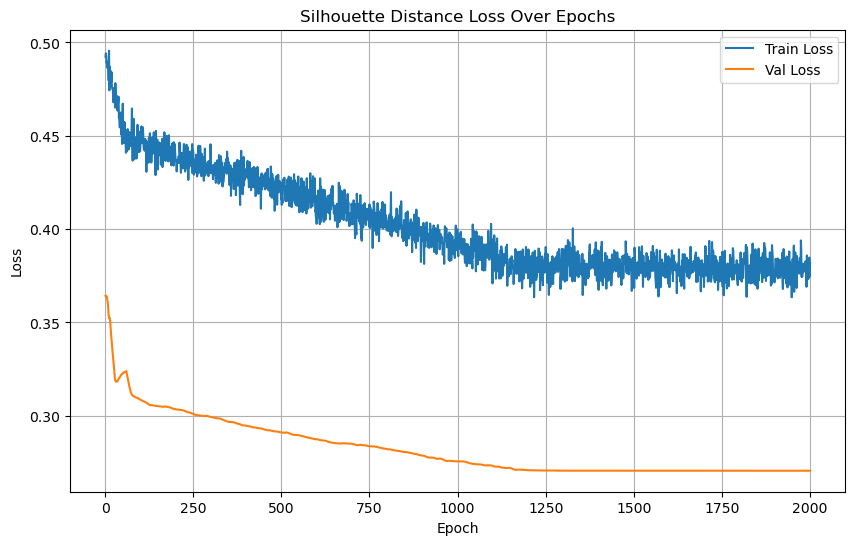

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/49], Loss: 0.2118


Test Batch [20/49], Loss: 0.3145
Test Batch [30/49], Loss: 0.3718
Test Batch [40/49], Loss: 0.2153

Test Loss: 0.3191


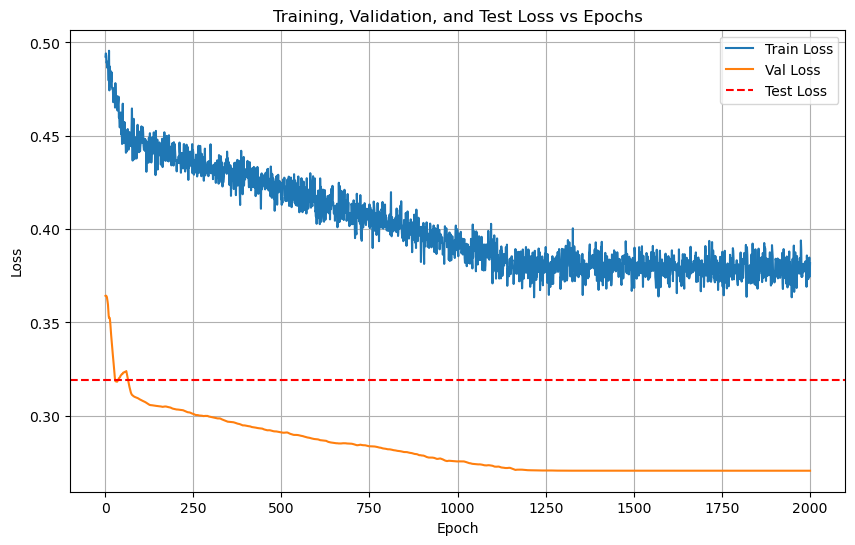

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/49 for test dataset.
  Processed batch 20/49 for test dataset.


  Processed batch 30/49 for test dataset.
  Processed batch 40/49 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.62      1.00      0.77         5
           3       0.83      1.00      0.91         5
           4       1.00      0.40      0.57         5
           5       0.62      1.00      0.77         5
           6       1.00      0.40      0.57         5
           7       0.80      0.80      0.80         5
           8       0.60      0.60      0.60         5
           9       0.62      1.00      0.77         5
          10       1.00      0.80      0.89         5
          11       0.67      0.80      0.73         5
          12       0.67      0.40      0.50         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6297  |  Val Loss: 2.6259
Validation loss improved from inf to 2.6259.
[Epoch 2/1000] Train Loss: 2.6205  |  Val Loss: 2.6191
Validation loss improved from 2.6259 to 2.6191.
[Epoch 3/1000] Train Loss: 2.6120  |  Val Loss: 2.6128
Validation loss improved from 2.6191 to 2.6128.
[Epoch 4/1000] Train Loss: 2.6043  |  Val Loss: 2.6066
Validation loss improved from 2.6128 to 2.6066.
[Epoch 5/1000] Train Loss: 2.5968  |  Val Loss: 2.6004
Validation loss improved from 2.6066 to 2.6004.
[Epoch 6/1000] Train Loss: 2.5895  |  Val Loss: 2.5941
Validation loss improved from 2.6004 to 2.5941.
[Epoch 7/1000] Train Loss: 2.5825  |  Val Loss: 2.5881
Validation loss improved from 2.5941 to 2.5881.
[Epoch 8/1000] Train Loss: 2.5751  |  Val Loss: 2.5824
Validation loss improved from 2.5881 to 2.5824.
[Epoch 9/1000] Train Loss: 2.5686  |  Val Loss: 2.5765
Validation loss improved from 2.5824 to 2.5765.
[Epoch 10/1000] Train Loss: 2.5621  |  Val Loss: 2.5709
Validation loss impr

[Epoch 28/1000] Train Loss: 2.4489  |  Val Loss: 2.4782
Validation loss improved from 2.4843 to 2.4782.
[Epoch 29/1000] Train Loss: 2.4416  |  Val Loss: 2.4722
Validation loss improved from 2.4782 to 2.4722.
[Epoch 30/1000] Train Loss: 2.4349  |  Val Loss: 2.4663
Validation loss improved from 2.4722 to 2.4663.
[Epoch 31/1000] Train Loss: 2.4282  |  Val Loss: 2.4606
Validation loss improved from 2.4663 to 2.4606.
[Epoch 32/1000] Train Loss: 2.4214  |  Val Loss: 2.4551
Validation loss improved from 2.4606 to 2.4551.
[Epoch 33/1000] Train Loss: 2.4148  |  Val Loss: 2.4498
Validation loss improved from 2.4551 to 2.4498.
[Epoch 34/1000] Train Loss: 2.4084  |  Val Loss: 2.4447
Validation loss improved from 2.4498 to 2.4447.
[Epoch 35/1000] Train Loss: 2.4021  |  Val Loss: 2.4397
Validation loss improved from 2.4447 to 2.4397.
[Epoch 36/1000] Train Loss: 2.3958  |  Val Loss: 2.4345
Validation loss improved from 2.4397 to 2.4345.


[Epoch 37/1000] Train Loss: 2.3896  |  Val Loss: 2.4291
Validation loss improved from 2.4345 to 2.4291.
[Epoch 38/1000] Train Loss: 2.3833  |  Val Loss: 2.4237
Validation loss improved from 2.4291 to 2.4237.
[Epoch 39/1000] Train Loss: 2.3770  |  Val Loss: 2.4186
Validation loss improved from 2.4237 to 2.4186.
[Epoch 40/1000] Train Loss: 2.3709  |  Val Loss: 2.4137
Validation loss improved from 2.4186 to 2.4137.
[Epoch 41/1000] Train Loss: 2.3652  |  Val Loss: 2.4088
Validation loss improved from 2.4137 to 2.4088.
[Epoch 42/1000] Train Loss: 2.3593  |  Val Loss: 2.4038
Validation loss improved from 2.4088 to 2.4038.
[Epoch 43/1000] Train Loss: 2.3535  |  Val Loss: 2.3987
Validation loss improved from 2.4038 to 2.3987.
[Epoch 44/1000] Train Loss: 2.3474  |  Val Loss: 2.3936
Validation loss improved from 2.3987 to 2.3936.
[Epoch 45/1000] Train Loss: 2.3413  |  Val Loss: 2.3883
Validation loss improved from 2.3936 to 2.3883.
[Epoch 46/1000] Train Loss: 2.3354  |  Val Loss: 2.3831
Validati

[Epoch 71/1000] Train Loss: 2.1794  |  Val Loss: 2.2606
Validation loss improved from 2.2650 to 2.2606.
[Epoch 72/1000] Train Loss: 2.1731  |  Val Loss: 2.2562
Validation loss improved from 2.2606 to 2.2562.
[Epoch 73/1000] Train Loss: 2.1671  |  Val Loss: 2.2519
Validation loss improved from 2.2562 to 2.2519.
[Epoch 74/1000] Train Loss: 2.1610  |  Val Loss: 2.2476
Validation loss improved from 2.2519 to 2.2476.
[Epoch 75/1000] Train Loss: 2.1553  |  Val Loss: 2.2433
Validation loss improved from 2.2476 to 2.2433.


[Epoch 76/1000] Train Loss: 2.1492  |  Val Loss: 2.2390
Validation loss improved from 2.2433 to 2.2390.
[Epoch 77/1000] Train Loss: 2.1434  |  Val Loss: 2.2346
Validation loss improved from 2.2390 to 2.2346.
[Epoch 78/1000] Train Loss: 2.1374  |  Val Loss: 2.2302
Validation loss improved from 2.2346 to 2.2302.
[Epoch 79/1000] Train Loss: 2.1314  |  Val Loss: 2.2259
Validation loss improved from 2.2302 to 2.2259.
[Epoch 80/1000] Train Loss: 2.1254  |  Val Loss: 2.2216
Validation loss improved from 2.2259 to 2.2216.
[Epoch 81/1000] Train Loss: 2.1195  |  Val Loss: 2.2173
Validation loss improved from 2.2216 to 2.2173.
[Epoch 82/1000] Train Loss: 2.1135  |  Val Loss: 2.2131
Validation loss improved from 2.2173 to 2.2131.
[Epoch 83/1000] Train Loss: 2.1073  |  Val Loss: 2.2090
Validation loss improved from 2.2131 to 2.2090.
[Epoch 84/1000] Train Loss: 2.1014  |  Val Loss: 2.2049
Validation loss improved from 2.2090 to 2.2049.
[Epoch 85/1000] Train Loss: 2.0955  |  Val Loss: 2.2010
Validati

[Epoch 110/1000] Train Loss: 1.9487  |  Val Loss: 2.0955
Validation loss improved from 2.0996 to 2.0955.
[Epoch 111/1000] Train Loss: 1.9430  |  Val Loss: 2.0913
Validation loss improved from 2.0955 to 2.0913.
[Epoch 112/1000] Train Loss: 1.9375  |  Val Loss: 2.0872
Validation loss improved from 2.0913 to 2.0872.
[Epoch 113/1000] Train Loss: 1.9319  |  Val Loss: 2.0831
Validation loss improved from 2.0872 to 2.0831.
[Epoch 114/1000] Train Loss: 1.9263  |  Val Loss: 2.0790
Validation loss improved from 2.0831 to 2.0790.
[Epoch 115/1000] Train Loss: 1.9208  |  Val Loss: 2.0749
Validation loss improved from 2.0790 to 2.0749.
[Epoch 116/1000] Train Loss: 1.9153  |  Val Loss: 2.0710
Validation loss improved from 2.0749 to 2.0710.
[Epoch 117/1000] Train Loss: 1.9097  |  Val Loss: 2.0670
Validation loss improved from 2.0710 to 2.0670.
[Epoch 118/1000] Train Loss: 1.9042  |  Val Loss: 2.0629
Validation loss improved from 2.0670 to 2.0629.
[Epoch 119/1000] Train Loss: 1.8989  |  Val Loss: 2.058

[Epoch 151/1000] Train Loss: 1.7086  |  Val Loss: 1.9148
Validation loss improved from 1.9193 to 1.9148.
[Epoch 152/1000] Train Loss: 1.7028  |  Val Loss: 1.9101
Validation loss improved from 1.9148 to 1.9101.
[Epoch 153/1000] Train Loss: 1.6968  |  Val Loss: 1.9055
Validation loss improved from 1.9101 to 1.9055.
[Epoch 154/1000] Train Loss: 1.6908  |  Val Loss: 1.9007
Validation loss improved from 1.9055 to 1.9007.
[Epoch 155/1000] Train Loss: 1.6849  |  Val Loss: 1.8960
Validation loss improved from 1.9007 to 1.8960.
[Epoch 156/1000] Train Loss: 1.6788  |  Val Loss: 1.8914
Validation loss improved from 1.8960 to 1.8914.
[Epoch 157/1000] Train Loss: 1.6728  |  Val Loss: 1.8865
Validation loss improved from 1.8914 to 1.8865.
[Epoch 158/1000] Train Loss: 1.6667  |  Val Loss: 1.8817
Validation loss improved from 1.8865 to 1.8817.
[Epoch 159/1000] Train Loss: 1.6606  |  Val Loss: 1.8771
Validation loss improved from 1.8817 to 1.8771.
[Epoch 160/1000] Train Loss: 1.6546  |  Val Loss: 1.872

[Epoch 192/1000] Train Loss: 1.4514  |  Val Loss: 1.6983
Validation loss improved from 1.7039 to 1.6983.
[Epoch 193/1000] Train Loss: 1.4452  |  Val Loss: 1.6929
Validation loss improved from 1.6983 to 1.6929.
[Epoch 194/1000] Train Loss: 1.4388  |  Val Loss: 1.6874
Validation loss improved from 1.6929 to 1.6874.
[Epoch 195/1000] Train Loss: 1.4328  |  Val Loss: 1.6821
Validation loss improved from 1.6874 to 1.6821.
[Epoch 196/1000] Train Loss: 1.4265  |  Val Loss: 1.6768
Validation loss improved from 1.6821 to 1.6768.
[Epoch 197/1000] Train Loss: 1.4206  |  Val Loss: 1.6714
Validation loss improved from 1.6768 to 1.6714.
[Epoch 198/1000] Train Loss: 1.4147  |  Val Loss: 1.6661
Validation loss improved from 1.6714 to 1.6661.
[Epoch 199/1000] Train Loss: 1.4088  |  Val Loss: 1.6609
Validation loss improved from 1.6661 to 1.6609.
[Epoch 200/1000] Train Loss: 1.4029  |  Val Loss: 1.6559
Validation loss improved from 1.6609 to 1.6559.
[Epoch 201/1000] Train Loss: 1.3971  |  Val Loss: 1.650

[Epoch 235/1000] Train Loss: 1.2021  |  Val Loss: 1.4796
Validation loss improved from 1.4845 to 1.4796.
[Epoch 236/1000] Train Loss: 1.1966  |  Val Loss: 1.4749
Validation loss improved from 1.4796 to 1.4749.
[Epoch 237/1000] Train Loss: 1.1909  |  Val Loss: 1.4702
Validation loss improved from 1.4749 to 1.4702.
[Epoch 238/1000] Train Loss: 1.1854  |  Val Loss: 1.4656
Validation loss improved from 1.4702 to 1.4656.
[Epoch 239/1000] Train Loss: 1.1799  |  Val Loss: 1.4607
Validation loss improved from 1.4656 to 1.4607.
[Epoch 240/1000] Train Loss: 1.1741  |  Val Loss: 1.4558
Validation loss improved from 1.4607 to 1.4558.
[Epoch 241/1000] Train Loss: 1.1685  |  Val Loss: 1.4509
Validation loss improved from 1.4558 to 1.4509.
[Epoch 242/1000] Train Loss: 1.1624  |  Val Loss: 1.4459
Validation loss improved from 1.4509 to 1.4459.
[Epoch 243/1000] Train Loss: 1.1566  |  Val Loss: 1.4409
Validation loss improved from 1.4459 to 1.4409.
[Epoch 244/1000] Train Loss: 1.1506  |  Val Loss: 1.435

[Epoch 280/1000] Train Loss: 0.9503  |  Val Loss: 1.2733
Validation loss improved from 1.2777 to 1.2733.
[Epoch 281/1000] Train Loss: 0.9453  |  Val Loss: 1.2690
Validation loss improved from 1.2733 to 1.2690.
[Epoch 282/1000] Train Loss: 0.9402  |  Val Loss: 1.2648
Validation loss improved from 1.2690 to 1.2648.
[Epoch 283/1000] Train Loss: 0.9350  |  Val Loss: 1.2605
Validation loss improved from 1.2648 to 1.2605.
[Epoch 284/1000] Train Loss: 0.9299  |  Val Loss: 1.2560
Validation loss improved from 1.2605 to 1.2560.
[Epoch 285/1000] Train Loss: 0.9246  |  Val Loss: 1.2517
Validation loss improved from 1.2560 to 1.2517.
[Epoch 286/1000] Train Loss: 0.9192  |  Val Loss: 1.2475
Validation loss improved from 1.2517 to 1.2475.
[Epoch 287/1000] Train Loss: 0.9138  |  Val Loss: 1.2431
Validation loss improved from 1.2475 to 1.2431.
[Epoch 288/1000] Train Loss: 0.9084  |  Val Loss: 1.2388
Validation loss improved from 1.2431 to 1.2388.
[Epoch 289/1000] Train Loss: 0.9034  |  Val Loss: 1.234

[Epoch 322/1000] Train Loss: 0.7444  |  Val Loss: 1.1036
Validation loss improved from 1.1075 to 1.1036.
[Epoch 323/1000] Train Loss: 0.7399  |  Val Loss: 1.0998
Validation loss improved from 1.1036 to 1.0998.
[Epoch 324/1000] Train Loss: 0.7354  |  Val Loss: 1.0959
Validation loss improved from 1.0998 to 1.0959.
[Epoch 325/1000] Train Loss: 0.7309  |  Val Loss: 1.0919
Validation loss improved from 1.0959 to 1.0919.
[Epoch 326/1000] Train Loss: 0.7267  |  Val Loss: 1.0880
Validation loss improved from 1.0919 to 1.0880.
[Epoch 327/1000] Train Loss: 0.7223  |  Val Loss: 1.0843
Validation loss improved from 1.0880 to 1.0843.
[Epoch 328/1000] Train Loss: 0.7181  |  Val Loss: 1.0807
Validation loss improved from 1.0843 to 1.0807.
[Epoch 329/1000] Train Loss: 0.7137  |  Val Loss: 1.0773
Validation loss improved from 1.0807 to 1.0773.
[Epoch 330/1000] Train Loss: 0.7094  |  Val Loss: 1.0737
Validation loss improved from 1.0773 to 1.0737.
[Epoch 331/1000] Train Loss: 0.7052  |  Val Loss: 1.070

[Epoch 360/1000] Train Loss: 0.5872  |  Val Loss: 0.9746
Validation loss improved from 0.9769 to 0.9746.
[Epoch 361/1000] Train Loss: 0.5835  |  Val Loss: 0.9724
Validation loss improved from 0.9746 to 0.9724.
[Epoch 362/1000] Train Loss: 0.5799  |  Val Loss: 0.9701
Validation loss improved from 0.9724 to 0.9701.
[Epoch 363/1000] Train Loss: 0.5763  |  Val Loss: 0.9676
Validation loss improved from 0.9701 to 0.9676.
[Epoch 364/1000] Train Loss: 0.5730  |  Val Loss: 0.9654
Validation loss improved from 0.9676 to 0.9654.
[Epoch 365/1000] Train Loss: 0.5696  |  Val Loss: 0.9632
Validation loss improved from 0.9654 to 0.9632.
[Epoch 366/1000] Train Loss: 0.5661  |  Val Loss: 0.9610
Validation loss improved from 0.9632 to 0.9610.
[Epoch 367/1000] Train Loss: 0.5629  |  Val Loss: 0.9588
Validation loss improved from 0.9610 to 0.9588.
[Epoch 368/1000] Train Loss: 0.5595  |  Val Loss: 0.9565
Validation loss improved from 0.9588 to 0.9565.
[Epoch 369/1000] Train Loss: 0.5562  |  Val Loss: 0.954

[Epoch 405/1000] Train Loss: 0.4475  |  Val Loss: 0.8722
Validation loss improved from 0.8737 to 0.8722.
[Epoch 406/1000] Train Loss: 0.4451  |  Val Loss: 0.8707
Validation loss improved from 0.8722 to 0.8707.
[Epoch 407/1000] Train Loss: 0.4425  |  Val Loss: 0.8695
Validation loss improved from 0.8707 to 0.8695.
[Epoch 408/1000] Train Loss: 0.4401  |  Val Loss: 0.8680
Validation loss improved from 0.8695 to 0.8680.
[Epoch 409/1000] Train Loss: 0.4375  |  Val Loss: 0.8662
Validation loss improved from 0.8680 to 0.8662.
[Epoch 410/1000] Train Loss: 0.4350  |  Val Loss: 0.8644
Validation loss improved from 0.8662 to 0.8644.
[Epoch 411/1000] Train Loss: 0.4324  |  Val Loss: 0.8626
Validation loss improved from 0.8644 to 0.8626.
[Epoch 412/1000] Train Loss: 0.4298  |  Val Loss: 0.8605
Validation loss improved from 0.8626 to 0.8605.
[Epoch 413/1000] Train Loss: 0.4272  |  Val Loss: 0.8583
Validation loss improved from 0.8605 to 0.8583.
[Epoch 414/1000] Train Loss: 0.4248  |  Val Loss: 0.856

[Epoch 448/1000] Train Loss: 0.3485  |  Val Loss: 0.7982
Validation loss improved from 0.7998 to 0.7982.
[Epoch 449/1000] Train Loss: 0.3465  |  Val Loss: 0.7966
Validation loss improved from 0.7982 to 0.7966.
[Epoch 450/1000] Train Loss: 0.3444  |  Val Loss: 0.7948
Validation loss improved from 0.7966 to 0.7948.
[Epoch 451/1000] Train Loss: 0.3425  |  Val Loss: 0.7930
Validation loss improved from 0.7948 to 0.7930.
[Epoch 452/1000] Train Loss: 0.3405  |  Val Loss: 0.7914
Validation loss improved from 0.7930 to 0.7914.
[Epoch 453/1000] Train Loss: 0.3385  |  Val Loss: 0.7898
Validation loss improved from 0.7914 to 0.7898.
[Epoch 454/1000] Train Loss: 0.3365  |  Val Loss: 0.7883
Validation loss improved from 0.7898 to 0.7883.
[Epoch 455/1000] Train Loss: 0.3346  |  Val Loss: 0.7867
Validation loss improved from 0.7883 to 0.7867.
[Epoch 456/1000] Train Loss: 0.3325  |  Val Loss: 0.7850
Validation loss improved from 0.7867 to 0.7850.
[Epoch 457/1000] Train Loss: 0.3307  |  Val Loss: 0.783

[Epoch 488/1000] Train Loss: 0.2786  |  Val Loss: 0.7529
Validation loss improved from 0.7532 to 0.7529.
[Epoch 489/1000] Train Loss: 0.2772  |  Val Loss: 0.7524
Validation loss improved from 0.7529 to 0.7524.
[Epoch 490/1000] Train Loss: 0.2758  |  Val Loss: 0.7518
Validation loss improved from 0.7524 to 0.7518.
[Epoch 491/1000] Train Loss: 0.2744  |  Val Loss: 0.7509
Validation loss improved from 0.7518 to 0.7509.
[Epoch 492/1000] Train Loss: 0.2730  |  Val Loss: 0.7496
Validation loss improved from 0.7509 to 0.7496.
[Epoch 493/1000] Train Loss: 0.2713  |  Val Loss: 0.7478
Validation loss improved from 0.7496 to 0.7478.
[Epoch 494/1000] Train Loss: 0.2698  |  Val Loss: 0.7456
Validation loss improved from 0.7478 to 0.7456.
[Epoch 495/1000] Train Loss: 0.2679  |  Val Loss: 0.7432
Validation loss improved from 0.7456 to 0.7432.
[Epoch 496/1000] Train Loss: 0.2662  |  Val Loss: 0.7408
Validation loss improved from 0.7432 to 0.7408.
[Epoch 497/1000] Train Loss: 0.2646  |  Val Loss: 0.738

[Epoch 529/1000] Train Loss: 0.2248  |  Val Loss: 0.7124
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 530/1000] Train Loss: 0.2238  |  Val Loss: 0.7122
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 531/1000] Train Loss: 0.2228  |  Val Loss: 0.7117
Validation loss improved from 0.7117 to 0.7117.
[Epoch 532/1000] Train Loss: 0.2217  |  Val Loss: 0.7107
Validation loss improved from 0.7117 to 0.7107.
[Epoch 533/1000] Train Loss: 0.2208  |  Val Loss: 0.7097
Validation loss improved from 0.7107 to 0.7097.
[Epoch 534/1000] Train Loss: 0.2197  |  Val Loss: 0.7086
Validation loss improved from 0.7097 to 0.7086.
[Epoch 535/1000] Train Loss: 0.2186  |  Val Loss: 0.7076
Validation loss improved from 0.7086 to 0.7076.
[Epoch 536/1000] Train Loss: 0.2176  |  Val Loss: 0.7066
Validation loss improved from 0.7076 to 0.7066.
[Epoch 537/1000] Train Loss: 0.2165  |  Val Loss: 0.7055
Validation loss improved from 0.7066 to 0.7055.
[Epoch 538/1000] Train Loss: 0.2155  |  Val

[Epoch 571/1000] Train Loss: 0.1836  |  Val Loss: 0.6860
Validation loss improved from 0.6867 to 0.6860.
[Epoch 572/1000] Train Loss: 0.1827  |  Val Loss: 0.6853
Validation loss improved from 0.6860 to 0.6853.
[Epoch 573/1000] Train Loss: 0.1819  |  Val Loss: 0.6848
Validation loss improved from 0.6853 to 0.6848.
[Epoch 574/1000] Train Loss: 0.1810  |  Val Loss: 0.6843
Validation loss improved from 0.6848 to 0.6843.
[Epoch 575/1000] Train Loss: 0.1801  |  Val Loss: 0.6837
Validation loss improved from 0.6843 to 0.6837.
[Epoch 576/1000] Train Loss: 0.1794  |  Val Loss: 0.6832
Validation loss improved from 0.6837 to 0.6832.
[Epoch 577/1000] Train Loss: 0.1787  |  Val Loss: 0.6828
Validation loss improved from 0.6832 to 0.6828.
[Epoch 578/1000] Train Loss: 0.1778  |  Val Loss: 0.6825
Validation loss improved from 0.6828 to 0.6825.
[Epoch 579/1000] Train Loss: 0.1771  |  Val Loss: 0.6822
Validation loss improved from 0.6825 to 0.6822.
[Epoch 580/1000] Train Loss: 0.1762  |  Val Loss: 0.681

[Epoch 616/1000] Train Loss: 0.1480  |  Val Loss: 0.6632
Validation loss improved from 0.6638 to 0.6632.
[Epoch 617/1000] Train Loss: 0.1471  |  Val Loss: 0.6627
Validation loss improved from 0.6632 to 0.6627.
[Epoch 618/1000] Train Loss: 0.1464  |  Val Loss: 0.6622
Validation loss improved from 0.6627 to 0.6622.
[Epoch 619/1000] Train Loss: 0.1456  |  Val Loss: 0.6617
Validation loss improved from 0.6622 to 0.6617.
[Epoch 620/1000] Train Loss: 0.1449  |  Val Loss: 0.6613
Validation loss improved from 0.6617 to 0.6613.
[Epoch 621/1000] Train Loss: 0.1442  |  Val Loss: 0.6607
Validation loss improved from 0.6613 to 0.6607.
[Epoch 622/1000] Train Loss: 0.1435  |  Val Loss: 0.6602
Validation loss improved from 0.6607 to 0.6602.
[Epoch 623/1000] Train Loss: 0.1429  |  Val Loss: 0.6603
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 624/1000] Train Loss: 0.1422  |  Val Loss: 0.6609
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 625/1000] Train Loss: 0.1415  |  Val

[Epoch 660/1000] Train Loss: 0.1207  |  Val Loss: 0.6547
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 661/1000] Train Loss: 0.1202  |  Val Loss: 0.6550
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 662/1000] Train Loss: 0.1199  |  Val Loss: 0.6552
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 663/1000] Train Loss: 0.1194  |  Val Loss: 0.6552
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 664/1000] Train Loss: 0.1190  |  Val Loss: 0.6551
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 665/1000] Train Loss: 0.1185  |  Val Loss: 0.6552
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 666/1000] Train Loss: 0.1182  |  Val Loss: 0.6554
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 667/1000] Train Loss: 0.1178  |  Val Loss: 0.6559
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 668/1000] Train Loss: 0.1173  |  Val Loss: 0.6569
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 702/1000] Train Loss: 0.0990  |  Val Loss: 0.6615
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 703/1000] Train Loss: 0.0986  |  Val Loss: 0.6609
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 704/1000] Train Loss: 0.0981  |  Val Loss: 0.6603
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 705/1000] Train Loss: 0.0976  |  Val Loss: 0.6599
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 706/1000] Train Loss: 0.0972  |  Val Loss: 0.6597
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 707/1000] Train Loss: 0.0966  |  Val Loss: 0.6596
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 708/1000] Train Loss: 0.0962  |  Val Loss: 0.6595
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 709/1000] Train Loss: 0.0957  |  Val Loss: 0.6596
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 710/1000] Train Loss: 0.0953  |  Val Loss: 0.6599
!! Validation loss did NOT improve !! Patience:

[Epoch 742/1000] Train Loss: 0.0822  |  Val Loss: 0.6537
Validation loss improved from 0.6538 to 0.6537.
[Epoch 743/1000] Train Loss: 0.0818  |  Val Loss: 0.6537
Validation loss improved from 0.6537 to 0.6537.
[Epoch 744/1000] Train Loss: 0.0813  |  Val Loss: 0.6538
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 745/1000] Train Loss: 0.0809  |  Val Loss: 0.6538
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 746/1000] Train Loss: 0.0805  |  Val Loss: 0.6539
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 747/1000] Train Loss: 0.0802  |  Val Loss: 0.6539
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 748/1000] Train Loss: 0.0798  |  Val Loss: 0.6536
Validation loss improved from 0.6537 to 0.6536.
[Epoch 749/1000] Train Loss: 0.0795  |  Val Loss: 0.6533
Validation loss improved from 0.6536 to 0.6533.
[Epoch 750/1000] Train Loss: 0.0791  |  Val Loss: 0.6529
Validation loss improved from 0.6533 to 0.6529.
[Epoch 751/1000] Train Loss: 0.

[Epoch 784/1000] Train Loss: 0.0680  |  Val Loss: 0.6445
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 785/1000] Train Loss: 0.0677  |  Val Loss: 0.6444
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 786/1000] Train Loss: 0.0674  |  Val Loss: 0.6442
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 787/1000] Train Loss: 0.0671  |  Val Loss: 0.6441
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 788/1000] Train Loss: 0.0669  |  Val Loss: 0.6435
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 789/1000] Train Loss: 0.0665  |  Val Loss: 0.6427
Validation loss improved from 0.6434 to 0.6427.
[Epoch 790/1000] Train Loss: 0.0662  |  Val Loss: 0.6419
Validation loss improved from 0.6427 to 0.6419.
[Epoch 791/1000] Train Loss: 0.0658  |  Val Loss: 0.6413
Validation loss improved from 0.6419 to 0.6413.
[Epoch 792/1000] Train Loss: 0.0655  |  Val Loss: 0.6412
Validation loss improved from 0.6413 to 0.6412.
[Epoch 793/1000] Tra

[Epoch 825/1000] Train Loss: 0.0575  |  Val Loss: 0.6498
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 826/1000] Train Loss: 0.0574  |  Val Loss: 0.6502
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 827/1000] Train Loss: 0.0572  |  Val Loss: 0.6505
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 828/1000] Train Loss: 0.0569  |  Val Loss: 0.6509
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 829/1000] Train Loss: 0.0566  |  Val Loss: 0.6510
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 830/1000] Train Loss: 0.0563  |  Val Loss: 0.6506
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 831/1000] Train Loss: 0.0560  |  Val Loss: 0.6503
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 832/1000] Train Loss: 0.0556  |  Val Loss: 0.6503
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 833/1000] Train Loss: 0.0553  |  Val Loss: 0.6503
!! Validation loss did NOT improve !! Patience:

[Epoch 865/1000] Train Loss: 0.0482  |  Val Loss: 0.6416
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 866/1000] Train Loss: 0.0481  |  Val Loss: 0.6415
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 867/1000] Train Loss: 0.0479  |  Val Loss: 0.6414
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 868/1000] Train Loss: 0.0477  |  Val Loss: 0.6412
Validation loss improved from 0.6412 to 0.6412.
[Epoch 869/1000] Train Loss: 0.0476  |  Val Loss: 0.6409
Validation loss improved from 0.6412 to 0.6409.
[Epoch 870/1000] Train Loss: 0.0474  |  Val Loss: 0.6406
Validation loss improved from 0.6409 to 0.6406.
[Epoch 871/1000] Train Loss: 0.0473  |  Val Loss: 0.6403
Validation loss improved from 0.6406 to 0.6403.
[Epoch 872/1000] Train Loss: 0.0472  |  Val Loss: 0.6402
Validation loss improved from 0.6403 to 0.6402.
[Epoch 873/1000] Train Loss: 0.0470  |  Val Loss: 0.6401
Validation loss improved from 0.6402 to 0.6401.
[Epoch 874/1000] Train Loss: 0.046

[Epoch 907/1000] Train Loss: 0.0409  |  Val Loss: 0.6498
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 908/1000] Train Loss: 0.0408  |  Val Loss: 0.6501
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 909/1000] Train Loss: 0.0406  |  Val Loss: 0.6505
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 910/1000] Train Loss: 0.0405  |  Val Loss: 0.6509
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 911/1000] Train Loss: 0.0404  |  Val Loss: 0.6509
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 912/1000] Train Loss: 0.0402  |  Val Loss: 0.6506
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 913/1000] Train Loss: 0.0400  |  Val Loss: 0.6502
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 914/1000] Train Loss: 0.0398  |  Val Loss: 0.6496
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 915/1000] Train Loss: 0.0396  |  Val Loss: 0.6491
!! Validation loss did NOT improve !! Patience:

[Epoch 947/1000] Train Loss: 0.0353  |  Val Loss: 0.6543
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 948/1000] Train Loss: 0.0352  |  Val Loss: 0.6544
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 949/1000] Train Loss: 0.0351  |  Val Loss: 0.6543
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 950/1000] Train Loss: 0.0349  |  Val Loss: 0.6540
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 951/1000] Train Loss: 0.0347  |  Val Loss: 0.6535
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 952/1000] Train Loss: 0.0346  |  Val Loss: 0.6526
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 953/1000] Train Loss: 0.0343  |  Val Loss: 0.6516
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 954/1000] Train Loss: 0.0341  |  Val Loss: 0.6508
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 955/1000] Train Loss: 0.0339  |  Val Loss: 0.6501
!! Validation loss did NOT improve !! Patience:

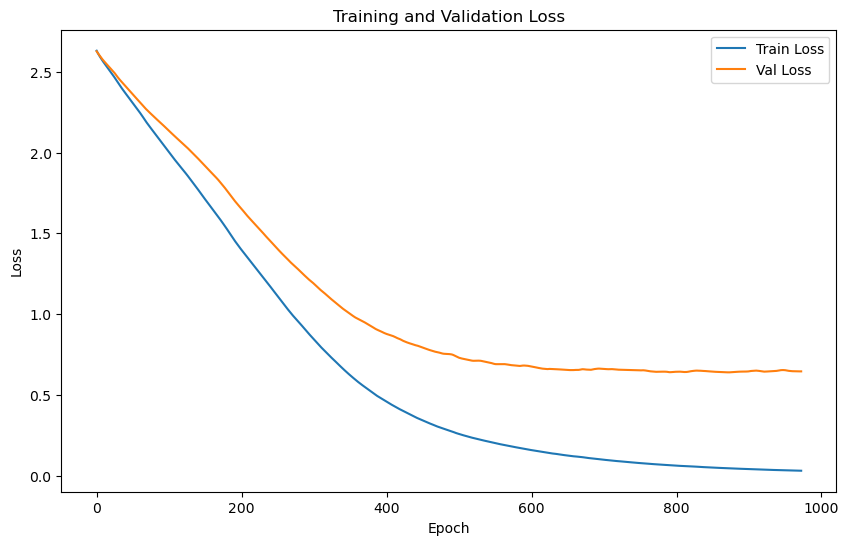

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7291 | Test Accuracy: 76.99%


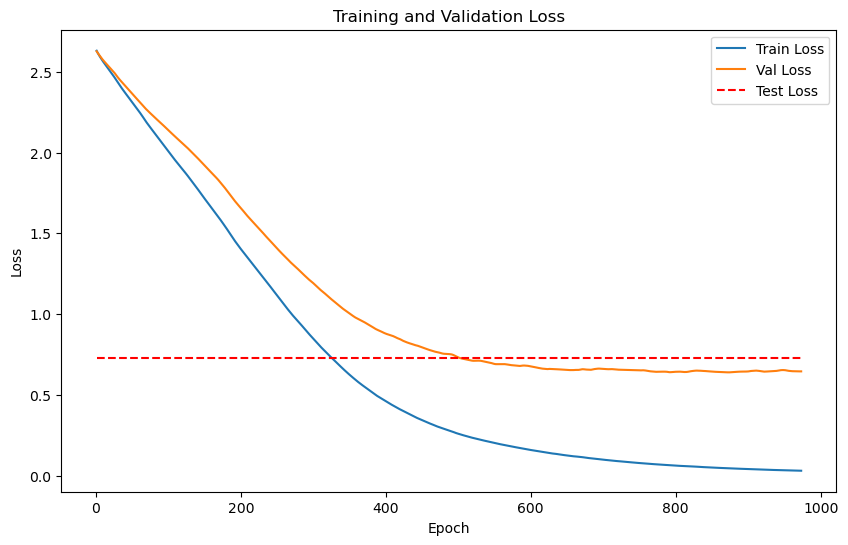

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


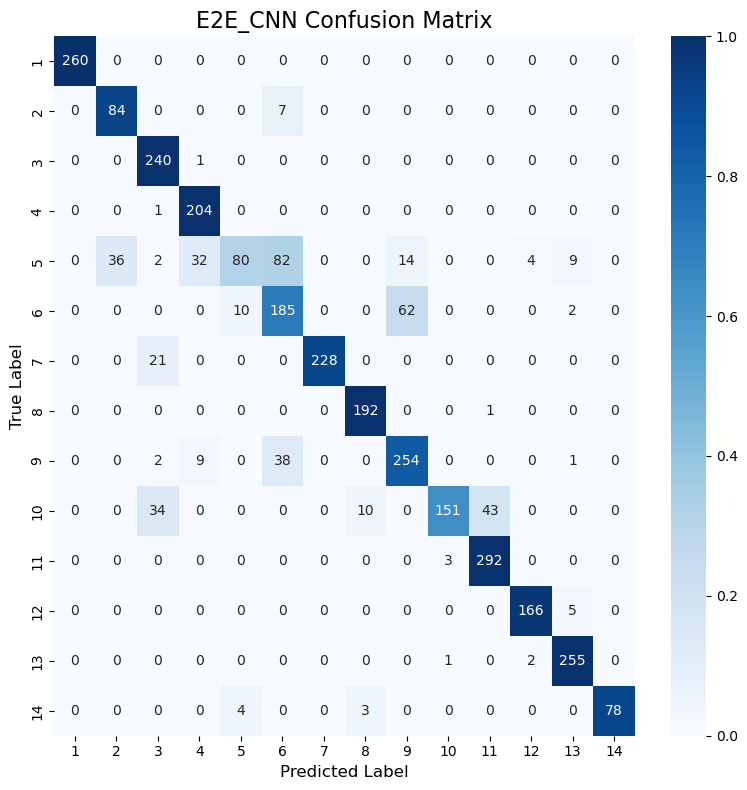

Classification Accuracy: 85.88%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


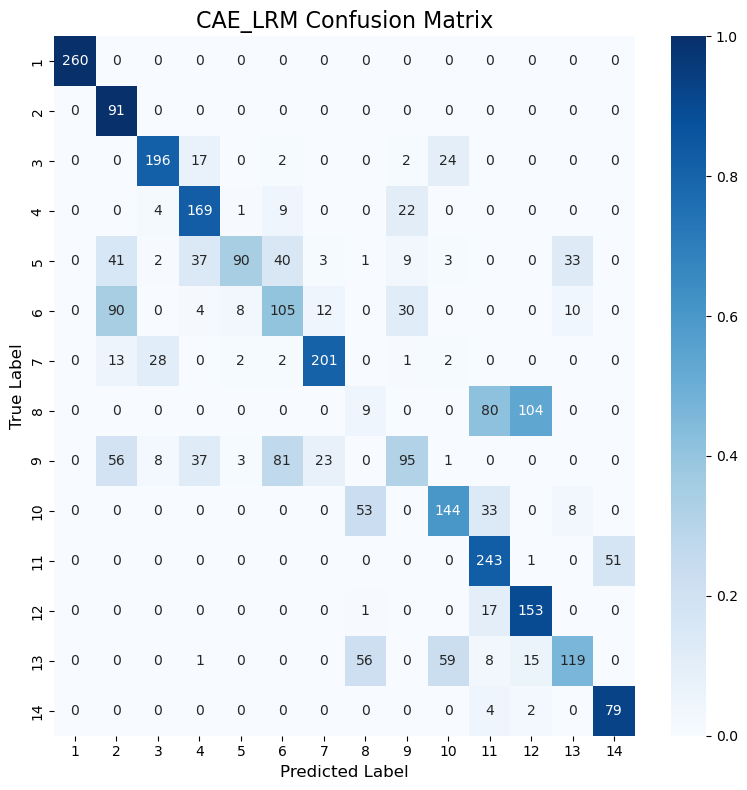

Classification Accuracy: 62.87%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


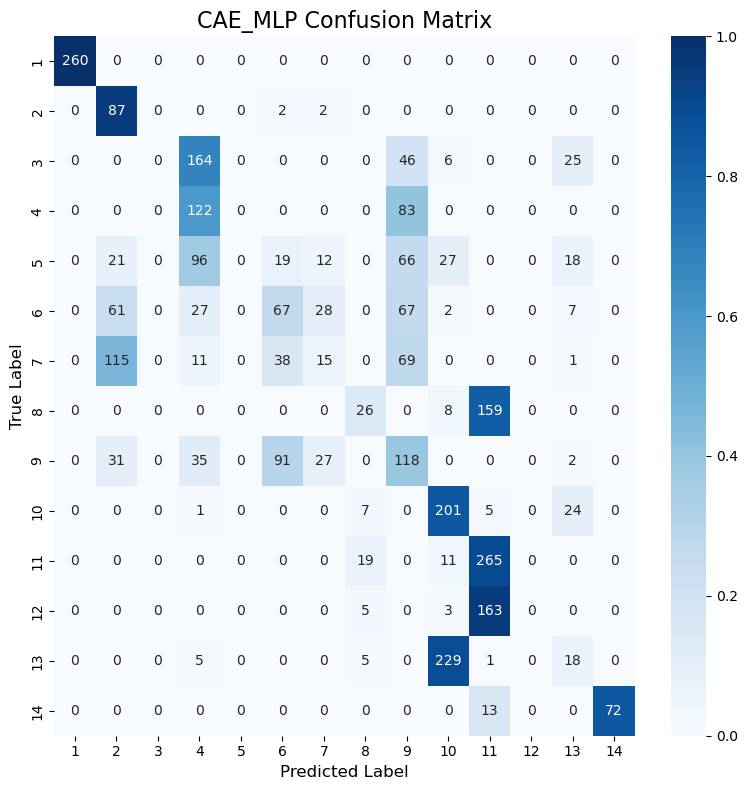

Classification Accuracy: 40.25%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


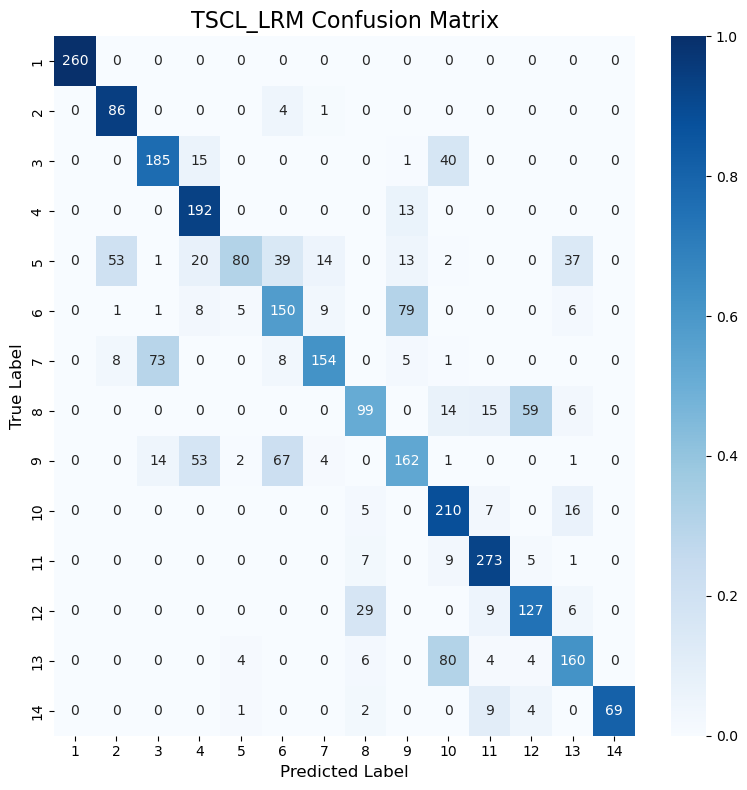

Classification Accuracy: 71.01%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


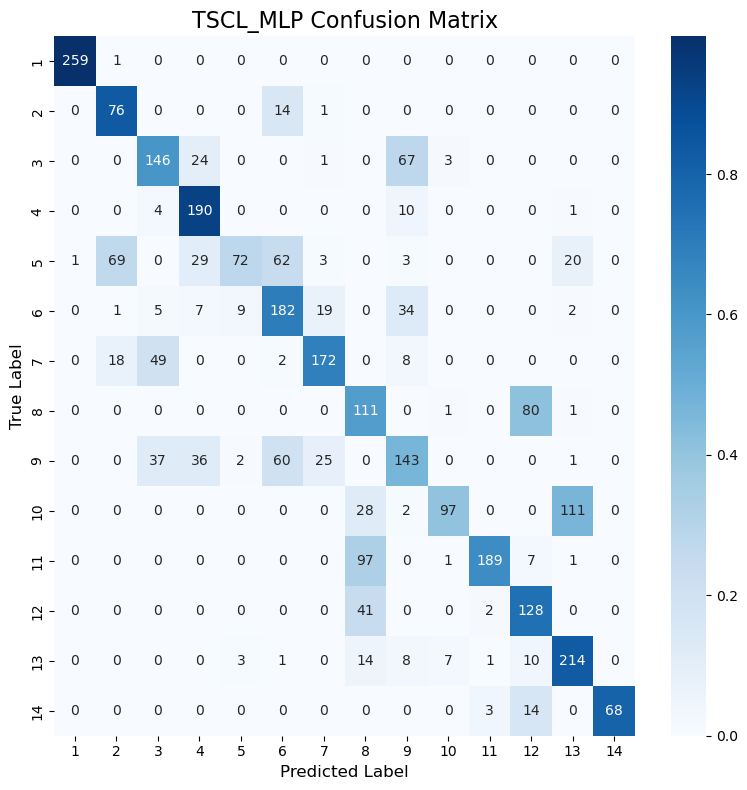

Classification Accuracy: 65.86%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


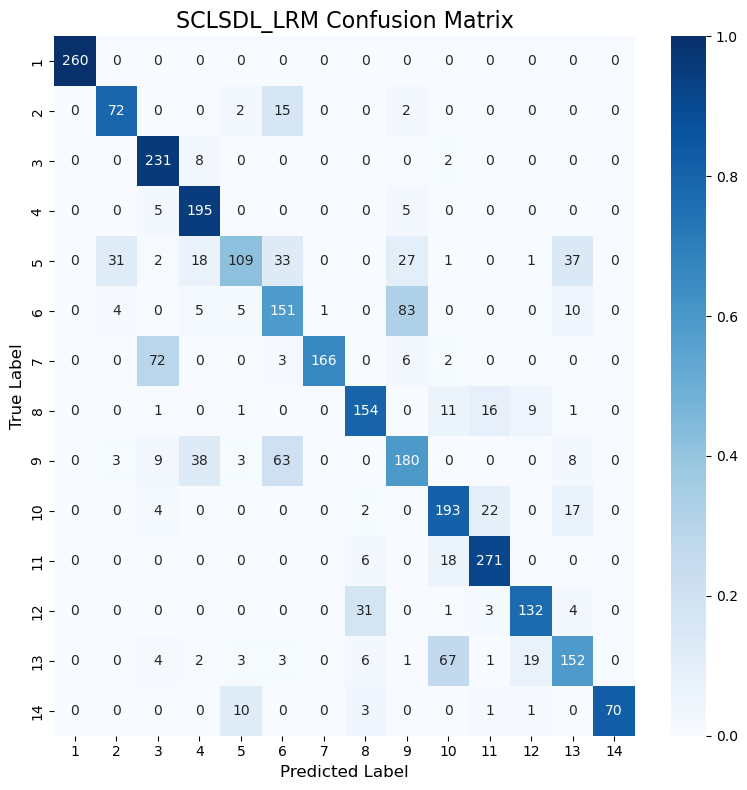

Classification Accuracy: 75.16%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


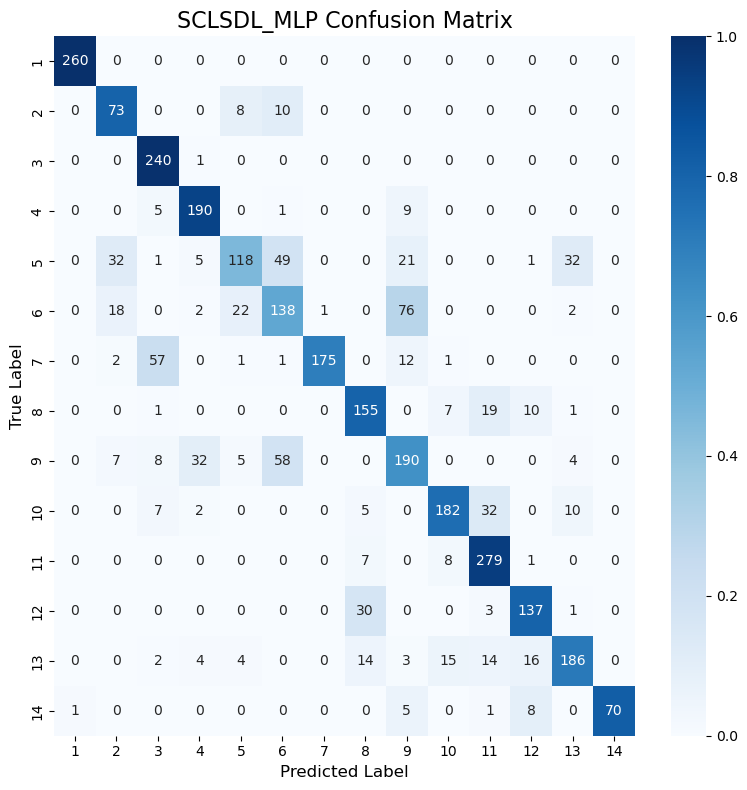

Classification Accuracy: 76.99%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          85.88
1    LRM (CAE)          62.87
2    MLP (CAE)          40.25
3     TSCL LRM          71.01
4     TSCL MLP          65.86
5  SCL_SDL LRM          75.16
6  SCL_SDL MLP          76.99

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          85.88
6  SCL_SDL MLP          76.99
5  SCL_SDL LRM          75.16
3     TSCL LRM          71.01
4     TSCL MLP          65.86
1    LRM (CAE)          62.87
2    MLP (CAE)          40.25
